In [1]:
# %matplotlib inline


# 1) Wipe out your namespace
%reset -f

# 2) Clear Jupyter’s stored outputs (and inputs if you like)
try:
    Out.clear()
except NameError:
    pass

try:
    In.clear()
except NameError:
    pass

# 3) Force Python GC
import gc
gc.collect()

# 4) Free any GPU buffers
import torch
if torch.cuda.is_available():
    torch.cuda.empty_cache()


import importlib
from libs import trades, plots, params, feats
importlib.reload(trades)
importlib.reload(plots)
importlib.reload(params)
importlib.reload(feats)

<module 'libs.feats' from '/workspace/my_models/Trading/_Stock_Analysis_/libs/feats.py'>

In [3]:
import matplotlib
import matplotlib.pyplot as plt
plt.ioff()

import math
import pandas as pd
from pandas import Timestamp
import numpy as np

import glob
import datetime as dt
from datetime import datetime

import optuna
from optuna.trial import TrialState
from optuna.importance import get_param_importances
from optuna.visualization.matplotlib import plot_optimization_history

import json
from IPython.display import display, clear_output, update_display, HTML

import io
import os
import json
import contextlib
from tqdm.auto import tqdm

pd.set_option('display.max_columns', None)


Running process_splits …
Reading data from intraday_stocks/AAPL_20040102_20250618.csv
Plotting original data...


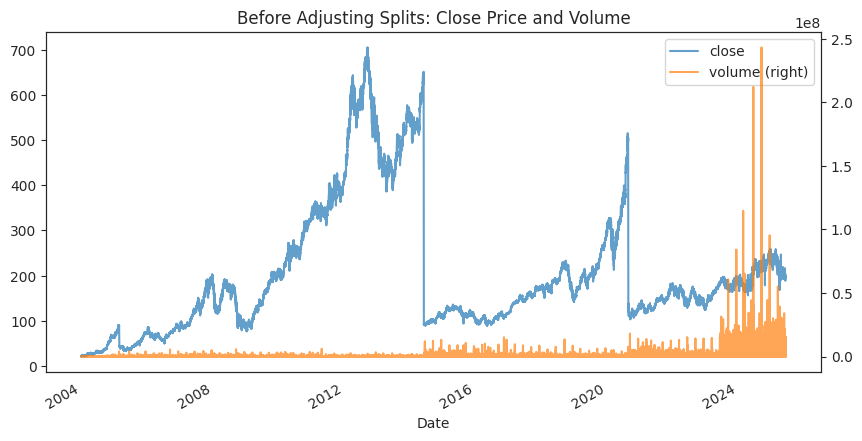

Detected forward split on 2014-06-09 08:00:00 with factor 7 (ratio: 0.1431)
Detected forward split on 2020-08-31 08:00:00 with factor 4 (ratio: 0.2510)
Splits detected. Plotting adjusted data...


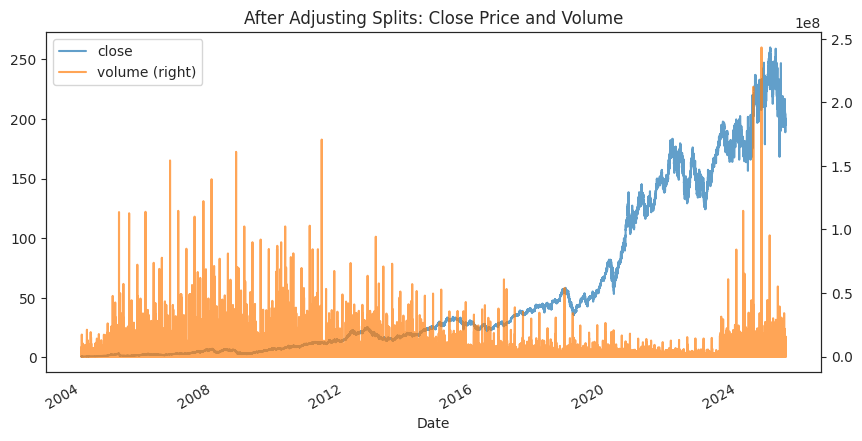

Running prepare_interpolate_data …
prepare_interpolate_data: removed 0 duplicate timestamps.
[process_splits] Saved processed data to: dfs/AAPL_1_base.csv


,open,high,low,close,volume,ask,bid
2004-01-02 09:00:00,0.764286,0.764286,0.764286,0.764286,28000.0,0.764857,0.763714
2004-01-02 09:01:00,0.764286,0.764286,0.764286,0.764286,28000.0,0.764857,0.763714
2004-01-02 09:02:00,0.764286,0.764286,0.764286,0.764286,28000.0,0.764857,0.763714
2004-01-02 09:03:00,0.764286,0.764286,0.764286,0.764286,28000.0,0.764857,0.763714
2004-01-02 09:04:00,0.764286,0.764286,0.764286,0.764286,28000.0,0.764857,0.763714
...,...,...,...,...,...,...,...
2025-06-18 20:56:00,196.680000,196.860000,196.630000,196.815000,385695.0,196.962600,196.667400
2025-06-18 20:57:00,196.810000,196.940000,196.560000,196.675000,460630.0,196.822500,196.527500
2025-06-18 20:58:00,196.675000,196.740000,196.630000,196.670000,525245.0,196.817500,196.522500
2025-06-18 20:59:00,196.680000,196.750000,196.240000,196.240000,2075503.0,196.387200,196.092800


In [4]:
n_trials = 300
n_jobs = 1

base_csv = params.base_csv

print(f"Running process_splits …")
df_raw = trades.process_splits(
    folder              = params.stocks_folder,
    ticker              = params.ticker,
    bidasktoclose_pct   = params.bidasktoclose_pct
)

# Once‐only minute grid build and interpolation
print(f"Running prepare_interpolate_data …")
df = trades.prepare_interpolate_data(
    df              = df_raw,
    sess_premark    = params.sess_premark,
    sess_start      = params.sess_start,
    sess_end        = params.sess_end
)

# Persist to base CSV and return
df.to_csv(base_csv)
print(f"[process_splits] Saved processed data to: {base_csv}")

# df is now guaranteed to be the split‐adjusted, minute‐aligned DataFrame
df


In [5]:
def optimization_function(
    df: pd.DataFrame,
    min_prof_thr: float,
    max_down_prop: float,
    gain_tightening_factor: float,
    merging_retracement_thr: float,
    merging_time_gap_thr: float,
    tau_time: int,
    tau_dur: int,
    trailing_stop_pct: float,
    buy_threshold: float,
    smoothing_window: int
) -> float:
    """
    1) Run the full backtest pipeline to simulate trades and P&L per day.
    2) Extract each day’s performance stats (strategy return and trade returns).
    3) Free intermediate DataFrames and trade lists to minimize memory usage.
    4) Compute total and average daily P&L across all trading days.
    5) Compute total trades and average return per trade.
    6) Print a summary of P&L metrics.
    Returns the average daily P&L for Optuna’s objective.
    """
    # A) Execute the end-to-end trading simulation
    simulation = trades.run_trading_pipeline(
        df, 
        col_signal="signal",
        col_action="signal_action",
        min_prof_thr=min_prof_thr,
        max_down_prop=max_down_prop,
        gain_tightening_factor=gain_tightening_factor,
        merging_retracement_thr=merging_retracement_thr,
        merging_time_gap_thr=merging_time_gap_thr,
        tau_time=tau_time,
        tau_dur=tau_dur,
        trailing_stop_pct=trailing_stop_pct,
        buy_threshold=buy_threshold,
        smoothing_window=smoothing_window
    )
    
    # If pipeline returned None (no trading days), bail out
    if not simulation:
        return 0.0

    # B) Extract per-day performance stats from simulation output
    per_day_stats = [
        stats 
        for (_, (_, _, stats)) 
        in simulation.items()
    ]

    # C) Release DataFrames and trade lists to free memory
    for (_, (df_sim, trades_list, _)) in simulation.items():
        del df_sim, trades_list
    num_days = len(simulation)
    del simulation
    gc.collect()
    if torch.cuda.is_available():
        torch.cuda.empty_cache()

    # D) Compute total and average daily P&L
    daily_returns = [s["Strategy Return ($)"] for s in per_day_stats]
    total_pnl     = float(np.sum(daily_returns))
    avg_daily_pnl = total_pnl / num_days

    # E) Compute trade-level metrics: total trades and avg return per trade
    trades_only_days = [s for s in per_day_stats if s["Trades Returns ($)"]]
    total_trades     = sum(len(s["Trades Returns ($)"]) for s in trades_only_days)
    avg_per_trade    = (total_pnl / total_trades) if total_trades else 0.0

    # F) Print a summary of results
    print(f"→ Total P&L over {num_days} days   : ${total_pnl:.2f}")
    print(f"→ Avg daily P&L                    : ${avg_daily_pnl:.4f}")
    print(f"→ Total trades                     : {total_trades}")
    print(f"→ Avg return per trade            : ${avg_per_trade:.4f}\n")

    return avg_daily_pnl


In [6]:
def objective(trial):
    hyperpars = {
        "min_prof_thr"            : trial.suggest_float("min_prof_thr", 0.01, 0.1), # increasing min, to avoid creating too many trades
        "max_down_prop"           : trial.suggest_float("max_down_prop", 0.1, 1),
        "gain_tightening_factor"  : trial.suggest_float("gain_tightening_factor", 5, 25),
        "merging_retracement_thr" : trial.suggest_float("merging_retracement_thr", 0.1, 1),
        "merging_time_gap_thr"    : trial.suggest_float("merging_time_gap_thr", 1, 7),
        "tau_time"                : trial.suggest_int("tau_time", 1, 60),
        "tau_dur"                 : trial.suggest_int("tau_dur", 60, 240),
        "trailing_stop_pct"       : trial.suggest_float("trailing_stop_pct", 0.03, 0.1), # increasing min, to reproduce a realistic scenario of trailing stop loss
        "buy_threshold"           : trial.suggest_float("buy_threshold", 0.1, 0.7),
        "smoothing_window"        : trial.suggest_categorical("smoothing_window", [30])
    }

    print('---------------------------------------------------------------------------------------------------------------\n')
    #    This will print Total P&L and Average Daily P&L, and return `avg_daily_pnl` for Optuna to maximize.
    avg_daily_pnl = optimization_function(df=df, **hyperpars)

    return avg_daily_pnl


[I 2025-09-08 16:02:28,623] A new study created in RDB with name: no-name-9c17001e-cf8e-49e0-839a-ad274fca3e8b


---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Scale & cap the smoothed signal ( top & bottom percentiles set at 7.983 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [03:30<00:00, 25.65day/s]
[I 2025-09-08 16:06:40,757] Trial 0 finished with value: 0.35519944444444446 and parameters: {'min_prof_thr': 0.07929316822505993, 'max_down_prop': 0.5754749183053841, 'gain_tightening_factor': 18.844731513517175, 'merging_retracement_thr': 0.9170550192336818, 'merging_time_gap_thr': 4.914841891949057, 'tau_time': 21, 'tau_dur': 179, 'trailing_stop_pct': 0.07101835055028952, 'buy_threshold': 0.5109192926993535, 'smoothing_window': 30}. Best is trial 0 with value: 0.35519944444444446.


→ Total P&L over 5400 days   : $1918.08
→ Avg daily P&L                    : $0.3552
→ Total trades                     : 12254
→ Avg return per trade            : $0.1565



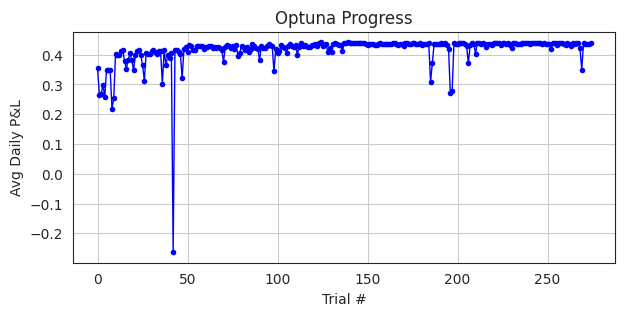

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Scale & cap the smoothed signal ( top & bottom percentiles set at 6.067 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [06:03<00:00, 14.86day/s]
[I 2025-09-08 16:14:00,534] Trial 1 finished with value: 0.26543537037037035 and parameters: {'min_prof_thr': 0.040707327879770536, 'max_down_prop': 0.5099496584066555, 'gain_tightening_factor': 8.314521031041632, 'merging_retracement_thr': 0.48670432813198994, 'merging_time_gap_thr': 4.190307961909713, 'tau_time': 7, 'tau_dur': 160, 'trailing_stop_pct': 0.06544844129714514, 'buy_threshold': 0.307986641731253, 'smoothing_window': 30}. Best is trial 0 with value: 0.35519944444444446.


→ Total P&L over 5400 days   : $1433.35
→ Avg daily P&L                    : $0.2654
→ Total trades                     : 20660
→ Avg return per trade            : $0.0694

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Scale & cap the smoothed signal ( top & bottom percentiles set at 5.714 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [04:06<00:00, 21.93day/s]
[I 2025-09-08 16:19:22,985] Trial 2 finished with value: 0.2689446296296296 and parameters: {'min_prof_thr': 0.02983315072651755, 'max_down_prop': 0.5349075747428723, 'gain_tightening_factor': 5.231704374723498, 'merging_retracement_thr': 0.9753352463513515, 'merging_time_gap_thr': 4.230803964889315, 'tau_time': 37, 'tau_dur': 203, 'trailing_stop_pct': 0.060012163034478844, 'buy_threshold': 0.11354435170922708, 'smoothing_window': 30}. Best is trial 0 with value: 0.35519944444444446.


→ Total P&L over 5400 days   : $1452.30
→ Avg daily P&L                    : $0.2689
→ Total trades                     : 16372
→ Avg return per trade            : $0.0887

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Scale & cap the smoothed signal ( top & bottom percentiles set at 7.429 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [04:04<00:00, 22.04day/s]  
[I 2025-09-08 16:23:54,636] Trial 3 finished with value: 0.2984461111111111 and parameters: {'min_prof_thr': 0.06820434611188257, 'max_down_prop': 0.5890279718289859, 'gain_tightening_factor': 24.164559034516646, 'merging_retracement_thr': 0.21493019015386727, 'merging_time_gap_thr': 6.080538145739603, 'tau_time': 32, 'tau_dur': 210, 'trailing_stop_pct': 0.05040116167780728, 'buy_threshold': 0.6498136217843048, 'smoothing_window': 30}. Best is trial 0 with value: 0.35519944444444446.


→ Total P&L over 5400 days   : $1611.61
→ Avg daily P&L                    : $0.2984
→ Total trades                     : 7229
→ Avg return per trade            : $0.2229

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Scale & cap the smoothed signal ( top & bottom percentiles set at 5.842 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [03:58<00:00, 22.61day/s]
[I 2025-09-08 16:28:29,817] Trial 4 finished with value: 0.2569461111111111 and parameters: {'min_prof_thr': 0.030774745888919083, 'max_down_prop': 0.522251224278745, 'gain_tightening_factor': 20.55622213361789, 'merging_retracement_thr': 0.7541005851425105, 'merging_time_gap_thr': 4.422341268901094, 'tau_time': 7, 'tau_dur': 106, 'trailing_stop_pct': 0.05112250945919296, 'buy_threshold': 0.4913995832429038, 'smoothing_window': 30}. Best is trial 0 with value: 0.35519944444444446.


→ Total P&L over 5400 days   : $1387.51
→ Avg daily P&L                    : $0.2569
→ Total trades                     : 14202
→ Avg return per trade            : $0.0977

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Scale & cap the smoothed signal ( top & bottom percentiles set at 6.12 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [03:11<00:00, 28.22day/s]


→ Total P&L over 5400 days   : $1890.23
→ Avg daily P&L                    : $0.3500
→ Total trades                     : 10296
→ Avg return per trade            : $0.1836



[I 2025-09-08 16:32:30,190] Trial 5 finished with value: 0.35004185185185177 and parameters: {'min_prof_thr': 0.038690890214524085, 'max_down_prop': 0.4972844153539199, 'gain_tightening_factor': 22.91444832100595, 'merging_retracement_thr': 0.23938660976541604, 'merging_time_gap_thr': 3.343838476340208, 'tau_time': 56, 'tau_dur': 69, 'trailing_stop_pct': 0.06283391607615049, 'buy_threshold': 0.32456811087199444, 'smoothing_window': 30}. Best is trial 0 with value: 0.35519944444444446.


---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Scale & cap the smoothed signal ( top & bottom percentiles set at 5.998 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [03:50<00:00, 23.39day/s]
[I 2025-09-08 16:37:02,585] Trial 6 finished with value: 0.34760851851851854 and parameters: {'min_prof_thr': 0.03758057250921613, 'max_down_prop': 0.6715713958105947, 'gain_tightening_factor': 20.139984349856853, 'merging_retracement_thr': 0.2762888060666903, 'merging_time_gap_thr': 2.624991681447897, 'tau_time': 18, 'tau_dur': 236, 'trailing_stop_pct': 0.04946739950696334, 'buy_threshold': 0.5782357822429834, 'smoothing_window': 30}. Best is trial 0 with value: 0.35519944444444446.


→ Total P&L over 5400 days   : $1877.09
→ Avg daily P&L                    : $0.3476
→ Total trades                     : 9033
→ Avg return per trade            : $0.2078

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Scale & cap the smoothed signal ( top & bottom percentiles set at 7.354 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [04:06<00:00, 21.89day/s]
[I 2025-09-08 16:41:49,441] Trial 7 finished with value: 0.34757444444444446 and parameters: {'min_prof_thr': 0.06785024496008113, 'max_down_prop': 0.3543395881178283, 'gain_tightening_factor': 7.2541462867712925, 'merging_retracement_thr': 0.14576814625415208, 'merging_time_gap_thr': 3.4650679294621805, 'tau_time': 39, 'tau_dur': 177, 'trailing_stop_pct': 0.060453515128969626, 'buy_threshold': 0.24836889579422802, 'smoothing_window': 30}. Best is trial 0 with value: 0.35519944444444446.


→ Total P&L over 5400 days   : $1876.90
→ Avg daily P&L                    : $0.3476
→ Total trades                     : 14562
→ Avg return per trade            : $0.1289

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Scale & cap the smoothed signal ( top & bottom percentiles set at 7.558 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [04:03<00:00, 22.17day/s]
[I 2025-09-08 16:46:31,184] Trial 8 finished with value: 0.2183948148148148 and parameters: {'min_prof_thr': 0.08317335877977962, 'max_down_prop': 0.7818666661317218, 'gain_tightening_factor': 11.056311298003838, 'merging_retracement_thr': 0.4010378073282904, 'merging_time_gap_thr': 3.997171523573031, 'tau_time': 17, 'tau_dur': 160, 'trailing_stop_pct': 0.04746555057604544, 'buy_threshold': 0.13603256334783223, 'smoothing_window': 30}. Best is trial 0 with value: 0.35519944444444446.


→ Total P&L over 5400 days   : $1179.33
→ Avg daily P&L                    : $0.2184
→ Total trades                     : 19767
→ Avg return per trade            : $0.0597

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Scale & cap the smoothed signal ( top & bottom percentiles set at 6.527 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [04:16<00:00, 21.05day/s]
[I 2025-09-08 16:51:28,296] Trial 9 finished with value: 0.25413481481481487 and parameters: {'min_prof_thr': 0.05270548745344005, 'max_down_prop': 0.47037813626720737, 'gain_tightening_factor': 8.596846440391005, 'merging_retracement_thr': 0.21468983793510887, 'merging_time_gap_thr': 5.465956644995467, 'tau_time': 5, 'tau_dur': 91, 'trailing_stop_pct': 0.05410300628178389, 'buy_threshold': 0.5459362803036582, 'smoothing_window': 30}. Best is trial 0 with value: 0.35519944444444446.


→ Total P&L over 5400 days   : $1372.33
→ Avg daily P&L                    : $0.2541
→ Total trades                     : 13733
→ Avg return per trade            : $0.0999

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Scale & cap the smoothed signal ( top & bottom percentiles set at 8.317 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [04:07<00:00, 21.84day/s]
[I 2025-09-08 16:56:05,340] Trial 10 finished with value: 0.40321944444444446 and parameters: {'min_prof_thr': 0.0995273807025513, 'max_down_prop': 0.9929861181732933, 'gain_tightening_factor': 15.654565816876493, 'merging_retracement_thr': 0.7659801320597075, 'merging_time_gap_thr': 1.6068826464156798, 'tau_time': 52, 'tau_dur': 121, 'trailing_stop_pct': 0.088009467458327, 'buy_threshold': 0.43707235900288427, 'smoothing_window': 30}. Best is trial 10 with value: 0.40321944444444446.


→ Total P&L over 5400 days   : $2177.39
→ Avg daily P&L                    : $0.4032
→ Total trades                     : 10070
→ Avg return per trade            : $0.2162

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Scale & cap the smoothed signal ( top & bottom percentiles set at 8.294 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [04:19<00:00, 20.84day/s]
[I 2025-09-08 17:00:56,600] Trial 11 finished with value: 0.3992898148148148 and parameters: {'min_prof_thr': 0.09939873536102817, 'max_down_prop': 0.9994906756995826, 'gain_tightening_factor': 15.555440037439057, 'merging_retracement_thr': 0.7900934190529284, 'merging_time_gap_thr': 1.388207131745121, 'tau_time': 60, 'tau_dur': 125, 'trailing_stop_pct': 0.08924010619544585, 'buy_threshold': 0.4373894634095245, 'smoothing_window': 30}. Best is trial 10 with value: 0.40321944444444446.


→ Total P&L over 5400 days   : $2156.16
→ Avg daily P&L                    : $0.3993
→ Total trades                     : 9513
→ Avg return per trade            : $0.2267

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Scale & cap the smoothed signal ( top & bottom percentiles set at 8.277 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [04:13<00:00, 21.33day/s]
[I 2025-09-08 17:05:40,261] Trial 12 finished with value: 0.3993585185185185 and parameters: {'min_prof_thr': 0.0998170975762422, 'max_down_prop': 0.9881493854037783, 'gain_tightening_factor': 14.568133290263209, 'merging_retracement_thr': 0.711691562756652, 'merging_time_gap_thr': 1.1808449803598615, 'tau_time': 59, 'tau_dur': 124, 'trailing_stop_pct': 0.09213936831419516, 'buy_threshold': 0.4177210689765604, 'smoothing_window': 30}. Best is trial 10 with value: 0.40321944444444446.


→ Total P&L over 5400 days   : $2156.54
→ Avg daily P&L                    : $0.3994
→ Total trades                     : 9681
→ Avg return per trade            : $0.2228

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Scale & cap the smoothed signal ( top & bottom percentiles set at 7.996 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [04:08<00:00, 21.71day/s]
[I 2025-09-08 17:10:21,535] Trial 13 finished with value: 0.41389111111111104 and parameters: {'min_prof_thr': 0.09409733437904372, 'max_down_prop': 0.9697064595554339, 'gain_tightening_factor': 14.347459462291505, 'merging_retracement_thr': 0.6837124445268792, 'merging_time_gap_thr': 1.2025312944787976, 'tau_time': 49, 'tau_dur': 132, 'trailing_stop_pct': 0.09984189027708316, 'buy_threshold': 0.3920671916538913, 'smoothing_window': 30}. Best is trial 13 with value: 0.41389111111111104.


→ Total P&L over 5400 days   : $2235.01
→ Avg daily P&L                    : $0.4139
→ Total trades                     : 10652
→ Avg return per trade            : $0.2098

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Scale & cap the smoothed signal ( top & bottom percentiles set at 7.809 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [04:08<00:00, 21.70day/s]
[I 2025-09-08 17:15:03,259] Trial 14 finished with value: 0.4151985185185185 and parameters: {'min_prof_thr': 0.08726017899008809, 'max_down_prop': 0.8333984989371167, 'gain_tightening_factor': 13.733948639465877, 'merging_retracement_thr': 0.59596059680546, 'merging_time_gap_thr': 2.0928042949835355, 'tau_time': 47, 'tau_dur': 140, 'trailing_stop_pct': 0.09913759382356582, 'buy_threshold': 0.3342901609618088, 'smoothing_window': 30}. Best is trial 14 with value: 0.4151985185185185.


→ Total P&L over 5400 days   : $2242.07
→ Avg daily P&L                    : $0.4152
→ Total trades                     : 11631
→ Avg return per trade            : $0.1928

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Scale & cap the smoothed signal ( top & bottom percentiles set at 5.357 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:46<00:00, 32.37day/s]
[I 2025-09-08 17:18:24,839] Trial 15 finished with value: 0.3776383333333334 and parameters: {'min_prof_thr': 0.013475250421457419, 'max_down_prop': 0.8533327719756206, 'gain_tightening_factor': 12.44255624401082, 'merging_retracement_thr': 0.5830996452110327, 'merging_time_gap_thr': 2.4286527820846873, 'tau_time': 47, 'tau_dur': 142, 'trailing_stop_pct': 0.03344899693905375, 'buy_threshold': 0.33975453142322287, 'smoothing_window': 30}. Best is trial 14 with value: 0.4151985185185185.


→ Total P&L over 5400 days   : $2039.25
→ Avg daily P&L                    : $0.3776
→ Total trades                     : 10777
→ Avg return per trade            : $0.1892

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Scale & cap the smoothed signal ( top & bottom percentiles set at 9.309 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [03:03<00:00, 29.39day/s]
[I 2025-09-08 17:21:52,274] Trial 16 finished with value: 0.3532518518518518 and parameters: {'min_prof_thr': 0.08485335674486971, 'max_down_prop': 0.12111542312626672, 'gain_tightening_factor': 12.42792388252187, 'merging_retracement_thr': 0.6087067564894268, 'merging_time_gap_thr': 2.176125651328274, 'tau_time': 44, 'tau_dur': 88, 'trailing_stop_pct': 0.09989287817205302, 'buy_threshold': 0.2205121602872545, 'smoothing_window': 30}. Best is trial 14 with value: 0.4151985185185185.


→ Total P&L over 5400 days   : $1907.56
→ Avg daily P&L                    : $0.3533
→ Total trades                     : 13320
→ Avg return per trade            : $0.1432

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Scale & cap the smoothed signal ( top & bottom percentiles set at 7.17 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [04:00<00:00, 22.50day/s]
[I 2025-09-08 17:26:23,164] Trial 17 finished with value: 0.3818775925925925 and parameters: {'min_prof_thr': 0.07071331405591263, 'max_down_prop': 0.8294520230047837, 'gain_tightening_factor': 17.645941601773412, 'merging_retracement_thr': 0.442521100476189, 'merging_time_gap_thr': 1.9503546473967464, 'tau_time': 49, 'tau_dur': 142, 'trailing_stop_pct': 0.07620368940845806, 'buy_threshold': 0.234768445562246, 'smoothing_window': 30}. Best is trial 14 with value: 0.4151985185185185.


→ Total P&L over 5400 days   : $2062.14
→ Avg daily P&L                    : $0.3819
→ Total trades                     : 12963
→ Avg return per trade            : $0.1591

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Scale & cap the smoothed signal ( top & bottom percentiles set at 7.983 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [04:18<00:00, 20.89day/s]
[I 2025-09-08 17:31:21,395] Trial 18 finished with value: 0.40429629629629626 and parameters: {'min_prof_thr': 0.09027352875837907, 'max_down_prop': 0.7160917477691915, 'gain_tightening_factor': 10.531288270218857, 'merging_retracement_thr': 0.6440436994542429, 'merging_time_gap_thr': 3.2051178132672113, 'tau_time': 28, 'tau_dur': 62, 'trailing_stop_pct': 0.08085863118294769, 'buy_threshold': 0.3711283566341491, 'smoothing_window': 30}. Best is trial 14 with value: 0.4151985185185185.


→ Total P&L over 5400 days   : $2183.20
→ Avg daily P&L                    : $0.4043
→ Total trades                     : 14382
→ Avg return per trade            : $0.1518

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Scale & cap the smoothed signal ( top & bottom percentiles set at 6.521 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:46<00:00, 32.37day/s]
[I 2025-09-08 17:34:37,664] Trial 19 finished with value: 0.38232925925925926 and parameters: {'min_prof_thr': 0.0574933281437089, 'max_down_prop': 0.8592559329435612, 'gain_tightening_factor': 13.719020625497146, 'merging_retracement_thr': 0.37669081397546184, 'merging_time_gap_thr': 1.031335241902862, 'tau_time': 41, 'tau_dur': 186, 'trailing_stop_pct': 0.09992913335697567, 'buy_threshold': 0.2893154606454167, 'smoothing_window': 30}. Best is trial 14 with value: 0.4151985185185185.


→ Total P&L over 5400 days   : $2064.58
→ Avg daily P&L                    : $0.3823
→ Total trades                     : 12274
→ Avg return per trade            : $0.1682

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Scale & cap the smoothed signal ( top & bottom percentiles set at 8.025 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:49<00:00, 31.88day/s]
[I 2025-09-08 17:37:50,599] Trial 20 finished with value: 0.3479557407407407 and parameters: {'min_prof_thr': 0.0909263601750251, 'max_down_prop': 0.9117829294904446, 'gain_tightening_factor': 16.47399713122348, 'merging_retracement_thr': 0.8649982498965834, 'merging_time_gap_thr': 2.8604387539275007, 'tau_time': 52, 'tau_dur': 108, 'trailing_stop_pct': 0.08281050252728217, 'buy_threshold': 0.18304920664301216, 'smoothing_window': 30}. Best is trial 14 with value: 0.4151985185185185.


→ Total P&L over 5400 days   : $1878.96
→ Avg daily P&L                    : $0.3480
→ Total trades                     : 13720
→ Avg return per trade            : $0.1370

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Scale & cap the smoothed signal ( top & bottom percentiles set at 7.98 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [03:32<00:00, 25.38day/s]
[I 2025-09-08 17:41:49,113] Trial 21 finished with value: 0.39729703703703695 and parameters: {'min_prof_thr': 0.09023839302906372, 'max_down_prop': 0.7141874694606898, 'gain_tightening_factor': 10.44506536201924, 'merging_retracement_thr': 0.6551365507702698, 'merging_time_gap_thr': 3.103505826533987, 'tau_time': 26, 'tau_dur': 62, 'trailing_stop_pct': 0.08027468235876281, 'buy_threshold': 0.3787702686979928, 'smoothing_window': 30}. Best is trial 14 with value: 0.4151985185185185.


→ Total P&L over 5400 days   : $2145.40
→ Avg daily P&L                    : $0.3973
→ Total trades                     : 14596
→ Avg return per trade            : $0.1470

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Scale & cap the smoothed signal ( top & bottom percentiles set at 7.343 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [04:11<00:00, 21.50day/s]
[I 2025-09-08 17:46:33,366] Trial 22 finished with value: 0.4123974074074074 and parameters: {'min_prof_thr': 0.07717354742847389, 'max_down_prop': 0.7281793651224224, 'gain_tightening_factor': 10.675432902820042, 'merging_retracement_thr': 0.5152399609954221, 'merging_time_gap_thr': 1.9904312569386622, 'tau_time': 32, 'tau_dur': 82, 'trailing_stop_pct': 0.09502008933795965, 'buy_threshold': 0.37150909090428486, 'smoothing_window': 30}. Best is trial 14 with value: 0.4151985185185185.


→ Total P&L over 5400 days   : $2226.95
→ Avg daily P&L                    : $0.4124
→ Total trades                     : 13031
→ Avg return per trade            : $0.1709

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Scale & cap the smoothed signal ( top & bottom percentiles set at 7.251 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [04:00<00:00, 22.42day/s]
[I 2025-09-08 17:51:07,987] Trial 23 finished with value: 0.4161988888888889 and parameters: {'min_prof_thr': 0.07744229918129442, 'max_down_prop': 0.913452691450959, 'gain_tightening_factor': 13.79714179481974, 'merging_retracement_thr': 0.5462552770488059, 'merging_time_gap_thr': 1.8519861161047544, 'tau_time': 33, 'tau_dur': 96, 'trailing_stop_pct': 0.09473505857318582, 'buy_threshold': 0.4497553994490664, 'smoothing_window': 30}. Best is trial 23 with value: 0.4161988888888889.


→ Total P&L over 5400 days   : $2247.47
→ Avg daily P&L                    : $0.4162
→ Total trades                     : 11271
→ Avg return per trade            : $0.1994

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Scale & cap the smoothed signal ( top & bottom percentiles set at 6.516 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [03:59<00:00, 22.51day/s]
[I 2025-09-08 17:55:43,127] Trial 24 finished with value: 0.3992898148148148 and parameters: {'min_prof_thr': 0.05932088457658535, 'max_down_prop': 0.916211308094301, 'gain_tightening_factor': 12.240599638418072, 'merging_retracement_thr': 0.5511059899845883, 'merging_time_gap_thr': 1.6304301192524588, 'tau_time': 38, 'tau_dur': 106, 'trailing_stop_pct': 0.09506431745126391, 'buy_threshold': 0.4748942384669314, 'smoothing_window': 30}. Best is trial 23 with value: 0.4161988888888889.


→ Total P&L over 5400 days   : $2156.16
→ Avg daily P&L                    : $0.3993
→ Total trades                     : 9881
→ Avg return per trade            : $0.2182

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Scale & cap the smoothed signal ( top & bottom percentiles set at 7.225 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [04:06<00:00, 21.87day/s]
[I 2025-09-08 18:00:18,822] Trial 25 finished with value: 0.36479962962962964 and parameters: {'min_prof_thr': 0.07449608249297876, 'max_down_prop': 0.9229589480058537, 'gain_tightening_factor': 17.157679071356405, 'merging_retracement_thr': 0.6842118680844851, 'merging_time_gap_thr': 1.0056830473494396, 'tau_time': 45, 'tau_dur': 144, 'trailing_stop_pct': 0.08700927503334425, 'buy_threshold': 0.587914078044859, 'smoothing_window': 30}. Best is trial 23 with value: 0.4161988888888889.


→ Total P&L over 5400 days   : $1969.92
→ Avg daily P&L                    : $0.3648
→ Total trades                     : 7854
→ Avg return per trade            : $0.2508

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Scale & cap the smoothed signal ( top & bottom percentiles set at 7.882 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [04:07<00:00, 21.79day/s]
[I 2025-09-08 18:04:58,396] Trial 26 finished with value: 0.31282240740740747 and parameters: {'min_prof_thr': 0.08690631454632221, 'max_down_prop': 0.7986992066133554, 'gain_tightening_factor': 14.224144577991142, 'merging_retracement_thr': 0.35657117704014585, 'merging_time_gap_thr': 1.6997151202124716, 'tau_time': 54, 'tau_dur': 132, 'trailing_stop_pct': 0.09536071100086914, 'buy_threshold': 0.6976304063121186, 'smoothing_window': 30}. Best is trial 23 with value: 0.4161988888888889.


→ Total P&L over 5400 days   : $1689.24
→ Avg daily P&L                    : $0.3128
→ Total trades                     : 5874
→ Avg return per trade            : $0.2876

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Scale & cap the smoothed signal ( top & bottom percentiles set at 7.208 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [03:46<00:00, 23.80day/s]
[I 2025-09-08 18:09:16,412] Trial 27 finished with value: 0.40512944444444443 and parameters: {'min_prof_thr': 0.06284540856032189, 'max_down_prop': 0.3762832373498613, 'gain_tightening_factor': 13.7480867410192, 'merging_retracement_thr': 0.8202186055445204, 'merging_time_gap_thr': 2.3196521857575645, 'tau_time': 43, 'tau_dur': 158, 'trailing_stop_pct': 0.09999353894539728, 'buy_threshold': 0.45119982866597813, 'smoothing_window': 30}. Best is trial 23 with value: 0.4161988888888889.


→ Total P&L over 5400 days   : $2187.70
→ Avg daily P&L                    : $0.4051
→ Total trades                     : 10163
→ Avg return per trade            : $0.2153

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Scale & cap the smoothed signal ( top & bottom percentiles set at 6.298 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:36<00:00, 34.56day/s]
[I 2025-09-08 18:12:20,639] Trial 28 finished with value: 0.4005798148148148 and parameters: {'min_prof_thr': 0.05055395284415986, 'max_down_prop': 0.9182013223884498, 'gain_tightening_factor': 17.973737325763835, 'merging_retracement_thr': 0.4668663590536465, 'merging_time_gap_thr': 2.6432189059094204, 'tau_time': 35, 'tau_dur': 111, 'trailing_stop_pct': 0.07430455275588255, 'buy_threshold': 0.27627274492704224, 'smoothing_window': 30}. Best is trial 23 with value: 0.4161988888888889.


→ Total P&L over 5400 days   : $2163.13
→ Avg daily P&L                    : $0.4006
→ Total trades                     : 13967
→ Avg return per trade            : $0.1549

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Scale & cap the smoothed signal ( top & bottom percentiles set at 8.128 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:24<00:00, 37.43day/s]
[I 2025-09-08 18:15:05,628] Trial 29 finished with value: 0.4015927777777778 and parameters: {'min_prof_thr': 0.08259890884809482, 'max_down_prop': 0.6289962106880611, 'gain_tightening_factor': 19.20433720753106, 'merging_retracement_thr': 0.5576505635222699, 'merging_time_gap_thr': 3.6939627300440776, 'tau_time': 25, 'tau_dur': 96, 'trailing_stop_pct': 0.08490442962498695, 'buy_threshold': 0.5188103664857613, 'smoothing_window': 30}. Best is trial 23 with value: 0.4161988888888889.


→ Total P&L over 5400 days   : $2168.60
→ Avg daily P&L                    : $0.4016
→ Total trades                     : 11602
→ Avg return per trade            : $0.1869

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Scale & cap the smoothed signal ( top & bottom percentiles set at 8.379 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:27<00:00, 36.53day/s]
[I 2025-09-08 18:17:53,610] Trial 30 finished with value: 0.41386722222222216 and parameters: {'min_prof_thr': 0.09291085544513764, 'max_down_prop': 0.7651043784647859, 'gain_tightening_factor': 16.234214230480355, 'merging_retracement_thr': 0.7287186230481684, 'merging_time_gap_thr': 6.739254309730307, 'tau_time': 48, 'tau_dur': 78, 'trailing_stop_pct': 0.09420520760921876, 'buy_threshold': 0.3916920385713584, 'smoothing_window': 30}. Best is trial 23 with value: 0.4161988888888889.


→ Total P&L over 5400 days   : $2234.88
→ Avg daily P&L                    : $0.4139
→ Total trades                     : 11537
→ Avg return per trade            : $0.1937

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Scale & cap the smoothed signal ( top & bottom percentiles set at 8.361 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:25<00:00, 37.04day/s]
[I 2025-09-08 18:20:39,088] Trial 31 finished with value: 0.41574388888888886 and parameters: {'min_prof_thr': 0.09336817942056456, 'max_down_prop': 0.7711922661907861, 'gain_tightening_factor': 15.662245077921499, 'merging_retracement_thr': 0.7083703373850467, 'merging_time_gap_thr': 6.272473355788722, 'tau_time': 49, 'tau_dur': 78, 'trailing_stop_pct': 0.09198494115406058, 'buy_threshold': 0.39584040173549995, 'smoothing_window': 30}. Best is trial 23 with value: 0.4161988888888889.


→ Total P&L over 5400 days   : $2245.02
→ Avg daily P&L                    : $0.4157
→ Total trades                     : 11374
→ Avg return per trade            : $0.1974

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Scale & cap the smoothed signal ( top & bottom percentiles set at 7.3 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:24<00:00, 37.40day/s]
[I 2025-09-08 18:23:23,061] Trial 32 finished with value: 0.40927962962962966 and parameters: {'min_prof_thr': 0.07792489591352278, 'max_down_prop': 0.8701217517422942, 'gain_tightening_factor': 13.086183380836314, 'merging_retracement_thr': 0.8606051378221907, 'merging_time_gap_thr': 4.751287529767842, 'tau_time': 49, 'tau_dur': 75, 'trailing_stop_pct': 0.09061868484997805, 'buy_threshold': 0.3294487984140334, 'smoothing_window': 30}. Best is trial 23 with value: 0.4161988888888889.


→ Total P&L over 5400 days   : $2210.11
→ Avg daily P&L                    : $0.4093
→ Total trades                     : 12543
→ Avg return per trade            : $0.1762

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Scale & cap the smoothed signal ( top & bottom percentiles set at 8.124 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:25<00:00, 37.22day/s]
[I 2025-09-08 18:26:07,130] Trial 33 finished with value: 0.4032424074074074 and parameters: {'min_prof_thr': 0.09472352841835573, 'max_down_prop': 0.9486937082451032, 'gain_tightening_factor': 15.343836535617926, 'merging_retracement_thr': 0.6232313864542578, 'merging_time_gap_thr': 5.571979713855221, 'tau_time': 55, 'tau_dur': 171, 'trailing_stop_pct': 0.09159084364688719, 'buy_threshold': 0.4135199054150645, 'smoothing_window': 30}. Best is trial 23 with value: 0.4161988888888889.


→ Total P&L over 5400 days   : $2177.51
→ Avg daily P&L                    : $0.4032
→ Total trades                     : 9714
→ Avg return per trade            : $0.2242

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Scale & cap the smoothed signal ( top & bottom percentiles set at 7.663 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:25<00:00, 37.09day/s]
[I 2025-09-08 18:28:51,631] Trial 34 finished with value: 0.4136124074074074 and parameters: {'min_prof_thr': 0.07943940351326867, 'max_down_prop': 0.8191098521408632, 'gain_tightening_factor': 18.703453512285787, 'merging_retracement_thr': 0.6848558633206241, 'merging_time_gap_thr': 6.2775791165899335, 'tau_time': 35, 'tau_dur': 98, 'trailing_stop_pct': 0.07057405054417999, 'buy_threshold': 0.4661469161715383, 'smoothing_window': 30}. Best is trial 23 with value: 0.4161988888888889.


→ Total P&L over 5400 days   : $2233.51
→ Avg daily P&L                    : $0.4136
→ Total trades                     : 11215
→ Avg return per trade            : $0.1992

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Scale & cap the smoothed signal ( top & bottom percentiles set at 7.158 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:25<00:00, 37.10day/s]
[I 2025-09-08 18:31:37,990] Trial 35 finished with value: 0.4131866666666667 and parameters: {'min_prof_thr': 0.07251645835915581, 'max_down_prop': 0.6488218631029573, 'gain_tightening_factor': 8.922294662456682, 'merging_retracement_thr': 0.5158986999214877, 'merging_time_gap_thr': 6.8306917120383535, 'tau_time': 41, 'tau_dur': 135, 'trailing_stop_pct': 0.09707896331612058, 'buy_threshold': 0.3613787254984968, 'smoothing_window': 30}. Best is trial 23 with value: 0.4161988888888889.


→ Total P&L over 5400 days   : $2231.21
→ Avg daily P&L                    : $0.4132
→ Total trades                     : 11701
→ Avg return per trade            : $0.1907

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Scale & cap the smoothed signal ( top & bottom percentiles set at 8.017 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:25<00:00, 37.14day/s]
[I 2025-09-08 18:34:21,577] Trial 36 finished with value: 0.3024775925925926 and parameters: {'min_prof_thr': 0.09501692210953369, 'max_down_prop': 0.8792886270027109, 'gain_tightening_factor': 11.713687806918433, 'merging_retracement_thr': 0.5701540965804083, 'merging_time_gap_thr': 5.321870035233333, 'tau_time': 12, 'tau_dur': 116, 'trailing_stop_pct': 0.06838425135684137, 'buy_threshold': 0.5034143446126689, 'smoothing_window': 30}. Best is trial 23 with value: 0.4161988888888889.


→ Total P&L over 5400 days   : $1633.38
→ Avg daily P&L                    : $0.3025
→ Total trades                     : 14843
→ Avg return per trade            : $0.1100

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Scale & cap the smoothed signal ( top & bottom percentiles set at 8.579 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:24<00:00, 37.43day/s]
[I 2025-09-08 18:37:06,417] Trial 37 finished with value: 0.414212037037037 and parameters: {'min_prof_thr': 0.08735237666233428, 'max_down_prop': 0.5852170567223315, 'gain_tightening_factor': 21.795276536060015, 'merging_retracement_thr': 0.9983752799934955, 'merging_time_gap_thr': 1.399850513628143, 'tau_time': 52, 'tau_dur': 153, 'trailing_stop_pct': 0.07747265679970258, 'buy_threshold': 0.2927877332820862, 'smoothing_window': 30}. Best is trial 23 with value: 0.4161988888888889.


→ Total P&L over 5400 days   : $2236.74
→ Avg daily P&L                    : $0.4142
→ Total trades                     : 11731
→ Avg return per trade            : $0.1907

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Scale & cap the smoothed signal ( top & bottom percentiles set at 8.581 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:24<00:00, 37.42day/s]
[I 2025-09-08 18:39:50,647] Trial 38 finished with value: 0.36467814814814814 and parameters: {'min_prof_thr': 0.087628845470624, 'max_down_prop': 0.6076322462083835, 'gain_tightening_factor': 22.138743009112318, 'merging_retracement_thr': 0.9756004938263896, 'merging_time_gap_thr': 1.9223668820043942, 'tau_time': 22, 'tau_dur': 195, 'trailing_stop_pct': 0.07796246955137905, 'buy_threshold': 0.3081405976829919, 'smoothing_window': 30}. Best is trial 23 with value: 0.4161988888888889.


→ Total P&L over 5400 days   : $1969.26
→ Avg daily P&L                    : $0.3647
→ Total trades                     : 15267
→ Avg return per trade            : $0.1290

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Scale & cap the smoothed signal ( top & bottom percentiles set at 7.34 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:25<00:00, 37.12day/s]
[I 2025-09-08 18:42:38,612] Trial 39 finished with value: 0.39897314814814816 and parameters: {'min_prof_thr': 0.06581398315863447, 'max_down_prop': 0.5623698416749072, 'gain_tightening_factor': 24.873555616018795, 'merging_retracement_thr': 0.9178888556589928, 'merging_time_gap_thr': 2.8365146779648853, 'tau_time': 57, 'tau_dur': 152, 'trailing_stop_pct': 0.08494433235139152, 'buy_threshold': 0.25477652246104987, 'smoothing_window': 30}. Best is trial 23 with value: 0.4161988888888889.


→ Total P&L over 5400 days   : $2154.45
→ Avg daily P&L                    : $0.3990
→ Total trades                     : 12443
→ Avg return per trade            : $0.1731

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Scale & cap the smoothed signal ( top & bottom percentiles set at 6.469 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:25<00:00, 37.14day/s]
[I 2025-09-08 18:45:28,810] Trial 40 finished with value: 0.38782537037037046 and parameters: {'min_prof_thr': 0.04548641588472682, 'max_down_prop': 0.36959173088068004, 'gain_tightening_factor': 23.21483933789043, 'merging_retracement_thr': 0.9121994245193782, 'merging_time_gap_thr': 4.850788984631034, 'tau_time': 52, 'tau_dur': 218, 'trailing_stop_pct': 0.07365972705603152, 'buy_threshold': 0.205153167596588, 'smoothing_window': 30}. Best is trial 23 with value: 0.4161988888888889.


→ Total P&L over 5400 days   : $2094.26
→ Avg daily P&L                    : $0.3878
→ Total trades                     : 13664
→ Avg return per trade            : $0.1533

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Scale & cap the smoothed signal ( top & bottom percentiles set at 8.448 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:24<00:00, 37.47day/s]
[I 2025-09-08 18:48:13,760] Trial 41 finished with value: 0.40719629629629633 and parameters: {'min_prof_thr': 0.08205133499023964, 'max_down_prop': 0.4515923029750854, 'gain_tightening_factor': 21.265867446717728, 'merging_retracement_thr': 0.5014030828671073, 'merging_time_gap_thr': 1.387567300772833, 'tau_time': 46, 'tau_dur': 170, 'trailing_stop_pct': 0.09679366129713488, 'buy_threshold': 0.35039390214769656, 'smoothing_window': 30}. Best is trial 23 with value: 0.4161988888888889.


→ Total P&L over 5400 days   : $2198.86
→ Avg daily P&L                    : $0.4072
→ Total trades                     : 10987
→ Avg return per trade            : $0.2001

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Scale & cap the smoothed signal ( top & bottom percentiles set at 7.48 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:25<00:00, 37.05day/s]
[I 2025-09-08 18:51:00,950] Trial 42 finished with value: -0.26360962962962964 and parameters: {'min_prof_thr': 0.08647394634429306, 'max_down_prop': 0.6944474197401704, 'gain_tightening_factor': 5.435012441561684, 'merging_retracement_thr': 0.4383702851129806, 'merging_time_gap_thr': 1.3531818746261925, 'tau_time': 1, 'tau_dur': 134, 'trailing_stop_pct': 0.09274140387027394, 'buy_threshold': 0.40360140199748507, 'smoothing_window': 30}. Best is trial 23 with value: 0.4161988888888889.


→ Total P&L over 5400 days   : $-1423.49
→ Avg daily P&L                    : $-0.2636
→ Total trades                     : 28903
→ Avg return per trade            : $-0.0493

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Scale & cap the smoothed signal ( top & bottom percentiles set at 8.075 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:23<00:00, 37.55day/s]
[I 2025-09-08 18:53:43,691] Trial 43 finished with value: 0.4147209259259259 and parameters: {'min_prof_thr': 0.09524124520496964, 'max_down_prop': 0.7705031279102785, 'gain_tightening_factor': 9.457256448893336, 'merging_retracement_thr': 0.793826331342826, 'merging_time_gap_thr': 1.75258379293251, 'tau_time': 52, 'tau_dur': 152, 'trailing_stop_pct': 0.08836431928244273, 'buy_threshold': 0.313495139582099, 'smoothing_window': 30}. Best is trial 23 with value: 0.4161988888888889.


→ Total P&L over 5400 days   : $2239.49
→ Avg daily P&L                    : $0.4147
→ Total trades                     : 11725
→ Avg return per trade            : $0.1910

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Scale & cap the smoothed signal ( top & bottom percentiles set at 8.126 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:24<00:00, 37.49day/s]
[I 2025-09-08 18:56:26,255] Trial 44 finished with value: 0.4150896296296297 and parameters: {'min_prof_thr': 0.09582970141341726, 'max_down_prop': 0.7640591114149985, 'gain_tightening_factor': 9.55864623403399, 'merging_retracement_thr': 0.9282394046875607, 'merging_time_gap_thr': 1.7219239614807325, 'tau_time': 57, 'tau_dur': 169, 'trailing_stop_pct': 0.08708553198170242, 'buy_threshold': 0.2946667473945794, 'smoothing_window': 30}. Best is trial 23 with value: 0.4161988888888889.


→ Total P&L over 5400 days   : $2241.48
→ Avg daily P&L                    : $0.4151
→ Total trades                     : 11496
→ Avg return per trade            : $0.1950

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Scale & cap the smoothed signal ( top & bottom percentiles set at 8.027 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:23<00:00, 37.72day/s]
[I 2025-09-08 18:59:08,839] Trial 45 finished with value: 0.40797388888888886 and parameters: {'min_prof_thr': 0.09688610443081783, 'max_down_prop': 0.751388730687647, 'gain_tightening_factor': 7.6274659391106985, 'merging_retracement_thr': 0.8145968495013833, 'merging_time_gap_thr': 3.884102676409172, 'tau_time': 58, 'tau_dur': 184, 'trailing_stop_pct': 0.08803753762935193, 'buy_threshold': 0.3152726833505138, 'smoothing_window': 30}. Best is trial 23 with value: 0.4161988888888889.


→ Total P&L over 5400 days   : $2203.06
→ Avg daily P&L                    : $0.4080
→ Total trades                     : 11204
→ Avg return per trade            : $0.1966

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Scale & cap the smoothed signal ( top & bottom percentiles set at 8.11 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:25<00:00, 37.06day/s]
[I 2025-09-08 19:01:55,132] Trial 46 finished with value: 0.403607962962963 and parameters: {'min_prof_thr': 0.09697956975186411, 'max_down_prop': 0.7822338214740854, 'gain_tightening_factor': 9.180925586690591, 'merging_retracement_thr': 0.7439264291802319, 'merging_time_gap_thr': 4.26664170235265, 'tau_time': 60, 'tau_dur': 171, 'trailing_stop_pct': 0.08487451408921022, 'buy_threshold': 0.26843566518370043, 'smoothing_window': 30}. Best is trial 23 with value: 0.4161988888888889.


→ Total P&L over 5400 days   : $2179.48
→ Avg daily P&L                    : $0.4036
→ Total trades                     : 11761
→ Avg return per trade            : $0.1853

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Scale & cap the smoothed signal ( top & bottom percentiles set at 5.48 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:25<00:00, 37.17day/s]
[I 2025-09-08 19:04:51,334] Trial 47 finished with value: 0.3207403703703704 and parameters: {'min_prof_thr': 0.0200076166978551, 'max_down_prop': 0.6831489346449306, 'gain_tightening_factor': 9.844345596079256, 'merging_retracement_thr': 0.9181494425766334, 'merging_time_gap_thr': 1.8771129053393891, 'tau_time': 55, 'tau_dur': 199, 'trailing_stop_pct': 0.09134086047418791, 'buy_threshold': 0.14918380631965097, 'smoothing_window': 30}. Best is trial 23 with value: 0.4161988888888889.


→ Total P&L over 5400 days   : $1732.00
→ Avg daily P&L                    : $0.3207
→ Total trades                     : 14299
→ Avg return per trade            : $0.1211

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Scale & cap the smoothed signal ( top & bottom percentiles set at 8.398 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:31<00:00, 35.64day/s]
[I 2025-09-08 19:07:42,820] Trial 48 finished with value: 0.41890944444444445 and parameters: {'min_prof_thr': 0.07987056564072645, 'max_down_prop': 0.23048001836673015, 'gain_tightening_factor': 6.294084022799044, 'merging_retracement_thr': 0.8692892162853256, 'merging_time_gap_thr': 2.3503772635124998, 'tau_time': 50, 'tau_dur': 165, 'trailing_stop_pct': 0.0358790011406962, 'buy_threshold': 0.3339708977478709, 'smoothing_window': 30}. Best is trial 48 with value: 0.41890944444444445.


→ Total P&L over 5400 days   : $2262.11
→ Avg daily P&L                    : $0.4189
→ Total trades                     : 11711
→ Avg return per trade            : $0.1932

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Scale & cap the smoothed signal ( top & bottom percentiles set at 8.767 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [03:21<00:00, 26.79day/s]
[I 2025-09-08 19:11:30,835] Trial 49 finished with value: 0.42648537037037043 and parameters: {'min_prof_thr': 0.08006148658098354, 'max_down_prop': 0.12293447947626207, 'gain_tightening_factor': 5.936158302413386, 'merging_retracement_thr': 0.855825303946974, 'merging_time_gap_thr': 2.2259876251602484, 'tau_time': 42, 'tau_dur': 211, 'trailing_stop_pct': 0.038988411404856406, 'buy_threshold': 0.3448950521423524, 'smoothing_window': 30}. Best is trial 49 with value: 0.42648537037037043.


→ Total P&L over 5400 days   : $2303.02
→ Avg daily P&L                    : $0.4265
→ Total trades                     : 12023
→ Avg return per trade            : $0.1916

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Scale & cap the smoothed signal ( top & bottom percentiles set at 8.458 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [03:52<00:00, 23.26day/s]
[I 2025-09-08 19:16:00,914] Trial 50 finished with value: 0.4094224074074075 and parameters: {'min_prof_thr': 0.07555101650666936, 'max_down_prop': 0.10641102363492178, 'gain_tightening_factor': 5.933284504687164, 'merging_retracement_thr': 0.8392619222574719, 'merging_time_gap_thr': 2.2318734651038747, 'tau_time': 42, 'tau_dur': 236, 'trailing_stop_pct': 0.034301951808188715, 'buy_threshold': 0.4399004463060554, 'smoothing_window': 30}. Best is trial 49 with value: 0.42648537037037043.


→ Total P&L over 5400 days   : $2210.88
→ Avg daily P&L                    : $0.4094
→ Total trades                     : 10521
→ Avg return per trade            : $0.2101

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Scale & cap the smoothed signal ( top & bottom percentiles set at 8.626 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [03:16<00:00, 27.45day/s]
[I 2025-09-08 19:19:42,245] Trial 51 finished with value: 0.43287351851851846 and parameters: {'min_prof_thr': 0.08083769699585595, 'max_down_prop': 0.18501472085040993, 'gain_tightening_factor': 6.815603056150115, 'merging_retracement_thr': 0.9482317949445318, 'merging_time_gap_thr': 2.483252384164237, 'tau_time': 39, 'tau_dur': 218, 'trailing_stop_pct': 0.04019959763118135, 'buy_threshold': 0.34321962413684454, 'smoothing_window': 30}. Best is trial 51 with value: 0.43287351851851846.


→ Total P&L over 5400 days   : $2337.52
→ Avg daily P&L                    : $0.4329
→ Total trades                     : 12327
→ Avg return per trade            : $0.1896

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Scale & cap the smoothed signal ( top & bottom percentiles set at 7.863 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [04:01<00:00, 22.36day/s]
[I 2025-09-08 19:24:13,808] Trial 52 finished with value: 0.4300822222222222 and parameters: {'min_prof_thr': 0.06978801683840626, 'max_down_prop': 0.1749485199218446, 'gain_tightening_factor': 6.799009675624986, 'merging_retracement_thr': 0.8815492673544523, 'merging_time_gap_thr': 2.5681789935558648, 'tau_time': 32, 'tau_dur': 224, 'trailing_stop_pct': 0.038061484163380906, 'buy_threshold': 0.34279402410394644, 'smoothing_window': 30}. Best is trial 51 with value: 0.43287351851851846.


→ Total P&L over 5400 days   : $2322.44
→ Avg daily P&L                    : $0.4301
→ Total trades                     : 13320
→ Avg return per trade            : $0.1744

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Scale & cap the smoothed signal ( top & bottom percentiles set at 7.905 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [03:39<00:00, 24.55day/s]
[I 2025-09-08 19:28:24,243] Trial 53 finished with value: 0.41656296296296297 and parameters: {'min_prof_thr': 0.0699917641652677, 'max_down_prop': 0.16484118721073043, 'gain_tightening_factor': 6.790957116049567, 'merging_retracement_thr': 0.8635567473253435, 'merging_time_gap_thr': 2.602462790953971, 'tau_time': 35, 'tau_dur': 224, 'trailing_stop_pct': 0.038385667210503516, 'buy_threshold': 0.4201165951333314, 'smoothing_window': 30}. Best is trial 51 with value: 0.43287351851851846.


→ Total P&L over 5400 days   : $2249.44
→ Avg daily P&L                    : $0.4166
→ Total trades                     : 11651
→ Avg return per trade            : $0.1931

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Scale & cap the smoothed signal ( top & bottom percentiles set at 7.864 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [03:50<00:00, 23.47day/s]
[I 2025-09-08 19:32:41,404] Trial 54 finished with value: 0.41589074074074067 and parameters: {'min_prof_thr': 0.0696794228308604, 'max_down_prop': 0.1731736941586961, 'gain_tightening_factor': 6.893342162062462, 'merging_retracement_thr': 0.8794722588258274, 'merging_time_gap_thr': 2.5216414753834115, 'tau_time': 31, 'tau_dur': 224, 'trailing_stop_pct': 0.03851910415195201, 'buy_threshold': 0.4227596408103718, 'smoothing_window': 30}. Best is trial 51 with value: 0.43287351851851846.


→ Total P&L over 5400 days   : $2245.81
→ Avg daily P&L                    : $0.4159
→ Total trades                     : 12098
→ Avg return per trade            : $0.1856

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Scale & cap the smoothed signal ( top & bottom percentiles set at 7.43 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [03:52<00:00, 23.23day/s]
[I 2025-09-08 19:37:06,942] Trial 55 finished with value: 0.43030685185185186 and parameters: {'min_prof_thr': 0.064375268307884, 'max_down_prop': 0.21477580751090422, 'gain_tightening_factor': 6.416172339199532, 'merging_retracement_thr': 0.9405450029741881, 'merging_time_gap_thr': 2.887006294637249, 'tau_time': 36, 'tau_dur': 210, 'trailing_stop_pct': 0.04385375794778429, 'buy_threshold': 0.35293098344795776, 'smoothing_window': 30}. Best is trial 51 with value: 0.43287351851851846.


→ Total P&L over 5400 days   : $2323.66
→ Avg daily P&L                    : $0.4303
→ Total trades                     : 12704
→ Avg return per trade            : $0.1829

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Scale & cap the smoothed signal ( top & bottom percentiles set at 7.534 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [03:56<00:00, 22.86day/s]
[I 2025-09-08 19:41:35,135] Trial 56 finished with value: 0.4284227777777777 and parameters: {'min_prof_thr': 0.06605879089370092, 'max_down_prop': 0.2150613977791041, 'gain_tightening_factor': 6.456702983066818, 'merging_retracement_thr': 0.9561426427458157, 'merging_time_gap_thr': 2.9263114227020504, 'tau_time': 36, 'tau_dur': 209, 'trailing_stop_pct': 0.04359240851636987, 'buy_threshold': 0.362478496559796, 'smoothing_window': 30}. Best is trial 51 with value: 0.43287351851851846.


→ Total P&L over 5400 days   : $2313.48
→ Avg daily P&L                    : $0.4284
→ Total trades                     : 12505
→ Avg return per trade            : $0.1850

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Scale & cap the smoothed signal ( top & bottom percentiles set at 7.459 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [03:15<00:00, 27.64day/s]
[I 2025-09-08 19:45:21,581] Trial 57 finished with value: 0.4279051851851852 and parameters: {'min_prof_thr': 0.06567631428832137, 'max_down_prop': 0.2583004397918525, 'gain_tightening_factor': 8.139329100102039, 'merging_retracement_thr': 0.9657504005279055, 'merging_time_gap_thr': 3.4103342339725184, 'tau_time': 39, 'tau_dur': 207, 'trailing_stop_pct': 0.0456563321597659, 'buy_threshold': 0.34738425501018844, 'smoothing_window': 30}. Best is trial 51 with value: 0.43287351851851846.


→ Total P&L over 5400 days   : $2310.69
→ Avg daily P&L                    : $0.4279
→ Total trades                     : 12473
→ Avg return per trade            : $0.1853

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Scale & cap the smoothed signal ( top & bottom percentiles set at 7.29 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [04:07<00:00, 21.86day/s]
[I 2025-09-08 19:49:54,684] Trial 58 finished with value: 0.4296996296296296 and parameters: {'min_prof_thr': 0.06327142063173698, 'max_down_prop': 0.2709792987481823, 'gain_tightening_factor': 8.073309872548041, 'merging_retracement_thr': 0.9557071633849734, 'merging_time_gap_thr': 3.5927058246250825, 'tau_time': 38, 'tau_dur': 206, 'trailing_stop_pct': 0.04530752688138598, 'buy_threshold': 0.3514960139360806, 'smoothing_window': 30}. Best is trial 51 with value: 0.43287351851851846.


→ Total P&L over 5400 days   : $2320.38
→ Avg daily P&L                    : $0.4297
→ Total trades                     : 12512
→ Avg return per trade            : $0.1855

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Scale & cap the smoothed signal ( top & bottom percentiles set at 7.336 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [04:51<00:00, 18.54day/s]
[I 2025-09-08 19:55:22,735] Trial 59 finished with value: 0.41981759259259266 and parameters: {'min_prof_thr': 0.06379963333053344, 'max_down_prop': 0.2616865861528575, 'gain_tightening_factor': 7.929864920757118, 'merging_retracement_thr': 0.9544362408318894, 'merging_time_gap_thr': 3.4516435880558927, 'tau_time': 29, 'tau_dur': 209, 'trailing_stop_pct': 0.0462504146332044, 'buy_threshold': 0.3745155968546901, 'smoothing_window': 30}. Best is trial 51 with value: 0.43287351851851846.


→ Total P&L over 5400 days   : $2267.02
→ Avg daily P&L                    : $0.4198
→ Total trades                     : 13231
→ Avg return per trade            : $0.1713

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Scale & cap the smoothed signal ( top & bottom percentiles set at 6.994 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [03:53<00:00, 23.08day/s]
[I 2025-09-08 19:59:55,925] Trial 60 finished with value: 0.42659500000000006 and parameters: {'min_prof_thr': 0.05981318660753106, 'max_down_prop': 0.2897096285820716, 'gain_tightening_factor': 5.1495180992124325, 'merging_retracement_thr': 0.9570003701498372, 'merging_time_gap_thr': 3.1195974393938215, 'tau_time': 38, 'tau_dur': 228, 'trailing_stop_pct': 0.0448017608359913, 'buy_threshold': 0.35187622141948016, 'smoothing_window': 30}. Best is trial 51 with value: 0.43287351851851846.


→ Total P&L over 5400 days   : $2303.61
→ Avg daily P&L                    : $0.4266
→ Total trades                     : 12386
→ Avg return per trade            : $0.1860

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Scale & cap the smoothed signal ( top & bottom percentiles set at 6.966 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [04:28<00:00, 20.08day/s] 
[I 2025-09-08 20:04:53,582] Trial 61 finished with value: 0.42438833333333326 and parameters: {'min_prof_thr': 0.057739548700436565, 'max_down_prop': 0.2866338603349535, 'gain_tightening_factor': 8.092423578304414, 'merging_retracement_thr': 0.9565916429290401, 'merging_time_gap_thr': 3.125742764978038, 'tau_time': 39, 'tau_dur': 231, 'trailing_stop_pct': 0.04323541574016962, 'buy_threshold': 0.35951662507075505, 'smoothing_window': 30}. Best is trial 51 with value: 0.43287351851851846.


→ Total P&L over 5400 days   : $2291.70
→ Avg daily P&L                    : $0.4244
→ Total trades                     : 12131
→ Avg return per trade            : $0.1889

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Scale & cap the smoothed signal ( top & bottom percentiles set at 6.557 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [04:35<00:00, 19.58day/s]
[I 2025-09-08 20:10:23,073] Trial 62 finished with value: 0.4299612962962963 and parameters: {'min_prof_thr': 0.051353223644007094, 'max_down_prop': 0.3199138726738817, 'gain_tightening_factor': 5.110072390601185, 'merging_retracement_thr': 0.9975035639349668, 'merging_time_gap_thr': 2.9138402368683236, 'tau_time': 37, 'tau_dur': 207, 'trailing_stop_pct': 0.04354423503981025, 'buy_threshold': 0.3517620145196242, 'smoothing_window': 30}. Best is trial 51 with value: 0.43287351851851846.


→ Total P&L over 5400 days   : $2321.79
→ Avg daily P&L                    : $0.4300
→ Total trades                     : 12469
→ Avg return per trade            : $0.1862

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Scale & cap the smoothed signal ( top & bottom percentiles set at 6.755 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [04:41<00:00, 19.15day/s]
[I 2025-09-08 20:15:40,665] Trial 63 finished with value: 0.4275138888888889 and parameters: {'min_prof_thr': 0.051788423869618, 'max_down_prop': 0.21469936268274203, 'gain_tightening_factor': 7.179918623287892, 'merging_retracement_thr': 0.9876611435813457, 'merging_time_gap_thr': 3.6705488888242144, 'tau_time': 33, 'tau_dur': 213, 'trailing_stop_pct': 0.055315059084458475, 'buy_threshold': 0.38334247377471015, 'smoothing_window': 30}. Best is trial 51 with value: 0.43287351851851846.


→ Total P&L over 5400 days   : $2308.58
→ Avg daily P&L                    : $0.4275
→ Total trades                     : 12337
→ Avg return per trade            : $0.1871

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Scale & cap the smoothed signal ( top & bottom percentiles set at 7.053 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [04:53<00:00, 18.42day/s]
[I 2025-09-08 20:21:19,894] Trial 64 finished with value: 0.42324203703703706 and parameters: {'min_prof_thr': 0.062000312876556406, 'max_down_prop': 0.33402701206748886, 'gain_tightening_factor': 6.333880898696474, 'merging_retracement_thr': 0.8995728692987521, 'merging_time_gap_thr': 2.746192254230467, 'tau_time': 36, 'tau_dur': 192, 'trailing_stop_pct': 0.041145201038578466, 'buy_threshold': 0.2718624221324101, 'smoothing_window': 30}. Best is trial 51 with value: 0.43287351851851846.


→ Total P&L over 5400 days   : $2285.51
→ Avg daily P&L                    : $0.4232
→ Total trades                     : 14278
→ Avg return per trade            : $0.1601

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Scale & cap the smoothed signal ( top & bottom percentiles set at 7.658 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [03:56<00:00, 22.80day/s]
[I 2025-09-08 20:25:54,782] Trial 65 finished with value: 0.42580425925925924 and parameters: {'min_prof_thr': 0.06626654952540077, 'max_down_prop': 0.1809278383365104, 'gain_tightening_factor': 8.619616577749813, 'merging_retracement_thr': 0.955880123393252, 'merging_time_gap_thr': 3.318814784693526, 'tau_time': 40, 'tau_dur': 204, 'trailing_stop_pct': 0.0492660896858121, 'buy_threshold': 0.3264803426286561, 'smoothing_window': 30}. Best is trial 51 with value: 0.43287351851851846.


→ Total P&L over 5400 days   : $2299.34
→ Avg daily P&L                    : $0.4258
→ Total trades                     : 12758
→ Avg return per trade            : $0.1802

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Scale & cap the smoothed signal ( top & bottom percentiles set at 6.865 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [03:55<00:00, 22.96day/s]
[I 2025-09-08 20:30:20,759] Trial 66 finished with value: 0.42267000000000005 and parameters: {'min_prof_thr': 0.05451820058597534, 'max_down_prop': 0.20751293872769, 'gain_tightening_factor': 5.0117605258520435, 'merging_retracement_thr': 0.9972292599651607, 'merging_time_gap_thr': 2.9435141025514806, 'tau_time': 29, 'tau_dur': 217, 'trailing_stop_pct': 0.053887177903639116, 'buy_threshold': 0.28964750853915067, 'smoothing_window': 30}. Best is trial 51 with value: 0.43287351851851846.


→ Total P&L over 5400 days   : $2282.42
→ Avg daily P&L                    : $0.4227
→ Total trades                     : 14970
→ Avg return per trade            : $0.1525

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Scale & cap the smoothed signal ( top & bottom percentiles set at 6.489 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [04:31<00:00, 19.91day/s]
[I 2025-09-08 20:35:40,506] Trial 67 finished with value: 0.4265274074074074 and parameters: {'min_prof_thr': 0.048407133110135996, 'max_down_prop': 0.31897244783470396, 'gain_tightening_factor': 7.582680267759088, 'merging_retracement_thr': 0.9404676837442593, 'merging_time_gap_thr': 3.595573295035478, 'tau_time': 37, 'tau_dur': 204, 'trailing_stop_pct': 0.030066885282900167, 'buy_threshold': 0.37259820266209676, 'smoothing_window': 30}. Best is trial 51 with value: 0.43287351851851846.


→ Total P&L over 5400 days   : $2303.25
→ Avg daily P&L                    : $0.4265
→ Total trades                     : 12065
→ Avg return per trade            : $0.1909

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Scale & cap the smoothed signal ( top & bottom percentiles set at 6.291 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [04:50<00:00, 18.57day/s]
[I 2025-09-08 20:41:15,768] Trial 68 finished with value: 0.42399592592592594 and parameters: {'min_prof_thr': 0.042449757214603936, 'max_down_prop': 0.24816398170934134, 'gain_tightening_factor': 6.71956540919843, 'merging_retracement_thr': 0.8915800914459824, 'merging_time_gap_thr': 3.863579327132458, 'tau_time': 34, 'tau_dur': 240, 'trailing_stop_pct': 0.04236276615704899, 'buy_threshold': 0.24755007393210776, 'smoothing_window': 30}. Best is trial 51 with value: 0.43287351851851846.


→ Total P&L over 5400 days   : $2289.58
→ Avg daily P&L                    : $0.4240
→ Total trades                     : 15157
→ Avg return per trade            : $0.1511

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Scale & cap the smoothed signal ( top & bottom percentiles set at 8.194 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [04:38<00:00, 19.39day/s]
[I 2025-09-08 20:46:26,494] Trial 69 finished with value: 0.4171257407407407 and parameters: {'min_prof_thr': 0.07319515905920387, 'max_down_prop': 0.15195587397982635, 'gain_tightening_factor': 8.494826631394965, 'merging_retracement_thr': 0.9712876973559335, 'merging_time_gap_thr': 2.9831516521022596, 'tau_time': 44, 'tau_dur': 219, 'trailing_stop_pct': 0.046863461168674764, 'buy_threshold': 0.3976699317907256, 'smoothing_window': 30}. Best is trial 51 with value: 0.43287351851851846.


→ Total P&L over 5400 days   : $2252.48
→ Avg daily P&L                    : $0.4171
→ Total trades                     : 11148
→ Avg return per trade            : $0.2021

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Scale & cap the smoothed signal ( top & bottom percentiles set at 7.094 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [04:33<00:00, 19.73day/s]
[I 2025-09-08 20:51:42,231] Trial 70 finished with value: 0.37608888888888886 and parameters: {'min_prof_thr': 0.06635730555148606, 'max_down_prop': 0.41997662035323646, 'gain_tightening_factor': 5.6718174965215855, 'merging_retracement_thr': 0.1059529016632565, 'merging_time_gap_thr': 3.3246165087697164, 'tau_time': 26, 'tau_dur': 193, 'trailing_stop_pct': 0.052659504741202616, 'buy_threshold': 0.3376688613384913, 'smoothing_window': 30}. Best is trial 51 with value: 0.43287351851851846.


→ Total P&L over 5400 days   : $2030.88
→ Avg daily P&L                    : $0.3761
→ Total trades                     : 15377
→ Avg return per trade            : $0.1321

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Scale & cap the smoothed signal ( top & bottom percentiles set at 6.847 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [03:51<00:00, 23.36day/s]
[I 2025-09-08 20:56:10,535] Trial 71 finished with value: 0.4269301851851852 and parameters: {'min_prof_thr': 0.0532611972354054, 'max_down_prop': 0.20248004507495973, 'gain_tightening_factor': 7.335343771908372, 'merging_retracement_thr': 0.9938542776327466, 'merging_time_gap_thr': 3.6653950245153424, 'tau_time': 32, 'tau_dur': 211, 'trailing_stop_pct': 0.05696585504575671, 'buy_threshold': 0.38176924295127396, 'smoothing_window': 30}. Best is trial 51 with value: 0.43287351851851846.


→ Total P&L over 5400 days   : $2305.42
→ Avg daily P&L                    : $0.4269
→ Total trades                     : 12511
→ Avg return per trade            : $0.1843

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Scale & cap the smoothed signal ( top & bottom percentiles set at 6.976 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:35<00:00, 34.80day/s]
[I 2025-09-08 20:59:11,369] Trial 72 finished with value: 0.4309596296296297 and parameters: {'min_prof_thr': 0.056320159400802615, 'max_down_prop': 0.22665220229918479, 'gain_tightening_factor': 7.04321177133957, 'merging_retracement_thr': 0.9341665906531725, 'merging_time_gap_thr': 4.560806919636143, 'tau_time': 33, 'tau_dur': 216, 'trailing_stop_pct': 0.050397040985805726, 'buy_threshold': 0.3531220360952287, 'smoothing_window': 30}. Best is trial 51 with value: 0.43287351851851846.


→ Total P&L over 5400 days   : $2327.18
→ Avg daily P&L                    : $0.4310
→ Total trades                     : 13010
→ Avg return per trade            : $0.1789

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Scale & cap the smoothed signal ( top & bottom percentiles set at 6.896 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:35<00:00, 34.62day/s]
[I 2025-09-08 21:02:09,284] Trial 73 finished with value: 0.42893870370370374 and parameters: {'min_prof_thr': 0.056603391784995453, 'max_down_prop': 0.2730596602262395, 'gain_tightening_factor': 6.413611318447847, 'merging_retracement_thr': 0.9378216947606898, 'merging_time_gap_thr': 4.587952176121848, 'tau_time': 37, 'tau_dur': 199, 'trailing_stop_pct': 0.04824146843029477, 'buy_threshold': 0.3081058195703395, 'smoothing_window': 30}. Best is trial 51 with value: 0.43287351851851846.


→ Total P&L over 5400 days   : $2316.27
→ Avg daily P&L                    : $0.4289
→ Total trades                     : 13465
→ Avg return per trade            : $0.1720

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Scale & cap the smoothed signal ( top & bottom percentiles set at 6.009 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:34<00:00, 34.96day/s]
[I 2025-09-08 21:05:09,567] Trial 74 finished with value: 0.42359703703703694 and parameters: {'min_prof_thr': 0.03566218440553241, 'max_down_prop': 0.29524494744433016, 'gain_tightening_factor': 6.3961879171896445, 'merging_retracement_thr': 0.9340881048951182, 'merging_time_gap_thr': 4.665346353062286, 'tau_time': 37, 'tau_dur': 200, 'trailing_stop_pct': 0.04892713959252474, 'buy_threshold': 0.3046704635866466, 'smoothing_window': 30}. Best is trial 51 with value: 0.43287351851851846.


→ Total P&L over 5400 days   : $2287.42
→ Avg daily P&L                    : $0.4236
→ Total trades                     : 13365
→ Avg return per trade            : $0.1712

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Scale & cap the smoothed signal ( top & bottom percentiles set at 7.075 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:47<00:00, 32.24day/s]
[I 2025-09-08 21:08:21,976] Trial 75 finished with value: 0.42911629629629633 and parameters: {'min_prof_thr': 0.056394682220273835, 'max_down_prop': 0.14891446806303799, 'gain_tightening_factor': 5.850181382319867, 'merging_retracement_thr': 0.8897126745991526, 'merging_time_gap_thr': 4.446475339107504, 'tau_time': 30, 'tau_dur': 186, 'trailing_stop_pct': 0.04093644676008478, 'buy_threshold': 0.3221948169308131, 'smoothing_window': 30}. Best is trial 51 with value: 0.43287351851851846.


→ Total P&L over 5400 days   : $2317.23
→ Avg daily P&L                    : $0.4291
→ Total trades                     : 14235
→ Avg return per trade            : $0.1628

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Scale & cap the smoothed signal ( top & bottom percentiles set at 7.124 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [03:15<00:00, 27.67day/s]
[I 2025-09-08 21:12:02,770] Trial 76 finished with value: 0.42050851851851845 and parameters: {'min_prof_thr': 0.05647268240860758, 'max_down_prop': 0.12316165048955964, 'gain_tightening_factor': 5.6524889533456, 'merging_retracement_thr': 0.8323589078103947, 'merging_time_gap_thr': 4.499246286040053, 'tau_time': 23, 'tau_dur': 187, 'trailing_stop_pct': 0.04016288950883091, 'buy_threshold': 0.31828842869204554, 'smoothing_window': 30}. Best is trial 51 with value: 0.43287351851851846.


→ Total P&L over 5400 days   : $2270.75
→ Avg daily P&L                    : $0.4205
→ Total trades                     : 15601
→ Avg return per trade            : $0.1456

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Scale & cap the smoothed signal ( top & bottom percentiles set at 6.639 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [04:21<00:00, 20.62day/s]
[I 2025-09-08 21:17:04,214] Trial 77 finished with value: 0.4331696296296296 and parameters: {'min_prof_thr': 0.047538195519070806, 'max_down_prop': 0.14616112321424646, 'gain_tightening_factor': 7.172641203856298, 'merging_retracement_thr': 0.8994831500403085, 'merging_time_gap_thr': 5.114676085629039, 'tau_time': 30, 'tau_dur': 216, 'trailing_stop_pct': 0.03654037632870614, 'buy_threshold': 0.2694536377869067, 'smoothing_window': 30}. Best is trial 77 with value: 0.4331696296296296.


→ Total P&L over 5400 days   : $2339.12
→ Avg daily P&L                    : $0.4332
→ Total trades                     : 15392
→ Avg return per trade            : $0.1520

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Scale & cap the smoothed signal ( top & bottom percentiles set at 6.678 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [04:22<00:00, 20.57day/s]
[I 2025-09-08 21:22:15,264] Trial 78 finished with value: 0.39633685185185186 and parameters: {'min_prof_thr': 0.048265473569073465, 'max_down_prop': 0.13839682876187048, 'gain_tightening_factor': 7.2262197679967155, 'merging_retracement_thr': 0.8962094940097058, 'merging_time_gap_thr': 5.183098040737356, 'tau_time': 30, 'tau_dur': 225, 'trailing_stop_pct': 0.03633201488616451, 'buy_threshold': 0.20245659239429054, 'smoothing_window': 30}. Best is trial 77 with value: 0.4331696296296296.


→ Total P&L over 5400 days   : $2140.22
→ Avg daily P&L                    : $0.3963
→ Total trades                     : 16542
→ Avg return per trade            : $0.1294

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Scale & cap the smoothed signal ( top & bottom percentiles set at 7.211 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:52<00:00, 31.39day/s]
[I 2025-09-08 21:25:45,169] Trial 79 finished with value: 0.40642999999999996 and parameters: {'min_prof_thr': 0.06000046363644698, 'max_down_prop': 0.1872774704736546, 'gain_tightening_factor': 5.747844218295784, 'merging_retracement_thr': 0.7796090047842651, 'merging_time_gap_thr': 5.059884181322424, 'tau_time': 26, 'tau_dur': 233, 'trailing_stop_pct': 0.031350954854066915, 'buy_threshold': 0.23558358171333235, 'smoothing_window': 30}. Best is trial 77 with value: 0.4331696296296296.


→ Total P&L over 5400 days   : $2194.72
→ Avg daily P&L                    : $0.4064
→ Total trades                     : 16523
→ Avg return per trade            : $0.1328

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Scale & cap the smoothed signal ( top & bottom percentiles set at 6.341 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:26<00:00, 36.88day/s]
[I 2025-09-08 21:28:37,553] Trial 80 finished with value: 0.4302546296296296 and parameters: {'min_prof_thr': 0.04083995864109801, 'max_down_prop': 0.1470093742112411, 'gain_tightening_factor': 10.038654170874562, 'merging_retracement_thr': 0.8042912028743966, 'merging_time_gap_thr': 5.622368637903371, 'tau_time': 28, 'tau_dur': 216, 'trailing_stop_pct': 0.05065102656430891, 'buy_threshold': 0.2779561185324233, 'smoothing_window': 30}. Best is trial 77 with value: 0.4331696296296296.


→ Total P&L over 5400 days   : $2323.38
→ Avg daily P&L                    : $0.4303
→ Total trades                     : 15376
→ Avg return per trade            : $0.1511

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Scale & cap the smoothed signal ( top & bottom percentiles set at 6.329 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:25<00:00, 37.19day/s]
[I 2025-09-08 21:31:28,308] Trial 81 finished with value: 0.4266212962962963 and parameters: {'min_prof_thr': 0.042259602051088536, 'max_down_prop': 0.23835339498326957, 'gain_tightening_factor': 10.09901985053577, 'merging_retracement_thr': 0.8991146634251186, 'merging_time_gap_thr': 5.792641405821695, 'tau_time': 28, 'tau_dur': 215, 'trailing_stop_pct': 0.05151613011597987, 'buy_threshold': 0.2639232422939248, 'smoothing_window': 30}. Best is trial 77 with value: 0.4331696296296296.


→ Total P&L over 5400 days   : $2303.76
→ Avg daily P&L                    : $0.4266
→ Total trades                     : 15852
→ Avg return per trade            : $0.1453

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Scale & cap the smoothed signal ( top & bottom percentiles set at 6.061 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:25<00:00, 37.17day/s]
[I 2025-09-08 21:34:19,956] Trial 82 finished with value: 0.41595703703703696 and parameters: {'min_prof_thr': 0.0339648798895969, 'max_down_prop': 0.14362329478594937, 'gain_tightening_factor': 7.662267328066948, 'merging_retracement_thr': 0.801065760029315, 'merging_time_gap_thr': 4.337780994285475, 'tau_time': 18, 'tau_dur': 221, 'trailing_stop_pct': 0.03663588597740524, 'buy_threshold': 0.28224449894175485, 'smoothing_window': 30}. Best is trial 77 with value: 0.4331696296296296.


→ Total P&L over 5400 days   : $2246.17
→ Avg daily P&L                    : $0.4160
→ Total trades                     : 17548
→ Avg return per trade            : $0.1280

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Scale & cap the smoothed signal ( top & bottom percentiles set at 6.608 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:40<00:00, 33.68day/s]
[I 2025-09-08 21:37:24,265] Trial 83 finished with value: 0.4271137037037037 and parameters: {'min_prof_thr': 0.045778864731137375, 'max_down_prop': 0.10173137453221368, 'gain_tightening_factor': 8.543432449291295, 'merging_retracement_thr': 0.8439791116702343, 'merging_time_gap_thr': 4.167397175144253, 'tau_time': 24, 'tau_dur': 221, 'trailing_stop_pct': 0.06180552254946145, 'buy_threshold': 0.3315571134888759, 'smoothing_window': 30}. Best is trial 77 with value: 0.4331696296296296.


→ Total P&L over 5400 days   : $2306.41
→ Avg daily P&L                    : $0.4271
→ Total trades                     : 14897
→ Avg return per trade            : $0.1548

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Scale & cap the smoothed signal ( top & bottom percentiles set at 6.18 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [03:21<00:00, 26.79day/s]
[I 2025-09-08 21:41:17,104] Trial 84 finished with value: 0.4093731481481482 and parameters: {'min_prof_thr': 0.03860714975919575, 'max_down_prop': 0.19167576121397395, 'gain_tightening_factor': 5.037052012824854, 'merging_retracement_thr': 0.8816275958324585, 'merging_time_gap_thr': 5.719295245436648, 'tau_time': 33, 'tau_dur': 177, 'trailing_stop_pct': 0.041202435593631126, 'buy_threshold': 0.23047681395176198, 'smoothing_window': 30}. Best is trial 77 with value: 0.4331696296296296.


→ Total P&L over 5400 days   : $2210.62
→ Avg daily P&L                    : $0.4094
→ Total trades                     : 15780
→ Avg return per trade            : $0.1401

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Scale & cap the smoothed signal ( top & bottom percentiles set at 6.682 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [04:02<00:00, 22.26day/s]
[I 2025-09-08 21:45:57,165] Trial 85 finished with value: 0.41755277777777783 and parameters: {'min_prof_thr': 0.04920561104945263, 'max_down_prop': 0.16604921273729364, 'gain_tightening_factor': 7.016036812136847, 'merging_retracement_thr': 0.9159359987149993, 'merging_time_gap_thr': 5.004955144658473, 'tau_time': 30, 'tau_dur': 203, 'trailing_stop_pct': 0.03254153434349799, 'buy_threshold': 0.40718540863821007, 'smoothing_window': 30}. Best is trial 77 with value: 0.4331696296296296.


→ Total P&L over 5400 days   : $2254.79
→ Avg daily P&L                    : $0.4176
→ Total trades                     : 12329
→ Avg return per trade            : $0.1829

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Scale & cap the smoothed signal ( top & bottom percentiles set at 6.464 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [04:08<00:00, 21.73day/s]
[I 2025-09-08 21:50:45,353] Trial 86 finished with value: 0.43603500000000006 and parameters: {'min_prof_thr': 0.04512627148038111, 'max_down_prop': 0.2273833127837389, 'gain_tightening_factor': 8.88611404285012, 'merging_retracement_thr': 0.9301946333019991, 'merging_time_gap_thr': 6.042076491735353, 'tau_time': 31, 'tau_dur': 229, 'trailing_stop_pct': 0.04423993024046281, 'buy_threshold': 0.29804609131421583, 'smoothing_window': 30}. Best is trial 86 with value: 0.43603500000000006.


→ Total P&L over 5400 days   : $2354.59
→ Avg daily P&L                    : $0.4360
→ Total trades                     : 14429
→ Avg return per trade            : $0.1632

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Scale & cap the smoothed signal ( top & bottom percentiles set at 6.295 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [04:10<00:00, 21.54day/s]
[I 2025-09-08 21:55:34,363] Trial 87 finished with value: 0.42956500000000003 and parameters: {'min_prof_thr': 0.04115823511734763, 'max_down_prop': 0.22815479590454169, 'gain_tightening_factor': 10.832081335194676, 'merging_retracement_thr': 0.9781912730323533, 'merging_time_gap_thr': 5.859761475554518, 'tau_time': 33, 'tau_dur': 227, 'trailing_stop_pct': 0.05728912575969979, 'buy_threshold': 0.2918982092370896, 'smoothing_window': 30}. Best is trial 86 with value: 0.43603500000000006.


→ Total P&L over 5400 days   : $2319.65
→ Avg daily P&L                    : $0.4296
→ Total trades                     : 14234
→ Avg return per trade            : $0.1630

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Scale & cap the smoothed signal ( top & bottom percentiles set at 6.637 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [04:03<00:00, 22.19day/s]
[I 2025-09-08 22:00:15,462] Trial 88 finished with value: 0.42255425925925927 and parameters: {'min_prof_thr': 0.05147691227529006, 'max_down_prop': 0.32245396757486927, 'gain_tightening_factor': 8.938841671870637, 'merging_retracement_thr': 0.9310308071204167, 'merging_time_gap_thr': 6.2184808473852575, 'tau_time': 31, 'tau_dur': 232, 'trailing_stop_pct': 0.05040943726229449, 'buy_threshold': 0.25121562387687857, 'smoothing_window': 30}. Best is trial 86 with value: 0.43603500000000006.


→ Total P&L over 5400 days   : $2281.79
→ Avg daily P&L                    : $0.4226
→ Total trades                     : 15516
→ Avg return per trade            : $0.1471

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Scale & cap the smoothed signal ( top & bottom percentiles set at 6.337 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [04:11<00:00, 21.46day/s]
[I 2025-09-08 22:05:07,568] Trial 89 finished with value: 0.42020629629629624 and parameters: {'min_prof_thr': 0.045133050562290875, 'max_down_prop': 0.34796555750970704, 'gain_tightening_factor': 7.867253248291491, 'merging_retracement_thr': 0.8182178851359261, 'merging_time_gap_thr': 6.4742347771691, 'tau_time': 20, 'tau_dur': 215, 'trailing_stop_pct': 0.0349606891435547, 'buy_threshold': 0.3025928681352896, 'smoothing_window': 30}. Best is trial 86 with value: 0.43603500000000006.


→ Total P&L over 5400 days   : $2269.11
→ Avg daily P&L                    : $0.4202
→ Total trades                     : 16501
→ Avg return per trade            : $0.1375

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Scale & cap the smoothed signal ( top & bottom percentiles set at 5.818 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [04:10<00:00, 21.52day/s]
[I 2025-09-08 22:10:08,297] Trial 90 finished with value: 0.3825761111111111 and parameters: {'min_prof_thr': 0.02895471868853186, 'max_down_prop': 0.30585750923997435, 'gain_tightening_factor': 11.448742515567176, 'merging_retracement_thr': 0.2868625128108236, 'merging_time_gap_thr': 5.942456610317192, 'tau_time': 27, 'tau_dur': 240, 'trailing_stop_pct': 0.04447341137979057, 'buy_threshold': 0.3589459970079646, 'smoothing_window': 30}. Best is trial 86 with value: 0.43603500000000006.


→ Total P&L over 5400 days   : $2065.91
→ Avg daily P&L                    : $0.3826
→ Total trades                     : 11987
→ Avg return per trade            : $0.1723

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Scale & cap the smoothed signal ( top & bottom percentiles set at 6.303 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [04:18<00:00, 20.86day/s]
[I 2025-09-08 22:15:07,846] Trial 91 finished with value: 0.4279496296296296 and parameters: {'min_prof_thr': 0.04144715074085457, 'max_down_prop': 0.23190245884010635, 'gain_tightening_factor': 10.803727291083193, 'merging_retracement_thr': 0.9817793788791347, 'merging_time_gap_thr': 5.533739473539465, 'tau_time': 34, 'tau_dur': 228, 'trailing_stop_pct': 0.05902522088508977, 'buy_threshold': 0.2932736789092663, 'smoothing_window': 30}. Best is trial 86 with value: 0.43603500000000006.


→ Total P&L over 5400 days   : $2310.93
→ Avg daily P&L                    : $0.4279
→ Total trades                     : 14060
→ Avg return per trade            : $0.1644

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Scale & cap the smoothed signal ( top & bottom percentiles set at 5.921 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [04:16<00:00, 21.02day/s]
[I 2025-09-08 22:20:07,139] Trial 92 finished with value: 0.422637037037037 and parameters: {'min_prof_thr': 0.030887080841006536, 'max_down_prop': 0.22843573881075407, 'gain_tightening_factor': 10.240345837732082, 'merging_retracement_thr': 0.9166525578355857, 'merging_time_gap_thr': 5.282490192008673, 'tau_time': 32, 'tau_dur': 224, 'trailing_stop_pct': 0.06511653656980565, 'buy_threshold': 0.27969569592867416, 'smoothing_window': 30}. Best is trial 86 with value: 0.43603500000000006.


→ Total P&L over 5400 days   : $2282.24
→ Avg daily P&L                    : $0.4226
→ Total trades                     : 14642
→ Avg return per trade            : $0.1559

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Scale & cap the smoothed signal ( top & bottom percentiles set at 6.438 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [04:15<00:00, 21.10day/s]
[I 2025-09-08 22:25:01,143] Trial 93 finished with value: 0.4232751851851852 and parameters: {'min_prof_thr': 0.04391972770850255, 'max_down_prop': 0.18881629447811296, 'gain_tightening_factor': 9.302847936098036, 'merging_retracement_thr': 0.9775965250105152, 'merging_time_gap_thr': 5.8517015550462945, 'tau_time': 40, 'tau_dur': 227, 'trailing_stop_pct': 0.03753842616042327, 'buy_threshold': 0.3403875073336957, 'smoothing_window': 30}. Best is trial 86 with value: 0.43603500000000006.


→ Total P&L over 5400 days   : $2285.69
→ Avg daily P&L                    : $0.4233
→ Total trades                     : 12289
→ Avg return per trade            : $0.1860

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Scale & cap the smoothed signal ( top & bottom percentiles set at 6.187 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [04:12<00:00, 21.36day/s]
[I 2025-09-08 22:29:54,592] Trial 94 finished with value: 0.42843962962962956 and parameters: {'min_prof_thr': 0.039529736950478706, 'max_down_prop': 0.2585929900589816, 'gain_tightening_factor': 8.272813012140354, 'merging_retracement_thr': 0.9526939923613915, 'merging_time_gap_thr': 5.630929808206035, 'tau_time': 35, 'tau_dur': 235, 'trailing_stop_pct': 0.047535378661531874, 'buy_threshold': 0.262769021022221, 'smoothing_window': 30}. Best is trial 86 with value: 0.43603500000000006.


→ Total P&L over 5400 days   : $2313.57
→ Avg daily P&L                    : $0.4284
→ Total trades                     : 14647
→ Avg return per trade            : $0.1580

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Scale & cap the smoothed signal ( top & bottom percentiles set at 6.597 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [03:29<00:00, 25.75day/s]
[I 2025-09-08 22:33:58,649] Trial 95 finished with value: 0.43540481481481486 and parameters: {'min_prof_thr': 0.04671361512278058, 'max_down_prop': 0.1657312974643814, 'gain_tightening_factor': 9.720314431506388, 'merging_retracement_thr': 0.9391874664870042, 'merging_time_gap_thr': 6.005208647747388, 'tau_time': 34, 'tau_dur': 221, 'trailing_stop_pct': 0.042550546077698, 'buy_threshold': 0.32154528900338786, 'smoothing_window': 30}. Best is trial 86 with value: 0.43603500000000006.


→ Total P&L over 5400 days   : $2351.19
→ Avg daily P&L                    : $0.4354
→ Total trades                     : 13506
→ Avg return per trade            : $0.1741

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Scale & cap the smoothed signal ( top & bottom percentiles set at 6.678 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:49<00:00, 31.83day/s]
[I 2025-09-08 22:37:17,377] Trial 96 finished with value: 0.43143314814814815 and parameters: {'min_prof_thr': 0.04773560529550699, 'max_down_prop': 0.13106730571226935, 'gain_tightening_factor': 9.765842736589915, 'merging_retracement_thr': 0.8589370685778497, 'merging_time_gap_thr': 2.428434897950215, 'tau_time': 28, 'tau_dur': 207, 'trailing_stop_pct': 0.04013899824560394, 'buy_threshold': 0.3873779773973343, 'smoothing_window': 30}. Best is trial 86 with value: 0.43603500000000006.


→ Total P&L over 5400 days   : $2329.74
→ Avg daily P&L                    : $0.4314
→ Total trades                     : 12946
→ Avg return per trade            : $0.1800

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Scale & cap the smoothed signal ( top & bottom percentiles set at 6.698 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:42<00:00, 33.30day/s]
[I 2025-09-08 22:40:25,277] Trial 97 finished with value: 0.4306842592592593 and parameters: {'min_prof_thr': 0.04797673492400257, 'max_down_prop': 0.13260867020895406, 'gain_tightening_factor': 11.808114810819486, 'merging_retracement_thr': 0.8499325516404127, 'merging_time_gap_thr': 2.4482082759753765, 'tau_time': 27, 'tau_dur': 213, 'trailing_stop_pct': 0.03970131751813358, 'buy_threshold': 0.38699289864851727, 'smoothing_window': 30}. Best is trial 86 with value: 0.43603500000000006.


→ Total P&L over 5400 days   : $2325.70
→ Avg daily P&L                    : $0.4307
→ Total trades                     : 13101
→ Avg return per trade            : $0.1775

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Scale & cap the smoothed signal ( top & bottom percentiles set at 6.68 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:40<00:00, 33.62day/s]
[I 2025-09-08 22:43:31,105] Trial 98 finished with value: 0.34456444444444445 and parameters: {'min_prof_thr': 0.047306804840838115, 'max_down_prop': 0.12609541436245827, 'gain_tightening_factor': 12.729865423365823, 'merging_retracement_thr': 0.7559878627026902, 'merging_time_gap_thr': 5.353654536298407, 'tau_time': 27, 'tau_dur': 219, 'trailing_stop_pct': 0.03955407088353014, 'buy_threshold': 0.6195253999247117, 'smoothing_window': 30}. Best is trial 86 with value: 0.43603500000000006.


→ Total P&L over 5400 days   : $1860.65
→ Avg daily P&L                    : $0.3446
→ Total trades                     : 8652
→ Avg return per trade            : $0.2151

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Scale & cap the smoothed signal ( top & bottom percentiles set at 6.964 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:41<00:00, 33.44day/s]
[I 2025-09-08 22:46:36,626] Trial 99 finished with value: 0.41974814814814815 and parameters: {'min_prof_thr': 0.05389704168702442, 'max_down_prop': 0.16554864129196542, 'gain_tightening_factor': 11.778694526085644, 'merging_retracement_thr': 0.8426458823590799, 'merging_time_gap_thr': 2.469435925035927, 'tau_time': 25, 'tau_dur': 214, 'trailing_stop_pct': 0.04221292535461925, 'buy_threshold': 0.3926751768041213, 'smoothing_window': 30}. Best is trial 86 with value: 0.43603500000000006.


→ Total P&L over 5400 days   : $2266.64
→ Avg daily P&L                    : $0.4197
→ Total trades                     : 13372
→ Avg return per trade            : $0.1695

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Scale & cap the smoothed signal ( top & bottom percentiles set at 6.657 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:43<00:00, 33.05day/s]
[I 2025-09-08 22:49:44,740] Trial 100 finished with value: 0.40638166666666664 and parameters: {'min_prof_thr': 0.04693731296177482, 'max_down_prop': 0.11347643779075679, 'gain_tightening_factor': 9.521519044241394, 'merging_retracement_thr': 0.8685607515453786, 'merging_time_gap_thr': 2.0994627833131103, 'tau_time': 28, 'tau_dur': 220, 'trailing_stop_pct': 0.03780397821946737, 'buy_threshold': 0.4634919704341228, 'smoothing_window': 30}. Best is trial 86 with value: 0.43603500000000006.


→ Total P&L over 5400 days   : $2194.46
→ Avg daily P&L                    : $0.4064
→ Total trades                     : 11424
→ Avg return per trade            : $0.1921

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Scale & cap the smoothed signal ( top & bottom percentiles set at 6.74 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:44<00:00, 32.80day/s]
[I 2025-09-08 22:52:53,693] Trial 101 finished with value: 0.41261648148148145 and parameters: {'min_prof_thr': 0.049567564521919336, 'max_down_prop': 0.14198711476963238, 'gain_tightening_factor': 8.75205876362388, 'merging_retracement_thr': 0.9080764562545722, 'merging_time_gap_thr': 6.064985899310041, 'tau_time': 29, 'tau_dur': 209, 'trailing_stop_pct': 0.04379852995426, 'buy_threshold': 0.42938549297746187, 'smoothing_window': 30}. Best is trial 86 with value: 0.43603500000000006.


→ Total P&L over 5400 days   : $2228.13
→ Avg daily P&L                    : $0.4126
→ Total trades                     : 11984
→ Avg return per trade            : $0.1859

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Scale & cap the smoothed signal ( top & bottom percentiles set at 6.745 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:45<00:00, 32.57day/s]
[I 2025-09-08 22:56:03,607] Trial 102 finished with value: 0.43164814814814817 and parameters: {'min_prof_thr': 0.050783231591699854, 'max_down_prop': 0.20345946793183708, 'gain_tightening_factor': 10.297071653902364, 'merging_retracement_thr': 0.8526869183503573, 'merging_time_gap_thr': 2.7059435499857627, 'tau_time': 31, 'tau_dur': 230, 'trailing_stop_pct': 0.04235252378943389, 'buy_threshold': 0.3668612777068251, 'smoothing_window': 30}. Best is trial 86 with value: 0.43603500000000006.


→ Total P&L over 5400 days   : $2330.90
→ Avg daily P&L                    : $0.4316
→ Total trades                     : 12870
→ Avg return per trade            : $0.1811

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Scale & cap the smoothed signal ( top & bottom percentiles set at 6.439 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:48<00:00, 32.14day/s]
[I 2025-09-08 22:59:18,584] Trial 103 finished with value: 0.42592592592592593 and parameters: {'min_prof_thr': 0.04404246955174819, 'max_down_prop': 0.2010832349114537, 'gain_tightening_factor': 9.872919853571346, 'merging_retracement_thr': 0.7742340970297482, 'merging_time_gap_thr': 2.752474919193179, 'tau_time': 31, 'tau_dur': 231, 'trailing_stop_pct': 0.033611114998092106, 'buy_threshold': 0.38384806261429616, 'smoothing_window': 30}. Best is trial 86 with value: 0.43603500000000006.


→ Total P&L over 5400 days   : $2300.00
→ Avg daily P&L                    : $0.4259
→ Total trades                     : 12349
→ Avg return per trade            : $0.1862

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Scale & cap the smoothed signal ( top & bottom percentiles set at 6.17 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:42<00:00, 33.16day/s]
[I 2025-09-08 23:02:29,235] Trial 104 finished with value: 0.42280962962962954 and parameters: {'min_prof_thr': 0.036669577162240646, 'max_down_prop': 0.16604194456223606, 'gain_tightening_factor': 11.268479690139216, 'merging_retracement_thr': 0.8096684983951467, 'merging_time_gap_thr': 2.3466331603672796, 'tau_time': 32, 'tau_dur': 222, 'trailing_stop_pct': 0.035716068379795476, 'buy_threshold': 0.3638797118110872, 'smoothing_window': 30}. Best is trial 86 with value: 0.43603500000000006.


→ Total P&L over 5400 days   : $2283.17
→ Avg daily P&L                    : $0.4228
→ Total trades                     : 12534
→ Avg return per trade            : $0.1822

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Scale & cap the smoothed signal ( top & bottom percentiles set at 6.781 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:42<00:00, 33.24day/s]
[I 2025-09-08 23:05:35,179] Trial 105 finished with value: 0.4069377777777778 and parameters: {'min_prof_thr': 0.050103815763225944, 'max_down_prop': 0.13521663775857365, 'gain_tightening_factor': 10.387353558561852, 'merging_retracement_thr': 0.8511329166529129, 'merging_time_gap_thr': 6.433661996837777, 'tau_time': 20, 'tau_dur': 236, 'trailing_stop_pct': 0.0399352773571042, 'buy_threshold': 0.40883514012981087, 'smoothing_window': 30}. Best is trial 86 with value: 0.43603500000000006.


→ Total P&L over 5400 days   : $2197.46
→ Avg daily P&L                    : $0.4069
→ Total trades                     : 13945
→ Avg return per trade            : $0.1576

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Scale & cap the smoothed signal ( top & bottom percentiles set at 6.537 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:30<00:00, 35.95day/s]


→ Total P&L over 5400 days   : $2322.45
→ Avg daily P&L                    : $0.4301
→ Total trades                     : 13515
→ Avg return per trade            : $0.1718



[I 2025-09-08 23:08:31,471] Trial 106 finished with value: 0.43008240740740744 and parameters: {'min_prof_thr': 0.044154398728293534, 'max_down_prop': 0.10106565687484431, 'gain_tightening_factor': 12.046722692854159, 'merging_retracement_thr': 0.8823999879701332, 'merging_time_gap_thr': 2.6361369542481357, 'tau_time': 34, 'tau_dur': 217, 'trailing_stop_pct': 0.04183452803601906, 'buy_threshold': 0.32136026332805034, 'smoothing_window': 30}. Best is trial 86 with value: 0.43603500000000006.


---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Scale & cap the smoothed signal ( top & bottom percentiles set at 6.501 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:24<00:00, 37.41day/s]
[I 2025-09-08 23:11:20,977] Trial 107 finished with value: 0.437405 and parameters: {'min_prof_thr': 0.04361261902859246, 'max_down_prop': 0.11235358851495611, 'gain_tightening_factor': 11.766762432412445, 'merging_retracement_thr': 0.8255502454613824, 'merging_time_gap_thr': 2.101299540588583, 'tau_time': 27, 'tau_dur': 213, 'trailing_stop_pct': 0.041781714026022376, 'buy_threshold': 0.3277633761521739, 'smoothing_window': 30}. Best is trial 107 with value: 0.437405.


→ Total P&L over 5400 days   : $2361.99
→ Avg daily P&L                    : $0.4374
→ Total trades                     : 14378
→ Avg return per trade            : $0.1643

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Scale & cap the smoothed signal ( top & bottom percentiles set at 6.598 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:31<00:00, 35.67day/s]
[I 2025-09-08 23:14:17,348] Trial 108 finished with value: 0.42883499999999997 and parameters: {'min_prof_thr': 0.04634202814572166, 'max_down_prop': 0.15742298376390396, 'gain_tightening_factor': 11.096421516443776, 'merging_retracement_thr': 0.832290762295558, 'merging_time_gap_thr': 1.999955383805671, 'tau_time': 24, 'tau_dur': 213, 'trailing_stop_pct': 0.04643306575117692, 'buy_threshold': 0.3007969098937617, 'smoothing_window': 30}. Best is trial 107 with value: 0.437405.


→ Total P&L over 5400 days   : $2315.71
→ Avg daily P&L                    : $0.4288
→ Total trades                     : 15619
→ Avg return per trade            : $0.1483

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Scale & cap the smoothed signal ( top & bottom percentiles set at 5.895 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:32<00:00, 35.52day/s]
[I 2025-09-08 23:17:15,769] Trial 109 finished with value: 0.4264705555555555 and parameters: {'min_prof_thr': 0.03401314275316681, 'max_down_prop': 0.5321980476739728, 'gain_tightening_factor': 13.01044105927993, 'merging_retracement_thr': 0.7377414120337202, 'merging_time_gap_thr': 2.4038424842155366, 'tau_time': 27, 'tau_dur': 230, 'trailing_stop_pct': 0.042369457694052655, 'buy_threshold': 0.37138517147269917, 'smoothing_window': 30}. Best is trial 107 with value: 0.437405.


→ Total P&L over 5400 days   : $2302.94
→ Avg daily P&L                    : $0.4265
→ Total trades                     : 12864
→ Avg return per trade            : $0.1790

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Scale & cap the smoothed signal ( top & bottom percentiles set at 6.224 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:24<00:00, 37.28day/s]
[I 2025-09-08 23:20:06,350] Trial 110 finished with value: 0.43355777777777776 and parameters: {'min_prof_thr': 0.03913741804480089, 'max_down_prop': 0.2076569435394438, 'gain_tightening_factor': 9.725231239116624, 'merging_retracement_thr': 0.8615870832365597, 'merging_time_gap_thr': 2.127632534663978, 'tau_time': 22, 'tau_dur': 212, 'trailing_stop_pct': 0.040027751647204096, 'buy_threshold': 0.3348150875107988, 'smoothing_window': 30}. Best is trial 107 with value: 0.437405.


→ Total P&L over 5400 days   : $2341.21
→ Avg daily P&L                    : $0.4336
→ Total trades                     : 15196
→ Avg return per trade            : $0.1541

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Scale & cap the smoothed signal ( top & bottom percentiles set at 6.198 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:28<00:00, 36.37day/s]
[I 2025-09-08 23:23:00,524] Trial 111 finished with value: 0.40002111111111105 and parameters: {'min_prof_thr': 0.038412483920744214, 'max_down_prop': 0.20720149461306397, 'gain_tightening_factor': 9.793227888218777, 'merging_retracement_thr': 0.7899636774968792, 'merging_time_gap_thr': 2.04583039962392, 'tau_time': 15, 'tau_dur': 195, 'trailing_stop_pct': 0.04497623759851846, 'buy_threshold': 0.33057594498964515, 'smoothing_window': 30}. Best is trial 107 with value: 0.437405.


→ Total P&L over 5400 days   : $2160.11
→ Avg daily P&L                    : $0.4000
→ Total trades                     : 17095
→ Avg return per trade            : $0.1264

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Scale & cap the smoothed signal ( top & bottom percentiles set at 6.446 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:28<00:00, 36.29day/s]
[I 2025-09-08 23:25:54,057] Trial 112 finished with value: 0.4270820370370371 and parameters: {'min_prof_thr': 0.042938517219482594, 'max_down_prop': 0.12325894072763492, 'gain_tightening_factor': 9.203356609395488, 'merging_retracement_thr': 0.8624491137034459, 'merging_time_gap_thr': 2.1374020801770595, 'tau_time': 23, 'tau_dur': 201, 'trailing_stop_pct': 0.040260581927306305, 'buy_threshold': 0.38559745587333444, 'smoothing_window': 30}. Best is trial 107 with value: 0.437405.


→ Total P&L over 5400 days   : $2306.24
→ Avg daily P&L                    : $0.4271
→ Total trades                     : 13819
→ Avg return per trade            : $0.1669

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Scale & cap the smoothed signal ( top & bottom percentiles set at 6.248 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:24<00:00, 37.45day/s]
[I 2025-09-08 23:28:42,791] Trial 113 finished with value: 0.43922240740740737 and parameters: {'min_prof_thr': 0.03932092612667432, 'max_down_prop': 0.18894475573484434, 'gain_tightening_factor': 10.536718708365266, 'merging_retracement_thr': 0.9301859548976366, 'merging_time_gap_thr': 1.8306187709854953, 'tau_time': 28, 'tau_dur': 212, 'trailing_stop_pct': 0.03766392517781275, 'buy_threshold': 0.3183267117571395, 'smoothing_window': 30}. Best is trial 113 with value: 0.43922240740740737.


→ Total P&L over 5400 days   : $2371.80
→ Avg daily P&L                    : $0.4392
→ Total trades                     : 14406
→ Avg return per trade            : $0.1646

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Scale & cap the smoothed signal ( top & bottom percentiles set at 6.266 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:26<00:00, 36.80day/s]
[I 2025-09-08 23:31:33,639] Trial 114 finished with value: 0.4295927777777778 and parameters: {'min_prof_thr': 0.03962602179706855, 'max_down_prop': 0.18005948880736355, 'gain_tightening_factor': 10.560113954933449, 'merging_retracement_thr': 0.9302658846694382, 'merging_time_gap_thr': 1.547607709569044, 'tau_time': 21, 'tau_dur': 212, 'trailing_stop_pct': 0.0391695724456707, 'buy_threshold': 0.31720946747143874, 'smoothing_window': 30}. Best is trial 113 with value: 0.43922240740740737.


→ Total P&L over 5400 days   : $2319.80
→ Avg daily P&L                    : $0.4296
→ Total trades                     : 15950
→ Avg return per trade            : $0.1454

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Scale & cap the smoothed signal ( top & bottom percentiles set at 6.842 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:25<00:00, 37.11day/s]
[I 2025-09-08 23:34:20,627] Trial 115 finished with value: 0.43101333333333336 and parameters: {'min_prof_thr': 0.05267893917417519, 'max_down_prop': 0.22385445453465452, 'gain_tightening_factor': 11.845446092887556, 'merging_retracement_thr': 0.9062105217340867, 'merging_time_gap_thr': 1.777045283085391, 'tau_time': 25, 'tau_dur': 207, 'trailing_stop_pct': 0.037202607561776825, 'buy_threshold': 0.3648510902073648, 'smoothing_window': 30}. Best is trial 113 with value: 0.43922240740740737.


→ Total P&L over 5400 days   : $2327.47
→ Avg daily P&L                    : $0.4310
→ Total trades                     : 13991
→ Avg return per trade            : $0.1664

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Scale & cap the smoothed signal ( top & bottom percentiles set at 6.821 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:25<00:00, 37.22day/s]
[I 2025-09-08 23:37:07,826] Trial 116 finished with value: 0.42976388888888895 and parameters: {'min_prof_thr': 0.05272947090535576, 'max_down_prop': 0.24651465006026235, 'gain_tightening_factor': 11.692679515495135, 'merging_retracement_thr': 0.913422909986509, 'merging_time_gap_thr': 1.8035354183118342, 'tau_time': 25, 'tau_dur': 197, 'trailing_stop_pct': 0.03279804591420462, 'buy_threshold': 0.36971979134317196, 'smoothing_window': 30}. Best is trial 113 with value: 0.43922240740740737.


→ Total P&L over 5400 days   : $2320.73
→ Avg daily P&L                    : $0.4298
→ Total trades                     : 13929
→ Avg return per trade            : $0.1666

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Scale & cap the smoothed signal ( top & bottom percentiles set at 5.83 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:28<00:00, 36.40day/s]
[I 2025-09-08 23:40:03,540] Trial 117 finished with value: 0.4251446296296296 and parameters: {'min_prof_thr': 0.02750062244858113, 'max_down_prop': 0.18384119022695333, 'gain_tightening_factor': 13.29461236945098, 'merging_retracement_thr': 0.8244049510477091, 'merging_time_gap_thr': 2.1987837561007444, 'tau_time': 29, 'tau_dur': 217, 'trailing_stop_pct': 0.03671752625289776, 'buy_threshold': 0.3397450037132964, 'smoothing_window': 30}. Best is trial 113 with value: 0.43922240740740737.


→ Total P&L over 5400 days   : $2295.78
→ Avg daily P&L                    : $0.4251
→ Total trades                     : 13380
→ Avg return per trade            : $0.1716

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Scale & cap the smoothed signal ( top & bottom percentiles set at 6.612 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:25<00:00, 37.08day/s]
[I 2025-09-08 23:42:52,974] Trial 118 finished with value: 0.42451925925925926 and parameters: {'min_prof_thr': 0.04761003095183994, 'max_down_prop': 0.21752655202774174, 'gain_tightening_factor': 12.431559729034177, 'merging_retracement_thr': 0.8994825466989324, 'merging_time_gap_thr': 1.5631316388386525, 'tau_time': 22, 'tau_dur': 207, 'trailing_stop_pct': 0.034455013081466944, 'buy_threshold': 0.3983666834914958, 'smoothing_window': 30}. Best is trial 113 with value: 0.43922240740740737.


→ Total P&L over 5400 days   : $2292.40
→ Avg daily P&L                    : $0.4245
→ Total trades                     : 13800
→ Avg return per trade            : $0.1661

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Scale & cap the smoothed signal ( top & bottom percentiles set at 6.635 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:31<00:00, 35.61day/s]
[I 2025-09-08 23:45:46,871] Trial 119 finished with value: 0.4323748148148148 and parameters: {'min_prof_thr': 0.05466121122686794, 'max_down_prop': 0.49285395297910545, 'gain_tightening_factor': 11.085365702775231, 'merging_retracement_thr': 0.8721326729678867, 'merging_time_gap_thr': 1.2712560875366865, 'tau_time': 26, 'tau_dur': 204, 'trailing_stop_pct': 0.037925546330406346, 'buy_threshold': 0.3093014431889262, 'smoothing_window': 30}. Best is trial 113 with value: 0.43922240740740737.


→ Total P&L over 5400 days   : $2334.82
→ Avg daily P&L                    : $0.4324
→ Total trades                     : 14955
→ Avg return per trade            : $0.1561

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Scale & cap the smoothed signal ( top & bottom percentiles set at 6.546 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:31<00:00, 35.69day/s]
[I 2025-09-08 23:48:42,594] Trial 120 finished with value: 0.4339753703703704 and parameters: {'min_prof_thr': 0.05033879586303879, 'max_down_prop': 0.3937366377631938, 'gain_tightening_factor': 11.061741484177015, 'merging_retracement_thr': 0.8766638241290389, 'merging_time_gap_thr': 1.151739302339735, 'tau_time': 24, 'tau_dur': 206, 'trailing_stop_pct': 0.03726128962049667, 'buy_threshold': 0.3139964226264983, 'smoothing_window': 30}. Best is trial 113 with value: 0.43922240740740737.


→ Total P&L over 5400 days   : $2343.47
→ Avg daily P&L                    : $0.4340
→ Total trades                     : 15226
→ Avg return per trade            : $0.1539

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Scale & cap the smoothed signal ( top & bottom percentiles set at 6.394 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:27<00:00, 36.72day/s]
[I 2025-09-08 23:51:32,358] Trial 121 finished with value: 0.43531388888888883 and parameters: {'min_prof_thr': 0.05033474888746706, 'max_down_prop': 0.5681593147085745, 'gain_tightening_factor': 11.004434051667502, 'merging_retracement_thr': 0.8763132539946719, 'merging_time_gap_thr': 1.1437696768839933, 'tau_time': 25, 'tau_dur': 204, 'trailing_stop_pct': 0.03756699466936361, 'buy_threshold': 0.31264992987656737, 'smoothing_window': 30}. Best is trial 113 with value: 0.43922240740740737.


→ Total P&L over 5400 days   : $2350.69
→ Avg daily P&L                    : $0.4353
→ Total trades                     : 15063
→ Avg return per trade            : $0.1561

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Scale & cap the smoothed signal ( top & bottom percentiles set at 6.636 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:25<00:00, 37.10day/s]
[I 2025-09-08 23:54:21,143] Trial 122 finished with value: 0.42875185185185183 and parameters: {'min_prof_thr': 0.05481086841427064, 'max_down_prop': 0.5022645992946778, 'gain_tightening_factor': 11.073995849972476, 'merging_retracement_thr': 0.8856362182066722, 'merging_time_gap_thr': 1.1705101501205188, 'tau_time': 24, 'tau_dur': 191, 'trailing_stop_pct': 0.03775544958370396, 'buy_threshold': 0.30895759503696746, 'smoothing_window': 30}. Best is trial 113 with value: 0.43922240740740737.


→ Total P&L over 5400 days   : $2315.26
→ Avg daily P&L                    : $0.4288
→ Total trades                     : 15401
→ Avg return per trade            : $0.1503

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Scale & cap the smoothed signal ( top & bottom percentiles set at 6.467 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:25<00:00, 37.08day/s]
[I 2025-09-08 23:57:10,088] Trial 123 finished with value: 0.4397433333333333 and parameters: {'min_prof_thr': 0.05067859254893836, 'max_down_prop': 0.4791295716783131, 'gain_tightening_factor': 10.614004461691861, 'merging_retracement_thr': 0.8670654391250209, 'merging_time_gap_thr': 1.1874310885267698, 'tau_time': 26, 'tau_dur': 203, 'trailing_stop_pct': 0.0316580963555384, 'buy_threshold': 0.3293779693872464, 'smoothing_window': 30}. Best is trial 123 with value: 0.4397433333333333.


→ Total P&L over 5400 days   : $2374.61
→ Avg daily P&L                    : $0.4397
→ Total trades                     : 14447
→ Avg return per trade            : $0.1644

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Scale & cap the smoothed signal ( top & bottom percentiles set at 6.225 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:26<00:00, 36.87day/s]
[I 2025-09-08 23:59:59,872] Trial 124 finished with value: 0.4408633333333333 and parameters: {'min_prof_thr': 0.04534107541795765, 'max_down_prop': 0.5600497104071132, 'gain_tightening_factor': 10.391252892581536, 'merging_retracement_thr': 0.8694310981229277, 'merging_time_gap_thr': 1.1692735847024391, 'tau_time': 26, 'tau_dur': 204, 'trailing_stop_pct': 0.03133307240217971, 'buy_threshold': 0.326029953665911, 'smoothing_window': 30}. Best is trial 124 with value: 0.4408633333333333.


→ Total P&L over 5400 days   : $2380.66
→ Avg daily P&L                    : $0.4409
→ Total trades                     : 14567
→ Avg return per trade            : $0.1634

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Scale & cap the smoothed signal ( top & bottom percentiles set at 6.392 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:30<00:00, 35.79day/s]
[I 2025-09-09 00:02:54,560] Trial 125 finished with value: 0.42905037037037036 and parameters: {'min_prof_thr': 0.05017583591415256, 'max_down_prop': 0.5552819433595937, 'gain_tightening_factor': 10.627199254232933, 'merging_retracement_thr': 0.868774991255142, 'merging_time_gap_thr': 1.068552861925046, 'tau_time': 22, 'tau_dur': 204, 'trailing_stop_pct': 0.03274489093507431, 'buy_threshold': 0.32217484108603994, 'smoothing_window': 30}. Best is trial 124 with value: 0.4408633333333333.


→ Total P&L over 5400 days   : $2316.87
→ Avg daily P&L                    : $0.4291
→ Total trades                     : 15500
→ Avg return per trade            : $0.1495

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Scale & cap the smoothed signal ( top & bottom percentiles set at 6.286 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:31<00:00, 35.55day/s]
[I 2025-09-09 00:05:52,048] Trial 126 finished with value: 0.43350703703703697 and parameters: {'min_prof_thr': 0.04523682542075909, 'max_down_prop': 0.48026781548073, 'gain_tightening_factor': 11.37701051938357, 'merging_retracement_thr': 0.8405514968097796, 'merging_time_gap_thr': 1.4878196285503775, 'tau_time': 26, 'tau_dur': 202, 'trailing_stop_pct': 0.03081565434645342, 'buy_threshold': 0.2859854696074169, 'smoothing_window': 30}. Best is trial 124 with value: 0.4408633333333333.


→ Total P&L over 5400 days   : $2340.94
→ Avg daily P&L                    : $0.4335
→ Total trades                     : 15589
→ Avg return per trade            : $0.1502

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Scale & cap the smoothed signal ( top & bottom percentiles set at 6.277 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:27<00:00, 36.56day/s]
[I 2025-09-09 00:08:45,237] Trial 127 finished with value: 0.4342812962962963 and parameters: {'min_prof_thr': 0.04514401695020552, 'max_down_prop': 0.4886290659463821, 'gain_tightening_factor': 11.356638378269995, 'merging_retracement_thr': 0.8336038373434178, 'merging_time_gap_thr': 1.2853999158370832, 'tau_time': 26, 'tau_dur': 189, 'trailing_stop_pct': 0.030206230501075442, 'buy_threshold': 0.282262656450995, 'smoothing_window': 30}. Best is trial 124 with value: 0.4408633333333333.


→ Total P&L over 5400 days   : $2345.12
→ Avg daily P&L                    : $0.4343
→ Total trades                     : 15685
→ Avg return per trade            : $0.1495

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Scale & cap the smoothed signal ( top & bottom percentiles set at 6.301 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:30<00:00, 35.87day/s]
[I 2025-09-09 00:11:42,112] Trial 128 finished with value: 0.40758092592592593 and parameters: {'min_prof_thr': 0.04503740867279867, 'max_down_prop': 0.45015843696074326, 'gain_tightening_factor': 11.447744997185593, 'merging_retracement_thr': 0.821986848639231, 'merging_time_gap_thr': 1.4349226164215299, 'tau_time': 20, 'tau_dur': 197, 'trailing_stop_pct': 0.03071750750768045, 'buy_threshold': 0.2630326961412067, 'smoothing_window': 30}. Best is trial 124 with value: 0.4408633333333333.


→ Total P&L over 5400 days   : $2200.94
→ Avg daily P&L                    : $0.4076
→ Total trades                     : 17493
→ Avg return per trade            : $0.1258

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Scale & cap the smoothed signal ( top & bottom percentiles set at 6.377 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:30<00:00, 35.94day/s]
[I 2025-09-09 00:14:38,141] Trial 129 finished with value: 0.42302018518518525 and parameters: {'min_prof_thr': 0.045874295665343144, 'max_down_prop': 0.40743527746112773, 'gain_tightening_factor': 12.17146714690213, 'merging_retracement_thr': 0.837509213135892, 'merging_time_gap_thr': 1.1900020706914116, 'tau_time': 23, 'tau_dur': 190, 'trailing_stop_pct': 0.03150654369629166, 'buy_threshold': 0.2767571453480129, 'smoothing_window': 30}. Best is trial 124 with value: 0.4408633333333333.


→ Total P&L over 5400 days   : $2284.31
→ Avg daily P&L                    : $0.4230
→ Total trades                     : 16367
→ Avg return per trade            : $0.1396

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Scale & cap the smoothed signal ( top & bottom percentiles set at 5.941 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:29<00:00, 36.22day/s]
[I 2025-09-09 00:17:32,911] Trial 130 finished with value: 0.4096318518518518 and parameters: {'min_prof_thr': 0.03688235776411861, 'max_down_prop': 0.5914572791222279, 'gain_tightening_factor': 10.674746814291396, 'merging_retracement_thr': 0.9215185280375594, 'merging_time_gap_thr': 1.0594017582861486, 'tau_time': 17, 'tau_dur': 201, 'trailing_stop_pct': 0.030049781772287544, 'buy_threshold': 0.2902819304725977, 'smoothing_window': 30}. Best is trial 124 with value: 0.4408633333333333.


→ Total P&L over 5400 days   : $2212.01
→ Avg daily P&L                    : $0.4096
→ Total trades                     : 17672
→ Avg return per trade            : $0.1252

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Scale & cap the smoothed signal ( top & bottom percentiles set at 6.207 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:27<00:00, 36.63day/s]
[I 2025-09-09 00:20:25,933] Trial 131 finished with value: 0.4363327777777778 and parameters: {'min_prof_thr': 0.043089492479907315, 'max_down_prop': 0.46757647129544383, 'gain_tightening_factor': 10.907064283511971, 'merging_retracement_thr': 0.8771537257239992, 'merging_time_gap_thr': 1.4845139564740313, 'tau_time': 26, 'tau_dur': 203, 'trailing_stop_pct': 0.03534984568821258, 'buy_threshold': 0.2998256824294077, 'smoothing_window': 30}. Best is trial 124 with value: 0.4408633333333333.


→ Total P&L over 5400 days   : $2356.20
→ Avg daily P&L                    : $0.4363
→ Total trades                     : 15327
→ Avg return per trade            : $0.1537

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Scale & cap the smoothed signal ( top & bottom percentiles set at 6.194 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:25<00:00, 37.07day/s]
[I 2025-09-09 00:23:17,281] Trial 132 finished with value: 0.4375131481481481 and parameters: {'min_prof_thr': 0.04295741879054072, 'max_down_prop': 0.48212470855930195, 'gain_tightening_factor': 11.44098533175517, 'merging_retracement_thr': 0.8865208102069805, 'merging_time_gap_thr': 1.474823235590603, 'tau_time': 26, 'tau_dur': 196, 'trailing_stop_pct': 0.034782434856756105, 'buy_threshold': 0.30131011670534275, 'smoothing_window': 30}. Best is trial 124 with value: 0.4408633333333333.


→ Total P&L over 5400 days   : $2362.57
→ Avg daily P&L                    : $0.4375
→ Total trades                     : 15281
→ Avg return per trade            : $0.1546

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Scale & cap the smoothed signal ( top & bottom percentiles set at 6.221 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:25<00:00, 37.20day/s]
[I 2025-09-09 00:26:06,414] Trial 133 finished with value: 0.4354075925925926 and parameters: {'min_prof_thr': 0.04358140544133979, 'max_down_prop': 0.4795749418305995, 'gain_tightening_factor': 11.400722603621706, 'merging_retracement_thr': 0.8859098506763989, 'merging_time_gap_thr': 1.511829103007818, 'tau_time': 25, 'tau_dur': 198, 'trailing_stop_pct': 0.035033482142072345, 'buy_threshold': 0.30000184746035335, 'smoothing_window': 30}. Best is trial 124 with value: 0.4408633333333333.


→ Total P&L over 5400 days   : $2351.20
→ Avg daily P&L                    : $0.4354
→ Total trades                     : 15542
→ Avg return per trade            : $0.1513

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Scale & cap the smoothed signal ( top & bottom percentiles set at 6.225 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:25<00:00, 37.03day/s]
[I 2025-09-09 00:28:56,382] Trial 134 finished with value: 0.4338985185185185 and parameters: {'min_prof_thr': 0.0431219640708022, 'max_down_prop': 0.4492617740217255, 'gain_tightening_factor': 11.287460823117721, 'merging_retracement_thr': 0.880404349914782, 'merging_time_gap_thr': 1.5084719791132537, 'tau_time': 26, 'tau_dur': 196, 'trailing_stop_pct': 0.03463957671173417, 'buy_threshold': 0.28779938009334394, 'smoothing_window': 30}. Best is trial 124 with value: 0.4408633333333333.


→ Total P&L over 5400 days   : $2343.05
→ Avg daily P&L                    : $0.4339
→ Total trades                     : 15645
→ Avg return per trade            : $0.1498

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Scale & cap the smoothed signal ( top & bottom percentiles set at 6.214 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:25<00:00, 37.19day/s]
[I 2025-09-09 00:31:45,245] Trial 135 finished with value: 0.43278870370370365 and parameters: {'min_prof_thr': 0.042774867870746164, 'max_down_prop': 0.4615404849203546, 'gain_tightening_factor': 12.547695209689367, 'merging_retracement_thr': 0.8862357159633713, 'merging_time_gap_thr': 1.3203088817676956, 'tau_time': 24, 'tau_dur': 184, 'trailing_stop_pct': 0.034493302708877, 'buy_threshold': 0.30106615641621587, 'smoothing_window': 30}. Best is trial 124 with value: 0.4408633333333333.


→ Total P&L over 5400 days   : $2337.06
→ Avg daily P&L                    : $0.4328
→ Total trades                     : 15746
→ Avg return per trade            : $0.1484

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Scale & cap the smoothed signal ( top & bottom percentiles set at 5.888 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:28<00:00, 36.31day/s]
[I 2025-09-09 00:34:39,838] Trial 136 finished with value: 0.4111216666666667 and parameters: {'min_prof_thr': 0.03423356808383399, 'max_down_prop': 0.5168881924501745, 'gain_tightening_factor': 10.341389773496388, 'merging_retracement_thr': 0.8744087830078675, 'merging_time_gap_thr': 1.639433499790226, 'tau_time': 22, 'tau_dur': 182, 'trailing_stop_pct': 0.03191061608388969, 'buy_threshold': 0.2472233541991392, 'smoothing_window': 30}. Best is trial 124 with value: 0.4408633333333333.


→ Total P&L over 5400 days   : $2220.06
→ Avg daily P&L                    : $0.4111
→ Total trades                     : 17469
→ Avg return per trade            : $0.1271

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Scale & cap the smoothed signal ( top & bottom percentiles set at 6.156 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:24<00:00, 37.47day/s]
[I 2025-09-09 00:37:29,278] Trial 137 finished with value: 0.43811962962962964 and parameters: {'min_prof_thr': 0.04008830964367325, 'max_down_prop': 0.4236735835168812, 'gain_tightening_factor': 14.659636302233606, 'merging_retracement_thr': 0.8992694201044535, 'merging_time_gap_thr': 1.256957521569364, 'tau_time': 25, 'tau_dur': 196, 'trailing_stop_pct': 0.033700377704819054, 'buy_threshold': 0.31457832020240006, 'smoothing_window': 30}. Best is trial 124 with value: 0.4408633333333333.


→ Total P&L over 5400 days   : $2365.85
→ Avg daily P&L                    : $0.4381
→ Total trades                     : 15132
→ Avg return per trade            : $0.1563

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Scale & cap the smoothed signal ( top & bottom percentiles set at 6.141 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:26<00:00, 36.76day/s]
[I 2025-09-09 00:40:21,951] Trial 138 finished with value: 0.44057351851851856 and parameters: {'min_prof_thr': 0.04065633338747452, 'max_down_prop': 0.42793382421569764, 'gain_tightening_factor': 10.932313253673678, 'merging_retracement_thr': 0.9294326314280992, 'merging_time_gap_thr': 1.2492997630126237, 'tau_time': 26, 'tau_dur': 194, 'trailing_stop_pct': 0.03353865842058845, 'buy_threshold': 0.31286967715540537, 'smoothing_window': 30}. Best is trial 124 with value: 0.4408633333333333.


→ Total P&L over 5400 days   : $2379.10
→ Avg daily P&L                    : $0.4406
→ Total trades                     : 14966
→ Avg return per trade            : $0.1590

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Scale & cap the smoothed signal ( top & bottom percentiles set at 6.2 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:24<00:00, 37.25day/s]
[I 2025-09-09 00:43:11,317] Trial 139 finished with value: 0.44172370370370373 and parameters: {'min_prof_thr': 0.040958139401025696, 'max_down_prop': 0.3998602695375249, 'gain_tightening_factor': 14.697155279249486, 'merging_retracement_thr': 0.9424109272178499, 'merging_time_gap_thr': 1.1951605283153923, 'tau_time': 25, 'tau_dur': 193, 'trailing_stop_pct': 0.0333292035114965, 'buy_threshold': 0.3146393282768818, 'smoothing_window': 30}. Best is trial 139 with value: 0.44172370370370373.


→ Total P&L over 5400 days   : $2385.31
→ Avg daily P&L                    : $0.4417
→ Total trades                     : 15144
→ Avg return per trade            : $0.1575

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Scale & cap the smoothed signal ( top & bottom percentiles set at 6.18 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:25<00:00, 37.21day/s]
[I 2025-09-09 00:46:00,825] Trial 140 finished with value: 0.43873222222222225 and parameters: {'min_prof_thr': 0.04082256993543039, 'max_down_prop': 0.43139336421604213, 'gain_tightening_factor': 14.862178445037582, 'merging_retracement_thr': 0.934571399030309, 'merging_time_gap_thr': 1.3094483121868428, 'tau_time': 28, 'tau_dur': 180, 'trailing_stop_pct': 0.03312558495264289, 'buy_threshold': 0.32485107239107336, 'smoothing_window': 30}. Best is trial 139 with value: 0.44172370370370373.


→ Total P&L over 5400 days   : $2369.15
→ Avg daily P&L                    : $0.4387
→ Total trades                     : 14384
→ Avg return per trade            : $0.1647

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Scale & cap the smoothed signal ( top & bottom percentiles set at 6.2 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:24<00:00, 37.36day/s]
[I 2025-09-09 00:48:49,273] Trial 141 finished with value: 0.43901777777777784 and parameters: {'min_prof_thr': 0.04151908301171044, 'max_down_prop': 0.43957974667307725, 'gain_tightening_factor': 15.018157738321808, 'merging_retracement_thr': 0.9377399333569855, 'merging_time_gap_thr': 1.2769877723908847, 'tau_time': 28, 'tau_dur': 189, 'trailing_stop_pct': 0.033207512524242706, 'buy_threshold': 0.32459717776025093, 'smoothing_window': 30}. Best is trial 139 with value: 0.44172370370370373.


→ Total P&L over 5400 days   : $2370.70
→ Avg daily P&L                    : $0.4390
→ Total trades                     : 14349
→ Avg return per trade            : $0.1652

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Scale & cap the smoothed signal ( top & bottom percentiles set at 6.176 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:24<00:00, 37.43day/s]
[I 2025-09-09 00:51:37,815] Trial 142 finished with value: 0.44002296296296295 and parameters: {'min_prof_thr': 0.040631137289860314, 'max_down_prop': 0.4178883794708894, 'gain_tightening_factor': 14.255535679154287, 'merging_retracement_thr': 0.940632410179367, 'merging_time_gap_thr': 1.0082589190877487, 'tau_time': 28, 'tau_dur': 180, 'trailing_stop_pct': 0.033027735173691855, 'buy_threshold': 0.3263696173366815, 'smoothing_window': 30}. Best is trial 139 with value: 0.44172370370370373.


→ Total P&L over 5400 days   : $2376.12
→ Avg daily P&L                    : $0.4400
→ Total trades                     : 14319
→ Avg return per trade            : $0.1659

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Scale & cap the smoothed signal ( top & bottom percentiles set at 6.207 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:24<00:00, 37.40day/s]
[I 2025-09-09 00:54:26,541] Trial 143 finished with value: 0.4406681481481482 and parameters: {'min_prof_thr': 0.04137108213818811, 'max_down_prop': 0.4104206260493677, 'gain_tightening_factor': 14.59389031001926, 'merging_retracement_thr': 0.943960806074575, 'merging_time_gap_thr': 1.3516098151235096, 'tau_time': 29, 'tau_dur': 181, 'trailing_stop_pct': 0.0334904550673142, 'buy_threshold': 0.32292099155591786, 'smoothing_window': 30}. Best is trial 139 with value: 0.44172370370370373.


→ Total P&L over 5400 days   : $2379.61
→ Avg daily P&L                    : $0.4407
→ Total trades                     : 14256
→ Avg return per trade            : $0.1669

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Scale & cap the smoothed signal ( top & bottom percentiles set at 6.207 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:27<00:00, 36.63day/s]
[I 2025-09-09 00:57:19,490] Trial 144 finished with value: 0.43962481481481475 and parameters: {'min_prof_thr': 0.041600626510972696, 'max_down_prop': 0.428408123026043, 'gain_tightening_factor': 14.916670443166373, 'merging_retracement_thr': 0.967420177327756, 'merging_time_gap_thr': 1.3831805097541077, 'tau_time': 29, 'tau_dur': 174, 'trailing_stop_pct': 0.033384809846717274, 'buy_threshold': 0.2993877372064705, 'smoothing_window': 30}. Best is trial 139 with value: 0.44172370370370373.


→ Total P&L over 5400 days   : $2373.97
→ Avg daily P&L                    : $0.4396
→ Total trades                     : 14824
→ Avg return per trade            : $0.1601

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Scale & cap the smoothed signal ( top & bottom percentiles set at 6.179 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:28<00:00, 36.32day/s]
[I 2025-09-09 01:00:12,685] Trial 145 finished with value: 0.4386527777777778 and parameters: {'min_prof_thr': 0.04073303536321598, 'max_down_prop': 0.43344866449200675, 'gain_tightening_factor': 15.154742003537693, 'merging_retracement_thr': 0.9655686115444654, 'merging_time_gap_thr': 1.4022526460296119, 'tau_time': 29, 'tau_dur': 178, 'trailing_stop_pct': 0.033571253964832425, 'buy_threshold': 0.3302728019288461, 'smoothing_window': 30}. Best is trial 139 with value: 0.44172370370370373.


→ Total P&L over 5400 days   : $2368.72
→ Avg daily P&L                    : $0.4387
→ Total trades                     : 14090
→ Avg return per trade            : $0.1681

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Scale & cap the smoothed signal ( top & bottom percentiles set at 6.174 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:25<00:00, 37.00day/s]
[I 2025-09-09 01:03:02,838] Trial 146 finished with value: 0.4389198148148148 and parameters: {'min_prof_thr': 0.04061741274818198, 'max_down_prop': 0.431572599948338, 'gain_tightening_factor': 14.84778912589406, 'merging_retracement_thr': 0.9647612350416084, 'merging_time_gap_thr': 1.007101254623507, 'tau_time': 29, 'tau_dur': 179, 'trailing_stop_pct': 0.03308066822697109, 'buy_threshold': 0.32905816720363046, 'smoothing_window': 30}. Best is trial 139 with value: 0.44172370370370373.


→ Total P&L over 5400 days   : $2370.17
→ Avg daily P&L                    : $0.4389
→ Total trades                     : 14093
→ Avg return per trade            : $0.1682

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Scale & cap the smoothed signal ( top & bottom percentiles set at 6.175 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:32<00:00, 35.45day/s]
[I 2025-09-09 01:05:58,790] Trial 147 finished with value: 0.43862796296296297 and parameters: {'min_prof_thr': 0.040688727012023744, 'max_down_prop': 0.43349477012297183, 'gain_tightening_factor': 14.772823953774303, 'merging_retracement_thr': 0.9648604530718302, 'merging_time_gap_thr': 1.3628384107596068, 'tau_time': 29, 'tau_dur': 179, 'trailing_stop_pct': 0.03341994035717501, 'buy_threshold': 0.33034930404760626, 'smoothing_window': 30}. Best is trial 139 with value: 0.44172370370370373.


→ Total P&L over 5400 days   : $2368.59
→ Avg daily P&L                    : $0.4386
→ Total trades                     : 14077
→ Avg return per trade            : $0.1683

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Scale & cap the smoothed signal ( top & bottom percentiles set at 6.171 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:32<00:00, 35.45day/s]
[I 2025-09-09 01:08:56,343] Trial 148 finished with value: 0.4378705555555556 and parameters: {'min_prof_thr': 0.040520474074218715, 'max_down_prop': 0.4270182891412847, 'gain_tightening_factor': 14.720377229677204, 'merging_retracement_thr': 0.9682158517818057, 'merging_time_gap_thr': 1.355282735998241, 'tau_time': 28, 'tau_dur': 174, 'trailing_stop_pct': 0.033237007841136146, 'buy_threshold': 0.3368352219556017, 'smoothing_window': 30}. Best is trial 139 with value: 0.44172370370370373.


→ Total P&L over 5400 days   : $2364.50
→ Avg daily P&L                    : $0.4379
→ Total trades                     : 14118
→ Avg return per trade            : $0.1675

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Scale & cap the smoothed signal ( top & bottom percentiles set at 6.006 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:27<00:00, 36.59day/s]
[I 2025-09-09 01:11:50,202] Trial 149 finished with value: 0.43562962962962964 and parameters: {'min_prof_thr': 0.035673843838451985, 'max_down_prop': 0.42791342428514045, 'gain_tightening_factor': 14.995205139514823, 'merging_retracement_thr': 0.9699780846598463, 'merging_time_gap_thr': 1.044468954514109, 'tau_time': 28, 'tau_dur': 175, 'trailing_stop_pct': 0.03290635877563226, 'buy_threshold': 0.3365450462710878, 'smoothing_window': 30}. Best is trial 139 with value: 0.44172370370370373.


→ Total P&L over 5400 days   : $2352.40
→ Avg daily P&L                    : $0.4356
→ Total trades                     : 14051
→ Avg return per trade            : $0.1674

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Scale & cap the smoothed signal ( top & bottom percentiles set at 6.201 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:25<00:00, 37.14day/s]
[I 2025-09-09 01:14:39,609] Trial 150 finished with value: 0.43208259259259263 and parameters: {'min_prof_thr': 0.04024652045013637, 'max_down_prop': 0.3707170995187509, 'gain_tightening_factor': 15.985606700673971, 'merging_retracement_thr': 0.9684892838089989, 'merging_time_gap_thr': 1.3269397649605583, 'tau_time': 29, 'tau_dur': 165, 'trailing_stop_pct': 0.033475439229819916, 'buy_threshold': 0.3487079480432471, 'smoothing_window': 30}. Best is trial 139 with value: 0.44172370370370373.


→ Total P&L over 5400 days   : $2333.25
→ Avg daily P&L                    : $0.4321
→ Total trades                     : 13672
→ Avg return per trade            : $0.1707

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Scale & cap the smoothed signal ( top & bottom percentiles set at 6.054 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:25<00:00, 37.06day/s]
[I 2025-09-09 01:17:30,421] Trial 151 finished with value: 0.4373403703703704 and parameters: {'min_prof_thr': 0.0373196013333585, 'max_down_prop': 0.43071665244410895, 'gain_tightening_factor': 14.214913530416686, 'merging_retracement_thr': 0.9522030435557509, 'merging_time_gap_thr': 1.007321833955865, 'tau_time': 29, 'tau_dur': 181, 'trailing_stop_pct': 0.0319115925353768, 'buy_threshold': 0.32922006502776674, 'smoothing_window': 30}. Best is trial 139 with value: 0.44172370370370373.


→ Total P&L over 5400 days   : $2361.64
→ Avg daily P&L                    : $0.4373
→ Total trades                     : 14067
→ Avg return per trade            : $0.1679

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Scale & cap the smoothed signal ( top & bottom percentiles set at 6.216 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:27<00:00, 36.58day/s]
[I 2025-09-09 01:20:22,615] Trial 152 finished with value: 0.43631629629629626 and parameters: {'min_prof_thr': 0.04118485694670251, 'max_down_prop': 0.3871451314277063, 'gain_tightening_factor': 14.9705813549639, 'merging_retracement_thr': 0.984818673944756, 'merging_time_gap_thr': 1.2517897622970056, 'tau_time': 28, 'tau_dur': 175, 'trailing_stop_pct': 0.0339399728777365, 'buy_threshold': 0.3224459021955259, 'smoothing_window': 30}. Best is trial 139 with value: 0.44172370370370373.


→ Total P&L over 5400 days   : $2356.11
→ Avg daily P&L                    : $0.4363
→ Total trades                     : 14450
→ Avg return per trade            : $0.1631

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Scale & cap the smoothed signal ( top & bottom percentiles set at 6.099 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:26<00:00, 36.99day/s]
[I 2025-09-09 01:23:14,280] Trial 153 finished with value: 0.4341264814814815 and parameters: {'min_prof_thr': 0.037805562773712054, 'max_down_prop': 0.4039194219619672, 'gain_tightening_factor': 16.91409393280111, 'merging_retracement_thr': 0.9459795431014292, 'merging_time_gap_thr': 1.3740944957103352, 'tau_time': 30, 'tau_dur': 178, 'trailing_stop_pct': 0.03210967038346562, 'buy_threshold': 0.3371922692383727, 'smoothing_window': 30}. Best is trial 139 with value: 0.44172370370370373.


→ Total P&L over 5400 days   : $2344.28
→ Avg daily P&L                    : $0.4341
→ Total trades                     : 13733
→ Avg return per trade            : $0.1707

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Scale & cap the smoothed signal ( top & bottom percentiles set at 5.886 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:25<00:00, 37.02day/s]
[I 2025-09-09 01:26:06,405] Trial 154 finished with value: 0.43257944444444446 and parameters: {'min_prof_thr': 0.031962074292356785, 'max_down_prop': 0.43086338256924894, 'gain_tightening_factor': 14.42783335271692, 'merging_retracement_thr': 0.9962879295021522, 'merging_time_gap_thr': 1.7003109120484243, 'tau_time': 27, 'tau_dur': 173, 'trailing_stop_pct': 0.03350179534447675, 'buy_threshold': 0.3087367524394735, 'smoothing_window': 30}. Best is trial 139 with value: 0.44172370370370373.


→ Total P&L over 5400 days   : $2335.93
→ Avg daily P&L                    : $0.4326
→ Total trades                     : 14916
→ Avg return per trade            : $0.1566

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Scale & cap the smoothed signal ( top & bottom percentiles set at 6.169 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:26<00:00, 36.88day/s]
[I 2025-09-09 01:28:57,554] Trial 155 finished with value: 0.4310616666666667 and parameters: {'min_prof_thr': 0.04052590520610196, 'max_down_prop': 0.4416736733282253, 'gain_tightening_factor': 15.366948508288653, 'merging_retracement_thr': 0.9675249482086918, 'merging_time_gap_thr': 1.3835795126975412, 'tau_time': 29, 'tau_dur': 168, 'trailing_stop_pct': 0.03169158173824644, 'buy_threshold': 0.3468254140238892, 'smoothing_window': 30}. Best is trial 139 with value: 0.44172370370370373.


→ Total P&L over 5400 days   : $2327.73
→ Avg daily P&L                    : $0.4311
→ Total trades                     : 13714
→ Avg return per trade            : $0.1697

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Scale & cap the smoothed signal ( top & bottom percentiles set at 6.116 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:29<00:00, 36.19day/s]
[I 2025-09-09 01:31:51,502] Trial 156 finished with value: 0.43702222222222226 and parameters: {'min_prof_thr': 0.038985553517159134, 'max_down_prop': 0.41202854302129877, 'gain_tightening_factor': 14.027339623532953, 'merging_retracement_thr': 0.92454312495122, 'merging_time_gap_thr': 1.2208347238047517, 'tau_time': 28, 'tau_dur': 180, 'trailing_stop_pct': 0.035707512060891206, 'buy_threshold': 0.3192990731100981, 'smoothing_window': 30}. Best is trial 139 with value: 0.44172370370370373.


→ Total P&L over 5400 days   : $2359.92
→ Avg daily P&L                    : $0.4370
→ Total trades                     : 14420
→ Avg return per trade            : $0.1637

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Scale & cap the smoothed signal ( top & bottom percentiles set at 6.219 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:27<00:00, 36.65day/s]
[I 2025-09-09 01:34:43,097] Trial 157 finished with value: 0.43982481481481484 and parameters: {'min_prof_thr': 0.041301629884081724, 'max_down_prop': 0.3857099567710461, 'gain_tightening_factor': 14.83488963016517, 'merging_retracement_thr': 0.9416325127902948, 'merging_time_gap_thr': 1.1321890759196598, 'tau_time': 30, 'tau_dur': 186, 'trailing_stop_pct': 0.03307630319306876, 'buy_threshold': 0.3260117364765168, 'smoothing_window': 30}. Best is trial 139 with value: 0.44172370370370373.


→ Total P&L over 5400 days   : $2375.05
→ Avg daily P&L                    : $0.4398
→ Total trades                     : 13978
→ Avg return per trade            : $0.1699

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Scale & cap the smoothed signal ( top & bottom percentiles set at 6.053 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:28<00:00, 36.30day/s]
[I 2025-09-09 01:37:37,164] Trial 158 finished with value: 0.4358587037037037 and parameters: {'min_prof_thr': 0.036037993901239865, 'max_down_prop': 0.35158896234924797, 'gain_tightening_factor': 14.811110905815598, 'merging_retracement_thr': 0.9479412786211183, 'merging_time_gap_thr': 1.1457215841239665, 'tau_time': 30, 'tau_dur': 162, 'trailing_stop_pct': 0.032523432643270705, 'buy_threshold': 0.32919667759358506, 'smoothing_window': 30}. Best is trial 139 with value: 0.44172370370370373.


→ Total P&L over 5400 days   : $2353.64
→ Avg daily P&L                    : $0.4359
→ Total trades                     : 13955
→ Avg return per trade            : $0.1687

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Scale & cap the smoothed signal ( top & bottom percentiles set at 6.219 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:30<00:00, 35.76day/s]
[I 2025-09-09 01:40:33,026] Trial 159 finished with value: 0.434453888888889 and parameters: {'min_prof_thr': 0.041086411995792105, 'max_down_prop': 0.3894793513025204, 'gain_tightening_factor': 15.826588088430338, 'merging_retracement_thr': 0.9752068542641819, 'merging_time_gap_thr': 1.0166513476584285, 'tau_time': 30, 'tau_dur': 186, 'trailing_stop_pct': 0.033419249962681315, 'buy_threshold': 0.34442571898655444, 'smoothing_window': 30}. Best is trial 139 with value: 0.44172370370370373.


→ Total P&L over 5400 days   : $2346.05
→ Avg daily P&L                    : $0.4345
→ Total trades                     : 13523
→ Avg return per trade            : $0.1735

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Scale & cap the smoothed signal ( top & bottom percentiles set at 5.96 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:31<00:00, 35.72day/s]
[I 2025-09-09 01:43:30,857] Trial 160 finished with value: 0.43411925925925926 and parameters: {'min_prof_thr': 0.033602578478068044, 'max_down_prop': 0.3759268291979818, 'gain_tightening_factor': 14.612520429023782, 'merging_retracement_thr': 0.9624048241449642, 'merging_time_gap_thr': 1.2814523587135083, 'tau_time': 27, 'tau_dur': 183, 'trailing_stop_pct': 0.03100431313728665, 'buy_threshold': 0.3552317804305527, 'smoothing_window': 30}. Best is trial 139 with value: 0.44172370370370373.


→ Total P&L over 5400 days   : $2344.24
→ Avg daily P&L                    : $0.4341
→ Total trades                     : 13651
→ Avg return per trade            : $0.1717

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Scale & cap the smoothed signal ( top & bottom percentiles set at 6.091 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:33<00:00, 35.17day/s]
[I 2025-09-09 01:46:30,226] Trial 161 finished with value: 0.43613055555555563 and parameters: {'min_prof_thr': 0.03814398252234463, 'max_down_prop': 0.4216535842133162, 'gain_tightening_factor': 15.372110031830104, 'merging_retracement_thr': 0.937864219926819, 'merging_time_gap_thr': 1.5934052580435718, 'tau_time': 29, 'tau_dur': 189, 'trailing_stop_pct': 0.035563781989948896, 'buy_threshold': 0.3125595577421838, 'smoothing_window': 30}. Best is trial 139 with value: 0.44172370370370373.


→ Total P&L over 5400 days   : $2355.11
→ Avg daily P&L                    : $0.4361
→ Total trades                     : 14416
→ Avg return per trade            : $0.1634

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Scale & cap the smoothed signal ( top & bottom percentiles set at 6.173 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:26<00:00, 36.79day/s]
[I 2025-09-09 01:49:21,764] Trial 162 finished with value: 0.43442166666666665 and parameters: {'min_prof_thr': 0.040732635089458305, 'max_down_prop': 0.46262947550380285, 'gain_tightening_factor': 16.339443429683804, 'merging_retracement_thr': 0.9166844268809976, 'merging_time_gap_thr': 1.417128309572783, 'tau_time': 31, 'tau_dur': 193, 'trailing_stop_pct': 0.03405352578325129, 'buy_threshold': 0.32864658723327567, 'smoothing_window': 30}. Best is trial 139 with value: 0.44172370370370373.


→ Total P&L over 5400 days   : $2345.88
→ Avg daily P&L                    : $0.4344
→ Total trades                     : 13759
→ Avg return per trade            : $0.1705

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Scale & cap the smoothed signal ( top & bottom percentiles set at 6.214 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:27<00:00, 36.54day/s]
[I 2025-09-09 01:52:13,994] Trial 163 finished with value: 0.43669240740740745 and parameters: {'min_prof_thr': 0.04215369511007656, 'max_down_prop': 0.44380445464247964, 'gain_tightening_factor': 13.856585938491742, 'merging_retracement_thr': 0.9999812323991797, 'merging_time_gap_thr': 1.1440067522780684, 'tau_time': 28, 'tau_dur': 177, 'trailing_stop_pct': 0.03011586232780668, 'buy_threshold': 0.31617174772171863, 'smoothing_window': 30}. Best is trial 139 with value: 0.44172370370370373.


→ Total P&L over 5400 days   : $2358.14
→ Avg daily P&L                    : $0.4367
→ Total trades                     : 14583
→ Avg return per trade            : $0.1617

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Scale & cap the smoothed signal ( top & bottom percentiles set at 6.065 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:28<00:00, 36.34day/s]
[I 2025-09-09 01:55:08,818] Trial 164 finished with value: 0.43772629629629634 and parameters: {'min_prof_thr': 0.03930123553202954, 'max_down_prop': 0.5400205082709263, 'gain_tightening_factor': 14.639137280334747, 'merging_retracement_thr': 0.9485200256613623, 'merging_time_gap_thr': 1.672688514587631, 'tau_time': 25, 'tau_dur': 186, 'trailing_stop_pct': 0.03571096323501039, 'buy_threshold': 0.302942749967892, 'smoothing_window': 30}. Best is trial 139 with value: 0.44172370370370373.


→ Total P&L over 5400 days   : $2363.72
→ Avg daily P&L                    : $0.4377
→ Total trades                     : 15484
→ Avg return per trade            : $0.1527

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Scale & cap the smoothed signal ( top & bottom percentiles set at 6.123 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:28<00:00, 36.33day/s]
[I 2025-09-09 01:58:02,134] Trial 165 finished with value: 0.43939462962962966 and parameters: {'min_prof_thr': 0.03929412068681729, 'max_down_prop': 0.4104128523019804, 'gain_tightening_factor': 13.630316665510978, 'merging_retracement_thr': 0.9485103326145246, 'merging_time_gap_thr': 1.3056640699826225, 'tau_time': 27, 'tau_dur': 186, 'trailing_stop_pct': 0.03244683026463403, 'buy_threshold': 0.3399986012313642, 'smoothing_window': 30}. Best is trial 139 with value: 0.44172370370370373.


→ Total P&L over 5400 days   : $2372.73
→ Avg daily P&L                    : $0.4394
→ Total trades                     : 14138
→ Avg return per trade            : $0.1678

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Scale & cap the smoothed signal ( top & bottom percentiles set at 6.021 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:33<00:00, 35.25day/s]
[I 2025-09-09 02:01:01,088] Trial 166 finished with value: 0.43727129629629635 and parameters: {'min_prof_thr': 0.03580903228272676, 'max_down_prop': 0.40763308925231717, 'gain_tightening_factor': 15.181463519776921, 'merging_retracement_thr': 0.9761643911031929, 'merging_time_gap_thr': 1.2623866637727426, 'tau_time': 27, 'tau_dur': 179, 'trailing_stop_pct': 0.031995811120164315, 'buy_threshold': 0.3367481958103403, 'smoothing_window': 30}. Best is trial 139 with value: 0.44172370370370373.


→ Total P&L over 5400 days   : $2361.27
→ Avg daily P&L                    : $0.4373
→ Total trades                     : 14209
→ Avg return per trade            : $0.1662

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Scale & cap the smoothed signal ( top & bottom percentiles set at 6.057 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:33<00:00, 35.16day/s]
[I 2025-09-09 02:04:02,962] Trial 167 finished with value: 0.4309146296296296 and parameters: {'min_prof_thr': 0.03765367594919653, 'max_down_prop': 0.43658020040002354, 'gain_tightening_factor': 13.547045882691611, 'merging_retracement_thr': 0.9241595271106522, 'merging_time_gap_thr': 1.0021462750390715, 'tau_time': 32, 'tau_dur': 172, 'trailing_stop_pct': 0.03315252967480407, 'buy_threshold': 0.34912285252095204, 'smoothing_window': 30}. Best is trial 139 with value: 0.44172370370370373.


→ Total P&L over 5400 days   : $2326.94
→ Avg daily P&L                    : $0.4309
→ Total trades                     : 13101
→ Avg return per trade            : $0.1776

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Scale & cap the smoothed signal ( top & bottom percentiles set at 6.184 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:29<00:00, 36.02day/s]
[I 2025-09-09 02:06:58,928] Trial 168 finished with value: 0.43706388888888886 and parameters: {'min_prof_thr': 0.039932847565488296, 'max_down_prop': 0.35624417261980623, 'gain_tightening_factor': 14.313095750731135, 'merging_retracement_thr': 0.9542463526864937, 'merging_time_gap_thr': 1.3750205920422098, 'tau_time': 29, 'tau_dur': 168, 'trailing_stop_pct': 0.031401836136542245, 'buy_threshold': 0.32579136920407165, 'smoothing_window': 30}. Best is trial 139 with value: 0.44172370370370373.


→ Total P&L over 5400 days   : $2360.14
→ Avg daily P&L                    : $0.4371
→ Total trades                     : 14238
→ Avg return per trade            : $0.1658

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Scale & cap the smoothed signal ( top & bottom percentiles set at 6.227 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:33<00:00, 35.19day/s]
[I 2025-09-09 02:09:58,107] Trial 169 finished with value: 0.43489462962962966 and parameters: {'min_prof_thr': 0.04181757380059488, 'max_down_prop': 0.41852752067650567, 'gain_tightening_factor': 15.527439884603801, 'merging_retracement_thr': 0.9099791119709989, 'merging_time_gap_thr': 1.1542915774612768, 'tau_time': 28, 'tau_dur': 182, 'trailing_stop_pct': 0.03362556891894623, 'buy_threshold': 0.3567225464909217, 'smoothing_window': 30}. Best is trial 139 with value: 0.44172370370370373.


→ Total P&L over 5400 days   : $2348.43
→ Avg daily P&L                    : $0.4349
→ Total trades                     : 13588
→ Avg return per trade            : $0.1728

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Scale & cap the smoothed signal ( top & bottom percentiles set at 5.939 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:33<00:00, 35.23day/s]
[I 2025-09-09 02:12:58,828] Trial 170 finished with value: 0.43037351851851857 and parameters: {'min_prof_thr': 0.03292485664351501, 'max_down_prop': 0.39331523577568317, 'gain_tightening_factor': 15.993040360942963, 'merging_retracement_thr': 0.9364239132523099, 'merging_time_gap_thr': 1.2647186875979053, 'tau_time': 31, 'tau_dur': 188, 'trailing_stop_pct': 0.03622589156212694, 'buy_threshold': 0.3393466813337151, 'smoothing_window': 30}. Best is trial 139 with value: 0.44172370370370373.


→ Total P&L over 5400 days   : $2324.02
→ Avg daily P&L                    : $0.4304
→ Total trades                     : 13400
→ Avg return per trade            : $0.1734

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Scale & cap the smoothed signal ( top & bottom percentiles set at 6.101 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:30<00:00, 35.78day/s]
[I 2025-09-09 02:15:54,153] Trial 171 finished with value: 0.43842370370370365 and parameters: {'min_prof_thr': 0.0402219286801913, 'max_down_prop': 0.5357164947789548, 'gain_tightening_factor': 14.66412685860631, 'merging_retracement_thr': 0.954304965455617, 'merging_time_gap_thr': 1.6344841301053141, 'tau_time': 25, 'tau_dur': 188, 'trailing_stop_pct': 0.03528909667394235, 'buy_threshold': 0.3090577329878802, 'smoothing_window': 30}. Best is trial 139 with value: 0.44172370370370373.


→ Total P&L over 5400 days   : $2367.49
→ Avg daily P&L                    : $0.4384
→ Total trades                     : 15283
→ Avg return per trade            : $0.1549

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Scale & cap the smoothed signal ( top & bottom percentiles set at 6.089 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:28<00:00, 36.27day/s]
[I 2025-09-09 02:18:48,611] Trial 172 finished with value: 0.43823203703703706 and parameters: {'min_prof_thr': 0.038619794139458534, 'max_down_prop': 0.4576489074829321, 'gain_tightening_factor': 14.83722942255937, 'merging_retracement_thr': 0.9630126775570477, 'merging_time_gap_thr': 1.3912226915284716, 'tau_time': 27, 'tau_dur': 192, 'trailing_stop_pct': 0.03258766108647035, 'buy_threshold': 0.31887488898293, 'smoothing_window': 30}. Best is trial 139 with value: 0.44172370370370373.


→ Total P&L over 5400 days   : $2366.45
→ Avg daily P&L                    : $0.4382
→ Total trades                     : 14618
→ Avg return per trade            : $0.1619

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Scale & cap the smoothed signal ( top & bottom percentiles set at 6.017 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:29<00:00, 36.23day/s]
[I 2025-09-09 02:21:43,231] Trial 173 finished with value: 0.4372918518518519 and parameters: {'min_prof_thr': 0.03757479910731737, 'max_down_prop': 0.5066457046645076, 'gain_tightening_factor': 13.524623964232159, 'merging_retracement_thr': 0.9804293850938132, 'merging_time_gap_thr': 1.8839486279304853, 'tau_time': 24, 'tau_dur': 192, 'trailing_stop_pct': 0.034658917864738764, 'buy_threshold': 0.31536992241628087, 'smoothing_window': 30}. Best is trial 139 with value: 0.44172370370370373.


→ Total P&L over 5400 days   : $2361.38
→ Avg daily P&L                    : $0.4373
→ Total trades                     : 15264
→ Avg return per trade            : $0.1547

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Scale & cap the smoothed signal ( top & bottom percentiles set at 5.998 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:31<00:00, 35.57day/s]
[I 2025-09-09 02:24:41,699] Trial 174 finished with value: 0.43689462962962966 and parameters: {'min_prof_thr': 0.03563361740834026, 'max_down_prop': 0.46740714499321323, 'gain_tightening_factor': 16.781288606217036, 'merging_retracement_thr': 0.9373978724829809, 'merging_time_gap_thr': 1.5913012947726966, 'tau_time': 27, 'tau_dur': 184, 'trailing_stop_pct': 0.03190303164328845, 'buy_threshold': 0.2882482619562032, 'smoothing_window': 30}. Best is trial 139 with value: 0.44172370370370373.


→ Total P&L over 5400 days   : $2359.23
→ Avg daily P&L                    : $0.4369
→ Total trades                     : 15428
→ Avg return per trade            : $0.1529

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Scale & cap the smoothed signal ( top & bottom percentiles set at 6.091 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:37<00:00, 34.25day/s]
[I 2025-09-09 02:27:46,038] Trial 175 finished with value: 0.44073592592592586 and parameters: {'min_prof_thr': 0.03874860617205945, 'max_down_prop': 0.4536767867561107, 'gain_tightening_factor': 14.178820816283935, 'merging_retracement_thr': 0.9620392750080268, 'merging_time_gap_thr': 1.1581000028408273, 'tau_time': 25, 'tau_dur': 193, 'trailing_stop_pct': 0.03025779100090175, 'buy_threshold': 0.31132864388207326, 'smoothing_window': 30}. Best is trial 139 with value: 0.44172370370370373.


→ Total P&L over 5400 days   : $2379.97
→ Avg daily P&L                    : $0.4407
→ Total trades                     : 15213
→ Avg return per trade            : $0.1564

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Scale & cap the smoothed signal ( top & bottom percentiles set at 6.106 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:31<00:00, 35.54day/s]
[I 2025-09-09 02:30:44,581] Trial 176 finished with value: 0.43839851851851847 and parameters: {'min_prof_thr': 0.03919124929477188, 'max_down_prop': 0.4518296003522774, 'gain_tightening_factor': 13.97039611067469, 'merging_retracement_thr': 0.9594833495201657, 'merging_time_gap_thr': 1.1489949533708437, 'tau_time': 30, 'tau_dur': 191, 'trailing_stop_pct': 0.030414536091236375, 'buy_threshold': 0.2932330090999069, 'smoothing_window': 30}. Best is trial 139 with value: 0.44172370370370373.


→ Total P&L over 5400 days   : $2367.35
→ Avg daily P&L                    : $0.4384
→ Total trades                     : 14791
→ Avg return per trade            : $0.1601

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Scale & cap the smoothed signal ( top & bottom percentiles set at 6.094 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:34<00:00, 34.99day/s]
[I 2025-09-09 02:33:44,421] Trial 177 finished with value: 0.4368970370370371 and parameters: {'min_prof_thr': 0.0416162739130692, 'max_down_prop': 0.6289570334488179, 'gain_tightening_factor': 14.27656328377051, 'merging_retracement_thr': 0.9874657557304957, 'merging_time_gap_thr': 1.1692257611522798, 'tau_time': 30, 'tau_dur': 188, 'trailing_stop_pct': 0.030260818891020672, 'buy_threshold': 0.27374968833841445, 'smoothing_window': 30}. Best is trial 139 with value: 0.44172370370370373.


→ Total P&L over 5400 days   : $2359.24
→ Avg daily P&L                    : $0.4369
→ Total trades                     : 15281
→ Avg return per trade            : $0.1544

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Scale & cap the smoothed signal ( top & bottom percentiles set at 6.015 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:29<00:00, 36.11day/s]
[I 2025-09-09 02:36:39,433] Trial 178 finished with value: 0.4346022222222223 and parameters: {'min_prof_thr': 0.035826061488622066, 'max_down_prop': 0.40186153290241367, 'gain_tightening_factor': 13.816583269000828, 'merging_retracement_thr': 0.947401429770934, 'merging_time_gap_thr': 1.1106061562023284, 'tau_time': 23, 'tau_dur': 180, 'trailing_stop_pct': 0.0313947936377957, 'buy_threshold': 0.2983432439987545, 'smoothing_window': 30}. Best is trial 139 with value: 0.44172370370370373.


→ Total P&L over 5400 days   : $2346.85
→ Avg daily P&L                    : $0.4346
→ Total trades                     : 15955
→ Avg return per trade            : $0.1471

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Scale & cap the smoothed signal ( top & bottom percentiles set at 6.102 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:29<00:00, 36.16day/s]
[I 2025-09-09 02:39:34,643] Trial 179 finished with value: 0.4376425925925925 and parameters: {'min_prof_thr': 0.03920772785158868, 'max_down_prop': 0.448059280815279, 'gain_tightening_factor': 13.199552622419999, 'merging_retracement_thr': 0.9207849594817334, 'merging_time_gap_thr': 1.4612734456480398, 'tau_time': 30, 'tau_dur': 183, 'trailing_stop_pct': 0.03025894076612371, 'buy_threshold': 0.30655722776473693, 'smoothing_window': 30}. Best is trial 139 with value: 0.44172370370370373.


→ Total P&L over 5400 days   : $2363.27
→ Avg daily P&L                    : $0.4376
→ Total trades                     : 14445
→ Avg return per trade            : $0.1636

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Scale & cap the smoothed signal ( top & bottom percentiles set at 6.263 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:30<00:00, 35.97day/s]
[I 2025-09-09 02:42:31,995] Trial 180 finished with value: 0.4324851851851852 and parameters: {'min_prof_thr': 0.04426119886828861, 'max_down_prop': 0.5210096294521485, 'gain_tightening_factor': 15.208385834079303, 'merging_retracement_thr': 0.9996697496065636, 'merging_time_gap_thr': 1.0806755735376763, 'tau_time': 26, 'tau_dur': 187, 'trailing_stop_pct': 0.03620952657765189, 'buy_threshold': 0.2916881405762632, 'smoothing_window': 30}. Best is trial 139 with value: 0.44172370370370373.


→ Total P&L over 5400 days   : $2335.42
→ Avg daily P&L                    : $0.4325
→ Total trades                     : 15551
→ Avg return per trade            : $0.1502

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Scale & cap the smoothed signal ( top & bottom percentiles set at 6.087 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:29<00:00, 36.03day/s]
[I 2025-09-09 02:45:27,029] Trial 181 finished with value: 0.43664851851851855 and parameters: {'min_prof_thr': 0.03870728935698408, 'max_down_prop': 0.4569566320518319, 'gain_tightening_factor': 14.082013535771635, 'merging_retracement_thr': 0.9617191614064318, 'merging_time_gap_thr': 1.3657061881379704, 'tau_time': 27, 'tau_dur': 192, 'trailing_stop_pct': 0.03213431828432393, 'buy_threshold': 0.32567258084769574, 'smoothing_window': 30}. Best is trial 139 with value: 0.44172370370370373.


→ Total P&L over 5400 days   : $2357.90
→ Avg daily P&L                    : $0.4366
→ Total trades                     : 14483
→ Avg return per trade            : $0.1628

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Scale & cap the smoothed signal ( top & bottom percentiles set at 6.259 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:30<00:00, 35.82day/s]
[I 2025-09-09 02:48:23,515] Trial 182 finished with value: 0.4371461111111111 and parameters: {'min_prof_thr': 0.042053349895938924, 'max_down_prop': 0.3804219312965631, 'gain_tightening_factor': 15.584291683048438, 'merging_retracement_thr': 0.9611371705190496, 'merging_time_gap_thr': 1.231691641771654, 'tau_time': 29, 'tau_dur': 192, 'trailing_stop_pct': 0.032736682446012, 'buy_threshold': 0.3231360025699715, 'smoothing_window': 30}. Best is trial 139 with value: 0.44172370370370373.


→ Total P&L over 5400 days   : $2360.59
→ Avg daily P&L                    : $0.4371
→ Total trades                     : 14206
→ Avg return per trade            : $0.1662

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Scale & cap the smoothed signal ( top & bottom percentiles set at 6.06 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:32<00:00, 35.39day/s]
[I 2025-09-09 02:51:24,633] Trial 183 finished with value: 0.4350592592592593 and parameters: {'min_prof_thr': 0.03792091394717082, 'max_down_prop': 0.47408211081649826, 'gain_tightening_factor': 14.854790005054475, 'merging_retracement_thr': 0.9323288439909094, 'merging_time_gap_thr': 1.5976693132308635, 'tau_time': 32, 'tau_dur': 178, 'trailing_stop_pct': 0.03517046989828091, 'buy_threshold': 0.31101560914971776, 'smoothing_window': 30}. Best is trial 139 with value: 0.44172370370370373.


→ Total P&L over 5400 days   : $2349.32
→ Avg daily P&L                    : $0.4351
→ Total trades                     : 14049
→ Avg return per trade            : $0.1672

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Scale & cap the smoothed signal ( top & bottom percentiles set at 5.942 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:29<00:00, 36.04day/s]
[I 2025-09-09 02:54:21,040] Trial 184 finished with value: 0.4380361111111111 and parameters: {'min_prof_thr': 0.03463228466980839, 'max_down_prop': 0.500037699154386, 'gain_tightening_factor': 15.099396414762126, 'merging_retracement_thr': 0.9714792027932676, 'merging_time_gap_thr': 1.431688801030818, 'tau_time': 26, 'tau_dur': 185, 'trailing_stop_pct': 0.03438179034090926, 'buy_threshold': 0.3293317355997476, 'smoothing_window': 30}. Best is trial 139 with value: 0.44172370370370373.


→ Total P&L over 5400 days   : $2365.39
→ Avg daily P&L                    : $0.4380
→ Total trades                     : 14513
→ Avg return per trade            : $0.1630

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Scale & cap the smoothed signal ( top & bottom percentiles set at 6.221 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:27<00:00, 36.49day/s]
[I 2025-09-09 02:57:11,420] Trial 185 finished with value: 0.30749296296296297 and parameters: {'min_prof_thr': 0.04238244645351677, 'max_down_prop': 0.45049217156068905, 'gain_tightening_factor': 14.188223789190182, 'merging_retracement_thr': 0.9488379008173091, 'merging_time_gap_thr': 1.1515085755663554, 'tau_time': 28, 'tau_dur': 194, 'trailing_stop_pct': 0.0300145475186993, 'buy_threshold': 0.6966412931402263, 'smoothing_window': 30}. Best is trial 139 with value: 0.44172370370370373.


→ Total P&L over 5400 days   : $1660.46
→ Avg daily P&L                    : $0.3075
→ Total trades                     : 7317
→ Avg return per trade            : $0.2269

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Scale & cap the smoothed signal ( top & bottom percentiles set at 6.066 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:30<00:00, 35.77day/s]
[I 2025-09-09 03:00:06,198] Trial 186 finished with value: 0.37250481481481484 and parameters: {'min_prof_thr': 0.036986477183605156, 'max_down_prop': 0.40544534409802363, 'gain_tightening_factor': 15.780740195502116, 'merging_retracement_thr': 0.9811556231298262, 'merging_time_gap_thr': 1.316091013283265, 'tau_time': 24, 'tau_dur': 190, 'trailing_stop_pct': 0.032249940987063644, 'buy_threshold': 0.5476281882528138, 'smoothing_window': 30}. Best is trial 139 with value: 0.44172370370370373.


→ Total P&L over 5400 days   : $2011.53
→ Avg daily P&L                    : $0.3725
→ Total trades                     : 9987
→ Avg return per trade            : $0.2014

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Scale & cap the smoothed signal ( top & bottom percentiles set at 6.139 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:30<00:00, 35.85day/s]
[I 2025-09-09 03:03:03,137] Trial 187 finished with value: 0.4372870370370371 and parameters: {'min_prof_thr': 0.03996469659692651, 'max_down_prop': 0.43535973949346485, 'gain_tightening_factor': 13.476120939345973, 'merging_retracement_thr': 0.9103250968666686, 'merging_time_gap_thr': 1.002948377373926, 'tau_time': 29, 'tau_dur': 177, 'trailing_stop_pct': 0.03389530520151549, 'buy_threshold': 0.2953242563321665, 'smoothing_window': 30}. Best is trial 139 with value: 0.44172370370370373.


→ Total P&L over 5400 days   : $2361.35
→ Avg daily P&L                    : $0.4373
→ Total trades                     : 14939
→ Avg return per trade            : $0.1581

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Scale & cap the smoothed signal ( top & bottom percentiles set at 6.204 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:35<00:00, 34.69day/s]
[I 2025-09-09 03:06:03,663] Trial 188 finished with value: 0.43440240740740743 and parameters: {'min_prof_thr': 0.044260701681367816, 'max_down_prop': 0.5842451245830962, 'gain_tightening_factor': 12.91028694842532, 'merging_retracement_thr': 0.9332557164691615, 'merging_time_gap_thr': 1.7765341889239272, 'tau_time': 25, 'tau_dur': 181, 'trailing_stop_pct': 0.031537492606323735, 'buy_threshold': 0.3439837976714991, 'smoothing_window': 30}. Best is trial 139 with value: 0.44172370370370373.


→ Total P&L over 5400 days   : $2345.77
→ Avg daily P&L                    : $0.4344
→ Total trades                     : 14445
→ Avg return per trade            : $0.1624

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Scale & cap the smoothed signal ( top & bottom percentiles set at 6.179 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:33<00:00, 35.19day/s]
[I 2025-09-09 03:09:03,536] Trial 189 finished with value: 0.43580500000000005 and parameters: {'min_prof_thr': 0.04133568742000314, 'max_down_prop': 0.46208196728015594, 'gain_tightening_factor': 14.363718608813071, 'merging_retracement_thr': 0.9614573288361782, 'merging_time_gap_thr': 1.4810702029912657, 'tau_time': 27, 'tau_dur': 188, 'trailing_stop_pct': 0.03279747319774443, 'buy_threshold': 0.277356831938453, 'smoothing_window': 30}. Best is trial 139 with value: 0.44172370370370373.


→ Total P&L over 5400 days   : $2353.35
→ Avg daily P&L                    : $0.4358
→ Total trades                     : 15723
→ Avg return per trade            : $0.1497

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Scale & cap the smoothed signal ( top & bottom percentiles set at 6.132 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:31<00:00, 35.69day/s]
[I 2025-09-09 03:11:59,498] Trial 190 finished with value: 0.4362877777777777 and parameters: {'min_prof_thr': 0.03852274992425344, 'max_down_prop': 0.3614628443860414, 'gain_tightening_factor': 14.91956537228199, 'merging_retracement_thr': 0.9440604047483359, 'merging_time_gap_thr': 1.211261088112719, 'tau_time': 31, 'tau_dur': 199, 'trailing_stop_pct': 0.035622479221767187, 'buy_threshold': 0.3166312496513707, 'smoothing_window': 30}. Best is trial 139 with value: 0.44172370370370373.


→ Total P&L over 5400 days   : $2355.95
→ Avg daily P&L                    : $0.4363
→ Total trades                     : 14013
→ Avg return per trade            : $0.1681

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Scale & cap the smoothed signal ( top & bottom percentiles set at 6.153 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:36<00:00, 34.49day/s]
[I 2025-09-09 03:15:03,138] Trial 191 finished with value: 0.4378868518518518 and parameters: {'min_prof_thr': 0.03998018248350711, 'max_down_prop': 0.41903192153157287, 'gain_tightening_factor': 14.603251363669502, 'merging_retracement_thr': 0.9075208748893978, 'merging_time_gap_thr': 1.2727555895247349, 'tau_time': 25, 'tau_dur': 195, 'trailing_stop_pct': 0.033510773947394726, 'buy_threshold': 0.31090104235930777, 'smoothing_window': 30}. Best is trial 139 with value: 0.44172370370370373.


→ Total P&L over 5400 days   : $2364.59
→ Avg daily P&L                    : $0.4379
→ Total trades                     : 15234
→ Avg return per trade            : $0.1552

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Scale & cap the smoothed signal ( top & bottom percentiles set at 6.168 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:35<00:00, 34.82day/s]
[I 2025-09-09 03:18:05,321] Trial 192 finished with value: 0.4366514814814814 and parameters: {'min_prof_thr': 0.040207866292293296, 'max_down_prop': 0.41958747766074556, 'gain_tightening_factor': 15.287819577271215, 'merging_retracement_thr': 0.9192192965703695, 'merging_time_gap_thr': 1.3507985210362503, 'tau_time': 26, 'tau_dur': 147, 'trailing_stop_pct': 0.034271400921081864, 'buy_threshold': 0.33269113356591984, 'smoothing_window': 30}. Best is trial 139 with value: 0.44172370370370373.


→ Total P&L over 5400 days   : $2357.92
→ Avg daily P&L                    : $0.4367
→ Total trades                     : 14634
→ Avg return per trade            : $0.1611

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Scale & cap the smoothed signal ( top & bottom percentiles set at 6.261 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:30<00:00, 35.98day/s]
[I 2025-09-09 03:20:59,529] Trial 193 finished with value: 0.438035 and parameters: {'min_prof_thr': 0.043142453515887025, 'max_down_prop': 0.4431958523384514, 'gain_tightening_factor': 13.84117649783174, 'merging_retracement_thr': 0.9564236553967351, 'merging_time_gap_thr': 1.1195491644792892, 'tau_time': 28, 'tau_dur': 194, 'trailing_stop_pct': 0.031038544670652903, 'buy_threshold': 0.3191824822022993, 'smoothing_window': 30}. Best is trial 139 with value: 0.44172370370370373.


→ Total P&L over 5400 days   : $2365.39
→ Avg daily P&L                    : $0.4380
→ Total trades                     : 14455
→ Avg return per trade            : $0.1636

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Scale & cap the smoothed signal ( top & bottom percentiles set at 6.073 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:30<00:00, 35.94day/s]
[I 2025-09-09 03:23:55,439] Trial 194 finished with value: 0.4323577777777778 and parameters: {'min_prof_thr': 0.037100538589768785, 'max_down_prop': 0.38291360798275587, 'gain_tightening_factor': 14.556554971482072, 'merging_retracement_thr': 0.9027598476407886, 'merging_time_gap_thr': 1.2294436899192605, 'tau_time': 23, 'tau_dur': 156, 'trailing_stop_pct': 0.03285809933452295, 'buy_threshold': 0.30806829342222425, 'smoothing_window': 30}. Best is trial 139 with value: 0.44172370370370373.


→ Total P&L over 5400 days   : $2334.73
→ Avg daily P&L                    : $0.4324
→ Total trades                     : 15790
→ Avg return per trade            : $0.1479

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Scale & cap the smoothed signal ( top & bottom percentiles set at 5.358 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:31<00:00, 35.58day/s]
[I 2025-09-09 03:26:59,295] Trial 195 finished with value: 0.4191666666666666 and parameters: {'min_prof_thr': 0.011180510274007058, 'max_down_prop': 0.5485942373997151, 'gain_tightening_factor': 15.028059118583448, 'merging_retracement_thr': 0.9292573099095087, 'merging_time_gap_thr': 1.5546050297698761, 'tau_time': 27, 'tau_dur': 185, 'trailing_stop_pct': 0.036661621885409584, 'buy_threshold': 0.29800211602318444, 'smoothing_window': 30}. Best is trial 139 with value: 0.44172370370370373.


→ Total P&L over 5400 days   : $2263.50
→ Avg daily P&L                    : $0.4192
→ Total trades                     : 14508
→ Avg return per trade            : $0.1560

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Scale & cap the smoothed signal ( top & bottom percentiles set at 6.201 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:33<00:00, 35.27day/s]
[I 2025-09-09 03:30:01,371] Trial 196 finished with value: 0.26999092592592594 and parameters: {'min_prof_thr': 0.042053057155523994, 'max_down_prop': 0.48715390454384194, 'gain_tightening_factor': 15.516199123097055, 'merging_retracement_thr': 0.9822394520517383, 'merging_time_gap_thr': 1.3990310945686846, 'tau_time': 30, 'tau_dur': 197, 'trailing_stop_pct': 0.03460803646803586, 'buy_threshold': 0.12008140263335249, 'smoothing_window': 30}. Best is trial 139 with value: 0.44172370370370373.


→ Total P&L over 5400 days   : $1457.95
→ Avg daily P&L                    : $0.2700
→ Total trades                     : 17049
→ Avg return per trade            : $0.0855

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Scale & cap the smoothed signal ( top & bottom percentiles set at 6.404 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:35<00:00, 34.82day/s]
[I 2025-09-09 03:33:00,833] Trial 197 finished with value: 0.2773698148148149 and parameters: {'min_prof_thr': 0.04593077698892002, 'max_down_prop': 0.42854691898158825, 'gain_tightening_factor': 16.19509078441645, 'merging_retracement_thr': 0.9453333714152422, 'merging_time_gap_thr': 1.1169955987779892, 'tau_time': 9, 'tau_dur': 190, 'trailing_stop_pct': 0.031272288639932436, 'buy_threshold': 0.34261723574477054, 'smoothing_window': 30}. Best is trial 139 with value: 0.44172370370370373.


→ Total P&L over 5400 days   : $1497.80
→ Avg daily P&L                    : $0.2774
→ Total trades                     : 19135
→ Avg return per trade            : $0.0783

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Scale & cap the smoothed signal ( top & bottom percentiles set at 6.165 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:31<00:00, 35.75day/s]
[I 2025-09-09 03:35:58,040] Trial 198 finished with value: 0.4392820370370371 and parameters: {'min_prof_thr': 0.04000409608417546, 'max_down_prop': 0.39984948329793596, 'gain_tightening_factor': 14.614048363619219, 'merging_retracement_thr': 0.9661583061614125, 'merging_time_gap_thr': 1.2556504439927139, 'tau_time': 25, 'tau_dur': 200, 'trailing_stop_pct': 0.0300051794143397, 'buy_threshold': 0.32756834687033776, 'smoothing_window': 30}. Best is trial 139 with value: 0.44172370370370373.


→ Total P&L over 5400 days   : $2372.12
→ Avg daily P&L                    : $0.4393
→ Total trades                     : 14762
→ Avg return per trade            : $0.1607

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Scale & cap the smoothed signal ( top & bottom percentiles set at 6.14 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:28<00:00, 36.29day/s]
[I 2025-09-09 03:38:53,529] Trial 199 finished with value: 0.4346948148148148 and parameters: {'min_prof_thr': 0.038586100832077155, 'max_down_prop': 0.3412669350419607, 'gain_tightening_factor': 13.965106259536519, 'merging_retracement_thr': 0.9640591346484848, 'merging_time_gap_thr': 1.6586035711089777, 'tau_time': 28, 'tau_dur': 175, 'trailing_stop_pct': 0.031556106786185346, 'buy_threshold': 0.32820228048046646, 'smoothing_window': 30}. Best is trial 139 with value: 0.44172370370370373.


→ Total P&L over 5400 days   : $2347.35
→ Avg daily P&L                    : $0.4347
→ Total trades                     : 14317
→ Avg return per trade            : $0.1640

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Scale & cap the smoothed signal ( top & bottom percentiles set at 6.336 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:34<00:00, 34.88day/s]
[I 2025-09-09 03:41:53,534] Trial 200 finished with value: 0.43568962962962965 and parameters: {'min_prof_thr': 0.044240727101812816, 'max_down_prop': 0.3972635320294945, 'gain_tightening_factor': 14.386477125494515, 'merging_retracement_thr': 0.9841332545043519, 'merging_time_gap_thr': 1.0228257809560657, 'tau_time': 29, 'tau_dur': 181, 'trailing_stop_pct': 0.03013633856162467, 'buy_threshold': 0.36072583655783313, 'smoothing_window': 30}. Best is trial 139 with value: 0.44172370370370373.


→ Total P&L over 5400 days   : $2352.72
→ Avg daily P&L                    : $0.4357
→ Total trades                     : 13357
→ Avg return per trade            : $0.1761

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Scale & cap the smoothed signal ( top & bottom percentiles set at 6.141 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:28<00:00, 36.47day/s]
[I 2025-09-09 03:44:48,358] Trial 201 finished with value: 0.4384674074074074 and parameters: {'min_prof_thr': 0.03957465923207568, 'max_down_prop': 0.4138757889759675, 'gain_tightening_factor': 14.685978361861544, 'merging_retracement_thr': 0.9295301868441814, 'merging_time_gap_thr': 1.287022742708687, 'tau_time': 25, 'tau_dur': 191, 'trailing_stop_pct': 0.03317929905287781, 'buy_threshold': 0.32112715354146654, 'smoothing_window': 30}. Best is trial 139 with value: 0.44172370370370373.


→ Total P&L over 5400 days   : $2367.72
→ Avg daily P&L                    : $0.4385
→ Total trades                     : 14952
→ Avg return per trade            : $0.1584

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Scale & cap the smoothed signal ( top & bottom percentiles set at 6.211 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:32<00:00, 35.45day/s]
[I 2025-09-09 03:47:45,166] Trial 202 finished with value: 0.439367037037037 and parameters: {'min_prof_thr': 0.04126043398479336, 'max_down_prop': 0.4013151602502171, 'gain_tightening_factor': 14.807093644114966, 'merging_retracement_thr': 0.9619886410665934, 'merging_time_gap_thr': 1.4430163650531918, 'tau_time': 24, 'tau_dur': 201, 'trailing_stop_pct': 0.03256282621140904, 'buy_threshold': 0.32100074584845567, 'smoothing_window': 30}. Best is trial 139 with value: 0.44172370370370373.


→ Total P&L over 5400 days   : $2372.58
→ Avg daily P&L                    : $0.4394
→ Total trades                     : 15146
→ Avg return per trade            : $0.1566

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Scale & cap the smoothed signal ( top & bottom percentiles set at 6.175 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:31<00:00, 35.61day/s]
[I 2025-09-09 03:50:42,508] Trial 203 finished with value: 0.438825 and parameters: {'min_prof_thr': 0.040540944768038406, 'max_down_prop': 0.40571581982064225, 'gain_tightening_factor': 13.676621303759543, 'merging_retracement_thr': 0.9361703000568481, 'merging_time_gap_thr': 1.2338860770808842, 'tau_time': 24, 'tau_dur': 185, 'trailing_stop_pct': 0.03288771568859362, 'buy_threshold': 0.3347860474436066, 'smoothing_window': 30}. Best is trial 139 with value: 0.44172370370370373.


→ Total P&L over 5400 days   : $2369.66
→ Avg daily P&L                    : $0.4388
→ Total trades                     : 14826
→ Avg return per trade            : $0.1598

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Scale & cap the smoothed signal ( top & bottom percentiles set at 6.242 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:33<00:00, 35.10day/s]
[I 2025-09-09 03:53:41,142] Trial 204 finished with value: 0.43507499999999993 and parameters: {'min_prof_thr': 0.04153676292661115, 'max_down_prop': 0.3660917024045047, 'gain_tightening_factor': 15.071413818453165, 'merging_retracement_thr': 0.9421970269249856, 'merging_time_gap_thr': 1.2697181856700148, 'tau_time': 23, 'tau_dur': 200, 'trailing_stop_pct': 0.03476087707660412, 'buy_threshold': 0.3504205897630983, 'smoothing_window': 30}. Best is trial 139 with value: 0.44172370370370373.


→ Total P&L over 5400 days   : $2349.40
→ Avg daily P&L                    : $0.4351
→ Total trades                     : 14615
→ Avg return per trade            : $0.1608

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Scale & cap the smoothed signal ( top & bottom percentiles set at 6.261 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:31<00:00, 35.72day/s]
[I 2025-09-09 03:56:37,039] Trial 205 finished with value: 0.4303324074074075 and parameters: {'min_prof_thr': 0.04250616268464158, 'max_down_prop': 0.4075735446684698, 'gain_tightening_factor': 15.579657254827175, 'merging_retracement_thr': 0.9220817073596306, 'merging_time_gap_thr': 1.4791447904782364, 'tau_time': 21, 'tau_dur': 171, 'trailing_stop_pct': 0.03302451062817041, 'buy_threshold': 0.334494720435315, 'smoothing_window': 30}. Best is trial 139 with value: 0.44172370370370373.


→ Total P&L over 5400 days   : $2323.80
→ Avg daily P&L                    : $0.4303
→ Total trades                     : 15578
→ Avg return per trade            : $0.1492

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Scale & cap the smoothed signal ( top & bottom percentiles set at 6.193 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:28<00:00, 36.30day/s]
[I 2025-09-09 03:59:35,799] Trial 206 finished with value: 0.37137111111111104 and parameters: {'min_prof_thr': 0.04076123683727916, 'max_down_prop': 0.38213453802387204, 'gain_tightening_factor': 13.36678321347207, 'merging_retracement_thr': 0.21866189475374304, 'merging_time_gap_thr': 1.3247868613739802, 'tau_time': 24, 'tau_dur': 185, 'trailing_stop_pct': 0.0364770334361014, 'buy_threshold': 0.34183563598230204, 'smoothing_window': 30}. Best is trial 139 with value: 0.44172370370370373.


→ Total P&L over 5400 days   : $2005.40
→ Avg daily P&L                    : $0.3714
→ Total trades                     : 13275
→ Avg return per trade            : $0.1511

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Scale & cap the smoothed signal ( top & bottom percentiles set at 6.332 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:29<00:00, 36.07day/s]
[I 2025-09-09 04:02:33,156] Trial 207 finished with value: 0.4331114814814815 and parameters: {'min_prof_thr': 0.044139457889027935, 'max_down_prop': 0.3998023100823474, 'gain_tightening_factor': 14.504943111604234, 'merging_retracement_thr': 0.6473422569341127, 'merging_time_gap_thr': 1.5592110703928503, 'tau_time': 25, 'tau_dur': 179, 'trailing_stop_pct': 0.03376862908948184, 'buy_threshold': 0.3259930256480012, 'smoothing_window': 30}. Best is trial 139 with value: 0.44172370370370373.


→ Total P&L over 5400 days   : $2338.80
→ Avg daily P&L                    : $0.4331
→ Total trades                     : 14687
→ Avg return per trade            : $0.1592

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Scale & cap the smoothed signal ( top & bottom percentiles set at 6.01 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:32<00:00, 35.50day/s]
[I 2025-09-09 04:05:31,280] Trial 208 finished with value: 0.4398968518518518 and parameters: {'min_prof_thr': 0.03593331319329274, 'max_down_prop': 0.42066623439836454, 'gain_tightening_factor': 13.636536299885076, 'merging_retracement_thr': 0.9322385619738187, 'merging_time_gap_thr': 1.209443618728183, 'tau_time': 24, 'tau_dur': 183, 'trailing_stop_pct': 0.032193686435711716, 'buy_threshold': 0.30871158726790143, 'smoothing_window': 30}. Best is trial 139 with value: 0.44172370370370373.


→ Total P&L over 5400 days   : $2375.44
→ Avg daily P&L                    : $0.4399
→ Total trades                     : 15503
→ Avg return per trade            : $0.1532

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Scale & cap the smoothed signal ( top & bottom percentiles set at 6.009 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:32<00:00, 35.36day/s]
[I 2025-09-09 04:08:30,253] Trial 209 finished with value: 0.43511129629629625 and parameters: {'min_prof_thr': 0.035872090193580466, 'max_down_prop': 0.41492396624721506, 'gain_tightening_factor': 13.70424064713126, 'merging_retracement_thr': 0.928656359617703, 'merging_time_gap_thr': 1.1022945285115255, 'tau_time': 21, 'tau_dur': 175, 'trailing_stop_pct': 0.032169792615222924, 'buy_threshold': 0.33202972691097976, 'smoothing_window': 30}. Best is trial 139 with value: 0.44172370370370373.


→ Total P&L over 5400 days   : $2349.60
→ Avg daily P&L                    : $0.4351
→ Total trades                     : 15526
→ Avg return per trade            : $0.1513

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Scale & cap the smoothed signal ( top & bottom percentiles set at 5.895 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:31<00:00, 35.73day/s]
[I 2025-09-09 04:11:32,288] Trial 210 finished with value: 0.40379 and parameters: {'min_prof_thr': 0.03239252166453226, 'max_down_prop': 0.43539271840534716, 'gain_tightening_factor': 14.098461670607813, 'merging_retracement_thr': 0.3284246918649432, 'merging_time_gap_thr': 1.2412662323034094, 'tau_time': 23, 'tau_dur': 182, 'trailing_stop_pct': 0.03146648231818343, 'buy_threshold': 0.35172195566239634, 'smoothing_window': 30}. Best is trial 139 with value: 0.44172370370370373.


→ Total P&L over 5400 days   : $2180.47
→ Avg daily P&L                    : $0.4038
→ Total trades                     : 13196
→ Avg return per trade            : $0.1652

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Scale & cap the smoothed signal ( top & bottom percentiles set at 6.076 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:31<00:00, 35.67day/s]
[I 2025-09-09 04:14:30,729] Trial 211 finished with value: 0.43882185185185185 and parameters: {'min_prof_thr': 0.03727929968963849, 'max_down_prop': 0.3881681265716367, 'gain_tightening_factor': 14.63948490332319, 'merging_retracement_thr': 0.9452973383438336, 'merging_time_gap_thr': 1.0088388394947732, 'tau_time': 25, 'tau_dur': 187, 'trailing_stop_pct': 0.03530441948298302, 'buy_threshold': 0.30719080818522887, 'smoothing_window': 30}. Best is trial 139 with value: 0.44172370370370373.


→ Total P&L over 5400 days   : $2369.64
→ Avg daily P&L                    : $0.4388
→ Total trades                     : 15349
→ Avg return per trade            : $0.1544

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Scale & cap the smoothed signal ( top & bottom percentiles set at 6.076 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:31<00:00, 35.63day/s]
[I 2025-09-09 04:17:27,833] Trial 212 finished with value: 0.4390811111111111 and parameters: {'min_prof_thr': 0.037159508929089174, 'max_down_prop': 0.38969997160640646, 'gain_tightening_factor': 15.268210627665276, 'merging_retracement_thr': 0.9356779351315033, 'merging_time_gap_thr': 1.0026845388031753, 'tau_time': 24, 'tau_dur': 185, 'trailing_stop_pct': 0.0331717723895457, 'buy_threshold': 0.3176894706914972, 'smoothing_window': 30}. Best is trial 139 with value: 0.44172370370370373.


→ Total P&L over 5400 days   : $2371.04
→ Avg daily P&L                    : $0.4391
→ Total trades                     : 15237
→ Avg return per trade            : $0.1556

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Scale & cap the smoothed signal ( top & bottom percentiles set at 6.006 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:32<00:00, 35.48day/s]
[I 2025-09-09 04:20:27,111] Trial 213 finished with value: 0.4356044444444444 and parameters: {'min_prof_thr': 0.03480782714133431, 'max_down_prop': 0.37147321158637214, 'gain_tightening_factor': 15.14746215829148, 'merging_retracement_thr': 0.9745402683715343, 'merging_time_gap_thr': 1.0676177581874415, 'tau_time': 24, 'tau_dur': 183, 'trailing_stop_pct': 0.034669879645467694, 'buy_threshold': 0.3059425236708652, 'smoothing_window': 30}. Best is trial 139 with value: 0.44172370370370373.


→ Total P&L over 5400 days   : $2352.26
→ Avg daily P&L                    : $0.4356
→ Total trades                     : 15559
→ Avg return per trade            : $0.1512

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Scale & cap the smoothed signal ( top & bottom percentiles set at 6.057 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:28<00:00, 36.34day/s]
[I 2025-09-09 04:23:22,228] Trial 214 finished with value: 0.4378801851851852 and parameters: {'min_prof_thr': 0.03649653358405105, 'max_down_prop': 0.3905320909464834, 'gain_tightening_factor': 15.805430699308468, 'merging_retracement_thr': 0.9442839634952164, 'merging_time_gap_thr': 1.0250073076396218, 'tau_time': 26, 'tau_dur': 186, 'trailing_stop_pct': 0.03239749242764289, 'buy_threshold': 0.32003973930783514, 'smoothing_window': 30}. Best is trial 139 with value: 0.44172370370370373.


→ Total P&L over 5400 days   : $2364.55
→ Avg daily P&L                    : $0.4379
→ Total trades                     : 14796
→ Avg return per trade            : $0.1598

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Scale & cap the smoothed signal ( top & bottom percentiles set at 6.069 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:35<00:00, 34.84day/s]
[I 2025-09-09 04:26:23,351] Trial 215 finished with value: 0.4354742592592592 and parameters: {'min_prof_thr': 0.036973393578690526, 'max_down_prop': 0.3889720908811806, 'gain_tightening_factor': 15.330425312801331, 'merging_retracement_thr': 0.9095127580969053, 'merging_time_gap_thr': 1.172372024302785, 'tau_time': 22, 'tau_dur': 178, 'trailing_stop_pct': 0.033864328883082044, 'buy_threshold': 0.33846475008573623, 'smoothing_window': 30}. Best is trial 139 with value: 0.44172370370370373.


→ Total P&L over 5400 days   : $2351.56
→ Avg daily P&L                    : $0.4355
→ Total trades                     : 15127
→ Avg return per trade            : $0.1555

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Scale & cap the smoothed signal ( top & bottom percentiles set at 6.067 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:32<00:00, 35.50day/s]
[I 2025-09-09 04:29:21,244] Trial 216 finished with value: 0.4264809259259259 and parameters: {'min_prof_thr': 0.037779358889848326, 'max_down_prop': 0.4348137061554311, 'gain_tightening_factor': 14.428196494510521, 'merging_retracement_thr': 0.9739300222758741, 'merging_time_gap_thr': 1.1943613158246498, 'tau_time': 24, 'tau_dur': 200, 'trailing_stop_pct': 0.06675734723181986, 'buy_threshold': 0.3072632047588467, 'smoothing_window': 30}. Best is trial 139 with value: 0.44172370370370373.


→ Total P&L over 5400 days   : $2303.00
→ Avg daily P&L                    : $0.4265
→ Total trades                     : 15439
→ Avg return per trade            : $0.1492

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Scale & cap the smoothed signal ( top & bottom percentiles set at 6.251 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:32<00:00, 35.37day/s]
[I 2025-09-09 04:32:19,863] Trial 217 finished with value: 0.4345098148148148 and parameters: {'min_prof_thr': 0.04180402679004213, 'max_down_prop': 0.40425163015848975, 'gain_tightening_factor': 17.695934155412466, 'merging_retracement_thr': 0.9318973004528475, 'merging_time_gap_thr': 1.3648335870150734, 'tau_time': 26, 'tau_dur': 180, 'trailing_stop_pct': 0.031072577577154217, 'buy_threshold': 0.2862433152302196, 'smoothing_window': 30}. Best is trial 139 with value: 0.44172370370370373.


→ Total P&L over 5400 days   : $2346.35
→ Avg daily P&L                    : $0.4345
→ Total trades                     : 15727
→ Avg return per trade            : $0.1492

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Scale & cap the smoothed signal ( top & bottom percentiles set at 6.252 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:28<00:00, 36.28day/s]
[I 2025-09-09 04:35:15,221] Trial 218 finished with value: 0.43586462962962963 and parameters: {'min_prof_thr': 0.0410388411356498, 'max_down_prop': 0.36961364001528335, 'gain_tightening_factor': 19.778314228860058, 'merging_retracement_thr': 0.9994348338730564, 'merging_time_gap_thr': 1.0293072525481255, 'tau_time': 23, 'tau_dur': 185, 'trailing_stop_pct': 0.03614437658958012, 'buy_threshold': 0.32653556141963264, 'smoothing_window': 30}. Best is trial 139 with value: 0.44172370370370373.


→ Total P&L over 5400 days   : $2353.67
→ Avg daily P&L                    : $0.4359
→ Total trades                     : 15224
→ Avg return per trade            : $0.1546

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Scale & cap the smoothed signal ( top & bottom percentiles set at 5.818 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:31<00:00, 35.68day/s]
[I 2025-09-09 04:38:14,081] Trial 219 finished with value: 0.433099074074074 and parameters: {'min_prof_thr': 0.030251480105511794, 'max_down_prop': 0.4184984989005479, 'gain_tightening_factor': 12.883671605831259, 'merging_retracement_thr': 0.9447675012013828, 'merging_time_gap_thr': 1.198490684748068, 'tau_time': 26, 'tau_dur': 189, 'trailing_stop_pct': 0.032601823125754034, 'buy_threshold': 0.29792845921124417, 'smoothing_window': 30}. Best is trial 139 with value: 0.44172370370370373.


→ Total P&L over 5400 days   : $2338.73
→ Avg daily P&L                    : $0.4331
→ Total trades                     : 15304
→ Avg return per trade            : $0.1528

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Scale & cap the smoothed signal ( top & bottom percentiles set at 6.002 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:32<00:00, 35.30day/s]
[I 2025-09-09 04:41:13,736] Trial 220 finished with value: 0.4377546296296295 and parameters: {'min_prof_thr': 0.034527146287098014, 'max_down_prop': 0.33661717407676706, 'gain_tightening_factor': 13.618835547373997, 'merging_retracement_thr': 0.9617753281232032, 'merging_time_gap_thr': 1.4324834370301818, 'tau_time': 27, 'tau_dur': 173, 'trailing_stop_pct': 0.03477930677633318, 'buy_threshold': 0.31443066863914343, 'smoothing_window': 30}. Best is trial 139 with value: 0.44172370370370373.


→ Total P&L over 5400 days   : $2363.87
→ Avg daily P&L                    : $0.4378
→ Total trades                     : 14783
→ Avg return per trade            : $0.1599

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Scale & cap the smoothed signal ( top & bottom percentiles set at 6.122 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:28<00:00, 36.43day/s]
[I 2025-09-09 04:44:08,695] Trial 221 finished with value: 0.44066166666666673 and parameters: {'min_prof_thr': 0.0390254526687772, 'max_down_prop': 0.41354899034510295, 'gain_tightening_factor': 14.816834647029532, 'merging_retracement_thr': 0.9248793499149615, 'merging_time_gap_thr': 1.0096946982002506, 'tau_time': 25, 'tau_dur': 193, 'trailing_stop_pct': 0.03328521374366017, 'buy_threshold': 0.32161122256461816, 'smoothing_window': 30}. Best is trial 139 with value: 0.44172370370370373.


→ Total P&L over 5400 days   : $2379.57
→ Avg daily P&L                    : $0.4407
→ Total trades                     : 14913
→ Avg return per trade            : $0.1596

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Scale & cap the smoothed signal ( top & bottom percentiles set at 6.089 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:27<00:00, 36.51day/s]
[I 2025-09-09 04:47:02,126] Trial 222 finished with value: 0.44030351851851857 and parameters: {'min_prof_thr': 0.03836735042027117, 'max_down_prop': 0.4380522100301503, 'gain_tightening_factor': 14.940465263795407, 'merging_retracement_thr': 0.9222703624002138, 'merging_time_gap_thr': 1.1205249693138513, 'tau_time': 24, 'tau_dur': 195, 'trailing_stop_pct': 0.03157399086329157, 'buy_threshold': 0.3339342421895497, 'smoothing_window': 30}. Best is trial 139 with value: 0.44172370370370373.


→ Total P&L over 5400 days   : $2377.64
→ Avg daily P&L                    : $0.4403
→ Total trades                     : 14792
→ Avg return per trade            : $0.1607

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Scale & cap the smoothed signal ( top & bottom percentiles set at 6.089 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:34<00:00, 34.86day/s]
[I 2025-09-09 04:50:02,540] Trial 223 finished with value: 0.43869166666666665 and parameters: {'min_prof_thr': 0.03773743436869114, 'max_down_prop': 0.3963836622065316, 'gain_tightening_factor': 15.186444522307678, 'merging_retracement_thr': 0.8992722504869248, 'merging_time_gap_thr': 1.0289430875026588, 'tau_time': 24, 'tau_dur': 197, 'trailing_stop_pct': 0.031486142163381206, 'buy_threshold': 0.34160172985488374, 'smoothing_window': 30}. Best is trial 139 with value: 0.44172370370370373.


→ Total P&L over 5400 days   : $2368.93
→ Avg daily P&L                    : $0.4387
→ Total trades                     : 14545
→ Avg return per trade            : $0.1629

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Scale & cap the smoothed signal ( top & bottom percentiles set at 6.088 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:28<00:00, 36.40day/s]
[I 2025-09-09 04:52:55,807] Trial 224 finished with value: 0.4335662962962963 and parameters: {'min_prof_thr': 0.03789713472539351, 'max_down_prop': 0.39738613599530315, 'gain_tightening_factor': 14.175152054879154, 'merging_retracement_thr': 0.8994622150813302, 'merging_time_gap_thr': 1.0319529080770355, 'tau_time': 22, 'tau_dur': 199, 'trailing_stop_pct': 0.03135113297611324, 'buy_threshold': 0.3467406121563936, 'smoothing_window': 30}. Best is trial 139 with value: 0.44172370370370373.


→ Total P&L over 5400 days   : $2341.26
→ Avg daily P&L                    : $0.4336
→ Total trades                     : 14828
→ Avg return per trade            : $0.1579

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Scale & cap the smoothed signal ( top & bottom percentiles set at 6.052 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:30<00:00, 35.80day/s]
[I 2025-09-09 04:55:51,620] Trial 225 finished with value: 0.43980407407407407 and parameters: {'min_prof_thr': 0.03666672551054627, 'max_down_prop': 0.4085504241018534, 'gain_tightening_factor': 15.507690102204906, 'merging_retracement_thr': 0.9173180907830685, 'merging_time_gap_thr': 1.010552210783566, 'tau_time': 24, 'tau_dur': 196, 'trailing_stop_pct': 0.03034005738446316, 'buy_threshold': 0.33967538562849925, 'smoothing_window': 30}. Best is trial 139 with value: 0.44172370370370373.


→ Total P&L over 5400 days   : $2374.94
→ Avg daily P&L                    : $0.4398
→ Total trades                     : 14607
→ Avg return per trade            : $0.1626

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Scale & cap the smoothed signal ( top & bottom percentiles set at 5.943 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:31<00:00, 35.60day/s]
[I 2025-09-09 04:58:51,898] Trial 226 finished with value: 0.43855481481481473 and parameters: {'min_prof_thr': 0.033438448543328225, 'max_down_prop': 0.4166777230970849, 'gain_tightening_factor': 15.709843074219435, 'merging_retracement_thr': 0.9160336108110301, 'merging_time_gap_thr': 1.1422814350601427, 'tau_time': 25, 'tau_dur': 195, 'trailing_stop_pct': 0.03041723470439344, 'buy_threshold': 0.31808345893091217, 'smoothing_window': 30}. Best is trial 139 with value: 0.44172370370370373.


→ Total P&L over 5400 days   : $2368.20
→ Avg daily P&L                    : $0.4386
→ Total trades                     : 14940
→ Avg return per trade            : $0.1585

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Scale & cap the smoothed signal ( top & bottom percentiles set at 6.038 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:35<00:00, 34.69day/s]
[I 2025-09-09 05:01:53,099] Trial 227 finished with value: 0.43633259259259255 and parameters: {'min_prof_thr': 0.03595334681112324, 'max_down_prop': 0.37728730551308276, 'gain_tightening_factor': 14.830452933130546, 'merging_retracement_thr': 0.925948372501137, 'merging_time_gap_thr': 1.0031467897911166, 'tau_time': 23, 'tau_dur': 201, 'trailing_stop_pct': 0.03228164835447597, 'buy_threshold': 0.3581901702822743, 'smoothing_window': 30}. Best is trial 139 with value: 0.44172370370370373.


→ Total P&L over 5400 days   : $2356.20
→ Avg daily P&L                    : $0.4363
→ Total trades                     : 14307
→ Avg return per trade            : $0.1647

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Scale & cap the smoothed signal ( top & bottom percentiles set at 6.108 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:31<00:00, 35.73day/s]
[I 2025-09-09 05:04:51,049] Trial 228 finished with value: 0.43796648148148143 and parameters: {'min_prof_thr': 0.038793400887010714, 'max_down_prop': 0.442540163506733, 'gain_tightening_factor': 16.221085078628764, 'merging_retracement_thr': 0.9388656500857522, 'merging_time_gap_thr': 1.1550677997601557, 'tau_time': 24, 'tau_dur': 194, 'trailing_stop_pct': 0.0324280994417005, 'buy_threshold': 0.30626463234928275, 'smoothing_window': 30}. Best is trial 139 with value: 0.44172370370370373.


→ Total P&L over 5400 days   : $2365.02
→ Avg daily P&L                    : $0.4380
→ Total trades                     : 15559
→ Avg return per trade            : $0.1520

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Scale & cap the smoothed signal ( top & bottom percentiles set at 6.074 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:35<00:00, 34.67day/s]
[I 2025-09-09 05:07:53,138] Trial 229 finished with value: 0.43259370370370376 and parameters: {'min_prof_thr': 0.036666069325409445, 'max_down_prop': 0.35100823044155677, 'gain_tightening_factor': 14.189890772079663, 'merging_retracement_thr': 0.9184195335697888, 'merging_time_gap_thr': 1.2698607117563234, 'tau_time': 20, 'tau_dur': 203, 'trailing_stop_pct': 0.030075782245776502, 'buy_threshold': 0.33491127626382855, 'smoothing_window': 30}. Best is trial 139 with value: 0.44172370370370373.


→ Total P&L over 5400 days   : $2336.01
→ Avg daily P&L                    : $0.4326
→ Total trades                     : 15662
→ Avg return per trade            : $0.1492

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Scale & cap the smoothed signal ( top & bottom percentiles set at 6.296 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:33<00:00, 35.25day/s]
[I 2025-09-09 05:10:55,181] Trial 230 finished with value: 0.42215888888888886 and parameters: {'min_prof_thr': 0.043072250011279276, 'max_down_prop': 0.413920202727107, 'gain_tightening_factor': 16.530599822096256, 'merging_retracement_thr': 0.4190696923187522, 'merging_time_gap_thr': 1.1332044825240442, 'tau_time': 25, 'tau_dur': 188, 'trailing_stop_pct': 0.03002647884789321, 'buy_threshold': 0.32282140969595075, 'smoothing_window': 30}. Best is trial 139 with value: 0.44172370370370373.


→ Total P&L over 5400 days   : $2279.66
→ Avg daily P&L                    : $0.4222
→ Total trades                     : 14064
→ Avg return per trade            : $0.1621

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Scale & cap the smoothed signal ( top & bottom percentiles set at 6.13 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:31<00:00, 35.62day/s]
[I 2025-09-09 05:13:52,881] Trial 231 finished with value: 0.43907666666666667 and parameters: {'min_prof_thr': 0.038932219223020564, 'max_down_prop': 0.39673991526583663, 'gain_tightening_factor': 15.434744531515918, 'merging_retracement_thr': 0.8976996140616504, 'merging_time_gap_thr': 1.0065821823596686, 'tau_time': 24, 'tau_dur': 197, 'trailing_stop_pct': 0.031335815887908625, 'buy_threshold': 0.34190455933510144, 'smoothing_window': 30}. Best is trial 139 with value: 0.44172370370370373.


→ Total P&L over 5400 days   : $2371.01
→ Avg daily P&L                    : $0.4391
→ Total trades                     : 14544
→ Avg return per trade            : $0.1630

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Scale & cap the smoothed signal ( top & bottom percentiles set at 6.147 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:29<00:00, 36.05day/s]
[I 2025-09-09 05:16:47,613] Trial 232 finished with value: 0.4378222222222223 and parameters: {'min_prof_thr': 0.039207162739659254, 'max_down_prop': 0.3822107650407419, 'gain_tightening_factor': 15.297685179315922, 'merging_retracement_thr': 0.8967490171283183, 'merging_time_gap_thr': 1.1257306984586108, 'tau_time': 23, 'tau_dur': 193, 'trailing_stop_pct': 0.031650700449832044, 'buy_threshold': 0.315366920482644, 'smoothing_window': 30}. Best is trial 139 with value: 0.44172370370370373.


→ Total P&L over 5400 days   : $2364.24
→ Avg daily P&L                    : $0.4378
→ Total trades                     : 15456
→ Avg return per trade            : $0.1530

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Scale & cap the smoothed signal ( top & bottom percentiles set at 6.152 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:32<00:00, 35.51day/s]
[I 2025-09-09 05:19:44,831] Trial 233 finished with value: 0.43733962962962963 and parameters: {'min_prof_thr': 0.0395936944674418, 'max_down_prop': 0.3971252756521279, 'gain_tightening_factor': 14.794949901214016, 'merging_retracement_thr': 0.9108393151181624, 'merging_time_gap_thr': 1.2185778224131694, 'tau_time': 26, 'tau_dur': 208, 'trailing_stop_pct': 0.03365679052164833, 'buy_threshold': 0.3340499400846098, 'smoothing_window': 30}. Best is trial 139 with value: 0.44172370370370373.


→ Total P&L over 5400 days   : $2361.63
→ Avg daily P&L                    : $0.4373
→ Total trades                     : 14366
→ Avg return per trade            : $0.1644

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Scale & cap the smoothed signal ( top & bottom percentiles set at 5.975 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:31<00:00, 35.63day/s]
[I 2025-09-09 05:22:43,116] Trial 234 finished with value: 0.43673259259259256 and parameters: {'min_prof_thr': 0.03459661391195938, 'max_down_prop': 0.42310391229389677, 'gain_tightening_factor': 15.565530628641529, 'merging_retracement_thr': 0.9415003745709088, 'merging_time_gap_thr': 1.006767560137348, 'tau_time': 24, 'tau_dur': 198, 'trailing_stop_pct': 0.03267881139380698, 'buy_threshold': 0.30466972251806096, 'smoothing_window': 30}. Best is trial 139 with value: 0.44172370370370373.


→ Total P&L over 5400 days   : $2358.36
→ Avg daily P&L                    : $0.4367
→ Total trades                     : 15536
→ Avg return per trade            : $0.1518

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Scale & cap the smoothed signal ( top & bottom percentiles set at 6.207 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:29<00:00, 36.14day/s]
[I 2025-09-09 05:25:37,322] Trial 235 finished with value: 0.4343038888888888 and parameters: {'min_prof_thr': 0.042235796110411804, 'max_down_prop': 0.469309439161252, 'gain_tightening_factor': 14.247832958204883, 'merging_retracement_thr': 0.9249518484861315, 'merging_time_gap_thr': 1.0065283104180476, 'tau_time': 22, 'tau_dur': 190, 'trailing_stop_pct': 0.034617384095603214, 'buy_threshold': 0.35026311417361544, 'smoothing_window': 30}. Best is trial 139 with value: 0.44172370370370373.


→ Total P&L over 5400 days   : $2345.24
→ Avg daily P&L                    : $0.4343
→ Total trades                     : 14811
→ Avg return per trade            : $0.1583

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Scale & cap the smoothed signal ( top & bottom percentiles set at 6.044 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:34<00:00, 35.02day/s]
[I 2025-09-09 05:28:36,432] Trial 236 finished with value: 0.4382325925925926 and parameters: {'min_prof_thr': 0.036820730683574596, 'max_down_prop': 0.443421377982026, 'gain_tightening_factor': 16.030969762176777, 'merging_retracement_thr': 0.9477205729098342, 'merging_time_gap_thr': 1.252137701433258, 'tau_time': 27, 'tau_dur': 195, 'trailing_stop_pct': 0.03155411566564744, 'buy_threshold': 0.3275320768292315, 'smoothing_window': 30}. Best is trial 139 with value: 0.44172370370370373.


→ Total P&L over 5400 days   : $2366.46
→ Avg daily P&L                    : $0.4382
→ Total trades                     : 14385
→ Avg return per trade            : $0.1645

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Scale & cap the smoothed signal ( top & bottom percentiles set at 6.127 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:38<00:00, 34.05day/s]
[I 2025-09-09 05:31:42,292] Trial 237 finished with value: 0.439425 and parameters: {'min_prof_thr': 0.03899850962982041, 'max_down_prop': 0.4059651659311264, 'gain_tightening_factor': 15.020594333654957, 'merging_retracement_thr': 0.9119892291555947, 'merging_time_gap_thr': 1.1476596663609828, 'tau_time': 25, 'tau_dur': 201, 'trailing_stop_pct': 0.03326271863013436, 'buy_threshold': 0.31755496901225994, 'smoothing_window': 30}. Best is trial 139 with value: 0.44172370370370373.


→ Total P&L over 5400 days   : $2372.89
→ Avg daily P&L                    : $0.4394
→ Total trades                     : 14984
→ Avg return per trade            : $0.1584

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Scale & cap the smoothed signal ( top & bottom percentiles set at 6.134 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:32<00:00, 35.36day/s]
[I 2025-09-09 05:34:41,513] Trial 238 finished with value: 0.4380583333333333 and parameters: {'min_prof_thr': 0.03876820642787025, 'max_down_prop': 0.36035732161054457, 'gain_tightening_factor': 13.889655308607288, 'merging_retracement_thr': 0.8974066106506489, 'merging_time_gap_thr': 1.130151550651174, 'tau_time': 25, 'tau_dur': 202, 'trailing_stop_pct': 0.030000194890850766, 'buy_threshold': 0.2941418258382041, 'smoothing_window': 30}. Best is trial 139 with value: 0.44172370370370373.


→ Total P&L over 5400 days   : $2365.51
→ Avg daily P&L                    : $0.4381
→ Total trades                     : 15544
→ Avg return per trade            : $0.1522

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Scale & cap the smoothed signal ( top & bottom percentiles set at 6.073 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:33<00:00, 35.27day/s]
[I 2025-09-09 05:37:39,877] Trial 239 finished with value: 0.4390916666666666 and parameters: {'min_prof_thr': 0.03753896712766573, 'max_down_prop': 0.40898101282292065, 'gain_tightening_factor': 14.464414938566872, 'merging_retracement_thr': 0.9126187692406158, 'merging_time_gap_thr': 1.1420631946374296, 'tau_time': 26, 'tau_dur': 205, 'trailing_stop_pct': 0.03480816773955833, 'buy_threshold': 0.3129047737399511, 'smoothing_window': 30}. Best is trial 139 with value: 0.44172370370370373.


→ Total P&L over 5400 days   : $2371.09
→ Avg daily P&L                    : $0.4391
→ Total trades                     : 14876
→ Avg return per trade            : $0.1594

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Scale & cap the smoothed signal ( top & bottom percentiles set at 5.895 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:32<00:00, 35.51day/s]
[I 2025-09-09 05:40:38,487] Trial 240 finished with value: 0.43574018518518526 and parameters: {'min_prof_thr': 0.0318145615292946, 'max_down_prop': 0.40574621610744904, 'gain_tightening_factor': 15.359441310089105, 'merging_retracement_thr': 0.9122496140683337, 'merging_time_gap_thr': 1.2008608248011263, 'tau_time': 21, 'tau_dur': 205, 'trailing_stop_pct': 0.03357523912202871, 'buy_threshold': 0.3397316359612832, 'smoothing_window': 30}. Best is trial 139 with value: 0.44172370370370373.


→ Total P&L over 5400 days   : $2353.00
→ Avg daily P&L                    : $0.4357
→ Total trades                     : 15193
→ Avg return per trade            : $0.1549

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Scale & cap the smoothed signal ( top & bottom percentiles set at 6.098 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:31<00:00, 35.71day/s]
[I 2025-09-09 05:43:37,059] Trial 241 finished with value: 0.4397196296296297 and parameters: {'min_prof_thr': 0.03794858620720923, 'max_down_prop': 0.3844409401606659, 'gain_tightening_factor': 14.547572346447364, 'merging_retracement_thr': 0.9236169718581878, 'merging_time_gap_thr': 1.1099687787230403, 'tau_time': 26, 'tau_dur': 200, 'trailing_stop_pct': 0.03496755285577472, 'buy_threshold': 0.311626807458329, 'smoothing_window': 30}. Best is trial 139 with value: 0.44172370370370373.


→ Total P&L over 5400 days   : $2374.49
→ Avg daily P&L                    : $0.4397
→ Total trades                     : 14972
→ Avg return per trade            : $0.1586

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Scale & cap the smoothed signal ( top & bottom percentiles set at 6.135 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:32<00:00, 35.35day/s]
[I 2025-09-09 05:46:35,195] Trial 242 finished with value: 0.44050259259259256 and parameters: {'min_prof_thr': 0.03946028917948289, 'max_down_prop': 0.41179133401604956, 'gain_tightening_factor': 14.345463262975175, 'merging_retracement_thr': 0.8908677379360849, 'merging_time_gap_thr': 1.127119038357772, 'tau_time': 26, 'tau_dur': 200, 'trailing_stop_pct': 0.03205507519712457, 'buy_threshold': 0.31378502849551637, 'smoothing_window': 30}. Best is trial 139 with value: 0.44172370370370373.


→ Total P&L over 5400 days   : $2378.71
→ Avg daily P&L                    : $0.4405
→ Total trades                     : 14876
→ Avg return per trade            : $0.1599

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Scale & cap the smoothed signal ( top & bottom percentiles set at 6.094 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:30<00:00, 35.84day/s]
[I 2025-09-09 05:49:32,807] Trial 243 finished with value: 0.44076666666666664 and parameters: {'min_prof_thr': 0.038410481403761826, 'max_down_prop': 0.42204953925475897, 'gain_tightening_factor': 14.439623897957325, 'merging_retracement_thr': 0.8944746801454595, 'merging_time_gap_thr': 1.1197404576821273, 'tau_time': 26, 'tau_dur': 200, 'trailing_stop_pct': 0.03175191032395247, 'buy_threshold': 0.31692715414413686, 'smoothing_window': 30}. Best is trial 139 with value: 0.44172370370370373.


→ Total P&L over 5400 days   : $2380.14
→ Avg daily P&L                    : $0.4408
→ Total trades                     : 14760
→ Avg return per trade            : $0.1613

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Scale & cap the smoothed signal ( top & bottom percentiles set at 6.004 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:34<00:00, 35.05day/s]
[I 2025-09-09 05:52:34,318] Trial 244 finished with value: 0.4386383333333333 and parameters: {'min_prof_thr': 0.03508680252383067, 'max_down_prop': 0.3803704166781127, 'gain_tightening_factor': 14.448060405292892, 'merging_retracement_thr': 0.889789798570869, 'merging_time_gap_thr': 1.134942745394041, 'tau_time': 27, 'tau_dur': 205, 'trailing_stop_pct': 0.03134284728253288, 'buy_threshold': 0.3141389668203153, 'smoothing_window': 30}. Best is trial 139 with value: 0.44172370370370373.


→ Total P&L over 5400 days   : $2368.65
→ Avg daily P&L                    : $0.4386
→ Total trades                     : 14587
→ Avg return per trade            : $0.1624

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Scale & cap the smoothed signal ( top & bottom percentiles set at 6.087 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:33<00:00, 35.25day/s]
[I 2025-09-09 05:55:34,736] Trial 245 finished with value: 0.4383464814814815 and parameters: {'min_prof_thr': 0.03818337184073151, 'max_down_prop': 0.4182816502720722, 'gain_tightening_factor': 14.39546670362042, 'merging_retracement_thr': 0.8920466614678395, 'merging_time_gap_thr': 1.3324117515157738, 'tau_time': 26, 'tau_dur': 200, 'trailing_stop_pct': 0.03133631694655264, 'buy_threshold': 0.2998500068166423, 'smoothing_window': 30}. Best is trial 139 with value: 0.44172370370370373.


→ Total P&L over 5400 days   : $2367.07
→ Avg daily P&L                    : $0.4383
→ Total trades                     : 15271
→ Avg return per trade            : $0.1550

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Scale & cap the smoothed signal ( top & bottom percentiles set at 6.049 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:34<00:00, 35.02day/s]
[I 2025-09-09 05:58:35,675] Trial 246 finished with value: 0.43830444444444444 and parameters: {'min_prof_thr': 0.036584138683497275, 'max_down_prop': 0.4023101257291828, 'gain_tightening_factor': 14.907434998200493, 'merging_retracement_thr': 0.9101999711942061, 'merging_time_gap_thr': 1.1335358835171891, 'tau_time': 25, 'tau_dur': 209, 'trailing_stop_pct': 0.03454478788369729, 'buy_threshold': 0.31632219944588524, 'smoothing_window': 30}. Best is trial 139 with value: 0.44172370370370373.


→ Total P&L over 5400 days   : $2366.84
→ Avg daily P&L                    : $0.4383
→ Total trades                     : 14974
→ Avg return per trade            : $0.1581

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Scale & cap the smoothed signal ( top & bottom percentiles set at 6.162 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:34<00:00, 34.99day/s]
[I 2025-09-09 06:01:35,920] Trial 247 finished with value: 0.4362607407407407 and parameters: {'min_prof_thr': 0.03937144149140225, 'max_down_prop': 0.3651926954234871, 'gain_tightening_factor': 15.15671402511974, 'merging_retracement_thr': 0.9143789490234852, 'merging_time_gap_thr': 1.2881416884774837, 'tau_time': 26, 'tau_dur': 198, 'trailing_stop_pct': 0.031917925047175895, 'buy_threshold': 0.2891796748565445, 'smoothing_window': 30}. Best is trial 139 with value: 0.44172370370370373.


→ Total P&L over 5400 days   : $2355.81
→ Avg daily P&L                    : $0.4363
→ Total trades                     : 15554
→ Avg return per trade            : $0.1515

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Scale & cap the smoothed signal ( top & bottom percentiles set at 6.067 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:31<00:00, 35.72day/s]
[I 2025-09-09 06:04:34,752] Trial 248 finished with value: 0.43945740740740735 and parameters: {'min_prof_thr': 0.03799892510655299, 'max_down_prop': 0.4519648523627727, 'gain_tightening_factor': 14.184414871687794, 'merging_retracement_thr': 0.8934089739187779, 'merging_time_gap_thr': 1.1328581269933748, 'tau_time': 27, 'tau_dur': 201, 'trailing_stop_pct': 0.03590410920906342, 'buy_threshold': 0.31882169569717633, 'smoothing_window': 30}. Best is trial 139 with value: 0.44172370370370373.


→ Total P&L over 5400 days   : $2373.07
→ Avg daily P&L                    : $0.4395
→ Total trades                     : 14534
→ Avg return per trade            : $0.1633

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Scale & cap the smoothed signal ( top & bottom percentiles set at 5.979 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:29<00:00, 36.20day/s]
[I 2025-09-09 06:07:30,444] Trial 249 finished with value: 0.4374116666666667 and parameters: {'min_prof_thr': 0.03536659719296469, 'max_down_prop': 0.45625993469339854, 'gain_tightening_factor': 13.93072296877885, 'merging_retracement_thr': 0.8791461125691318, 'merging_time_gap_thr': 1.1405258000852132, 'tau_time': 26, 'tau_dur': 202, 'trailing_stop_pct': 0.037445952309675304, 'buy_threshold': 0.302778874364883, 'smoothing_window': 30}. Best is trial 139 with value: 0.44172370370370373.


→ Total P&L over 5400 days   : $2362.02
→ Avg daily P&L                    : $0.4374
→ Total trades                     : 15079
→ Avg return per trade            : $0.1566

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Scale & cap the smoothed signal ( top & bottom percentiles set at 6.075 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:31<00:00, 35.59day/s]
[I 2025-09-09 06:10:28,778] Trial 250 finished with value: 0.43670555555555546 and parameters: {'min_prof_thr': 0.03791363764007065, 'max_down_prop': 0.41208770226626945, 'gain_tightening_factor': 13.372334414609698, 'merging_retracement_thr': 0.8617705738998077, 'merging_time_gap_thr': 1.1130402671988455, 'tau_time': 24, 'tau_dur': 203, 'trailing_stop_pct': 0.03585909443391561, 'buy_threshold': 0.3146260125733651, 'smoothing_window': 30}. Best is trial 139 with value: 0.44172370370370373.


→ Total P&L over 5400 days   : $2358.21
→ Avg daily P&L                    : $0.4367
→ Total trades                     : 15203
→ Avg return per trade            : $0.1551

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Scale & cap the smoothed signal ( top & bottom percentiles set at 6.131 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:30<00:00, 35.78day/s]
[I 2025-09-09 06:13:26,184] Trial 251 finished with value: 0.4369483333333334 and parameters: {'min_prof_thr': 0.0390463273811485, 'max_down_prop': 0.3901463186925602, 'gain_tightening_factor': 14.387946157584949, 'merging_retracement_thr': 0.8941912201480087, 'merging_time_gap_thr': 1.2169759862666054, 'tau_time': 27, 'tau_dur': 206, 'trailing_stop_pct': 0.03441823693488505, 'buy_threshold': 0.28361746181252045, 'smoothing_window': 30}. Best is trial 139 with value: 0.44172370370370373.


→ Total P&L over 5400 days   : $2359.52
→ Avg daily P&L                    : $0.4369
→ Total trades                     : 15455
→ Avg return per trade            : $0.1527

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Scale & cap the smoothed signal ( top & bottom percentiles set at 5.95 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:26<00:00, 36.92day/s]
[I 2025-09-09 06:16:21,506] Trial 252 finished with value: 0.4194468518518518 and parameters: {'min_prof_thr': 0.03402116065117704, 'max_down_prop': 0.42581135614814397, 'gain_tightening_factor': 14.537684541489217, 'merging_retracement_thr': 0.48130813588026755, 'merging_time_gap_thr': 1.1103958057059284, 'tau_time': 23, 'tau_dur': 197, 'trailing_stop_pct': 0.032081696490259895, 'buy_threshold': 0.32061792110957377, 'smoothing_window': 30}. Best is trial 139 with value: 0.44172370370370373.


→ Total P&L over 5400 days   : $2265.01
→ Avg daily P&L                    : $0.4194
→ Total trades                     : 14476
→ Avg return per trade            : $0.1565

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Scale & cap the smoothed signal ( top & bottom percentiles set at 5.983 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:25<00:00, 37.19day/s]
[I 2025-09-09 06:19:12,357] Trial 253 finished with value: 0.43754000000000004 and parameters: {'min_prof_thr': 0.036520902532476696, 'max_down_prop': 0.4530158941525659, 'gain_tightening_factor': 10.13073389638706, 'merging_retracement_thr': 0.9074608224087486, 'merging_time_gap_thr': 1.3912165478274499, 'tau_time': 26, 'tau_dur': 200, 'trailing_stop_pct': 0.030108640076038296, 'buy_threshold': 0.30303276518709726, 'smoothing_window': 30}. Best is trial 139 with value: 0.44172370370370373.


→ Total P&L over 5400 days   : $2362.72
→ Avg daily P&L                    : $0.4375
→ Total trades                     : 15249
→ Avg return per trade            : $0.1549

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Scale & cap the smoothed signal ( top & bottom percentiles set at 6.152 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:26<00:00, 36.85day/s]
[I 2025-09-09 06:22:03,891] Trial 254 finished with value: 0.4385429629629629 and parameters: {'min_prof_thr': 0.039555126533203956, 'max_down_prop': 0.38056228207467474, 'gain_tightening_factor': 14.140642035131116, 'merging_retracement_thr': 0.8884455678019094, 'merging_time_gap_thr': 1.009172569918693, 'tau_time': 25, 'tau_dur': 209, 'trailing_stop_pct': 0.03616716862291474, 'buy_threshold': 0.31545372672268424, 'smoothing_window': 30}. Best is trial 139 with value: 0.44172370370370373.


→ Total P&L over 5400 days   : $2368.13
→ Avg daily P&L                    : $0.4385
→ Total trades                     : 15019
→ Avg return per trade            : $0.1577

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Scale & cap the smoothed signal ( top & bottom percentiles set at 6.175 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:33<00:00, 35.19day/s]
[I 2025-09-09 06:25:04,256] Trial 255 finished with value: 0.43242259259259264 and parameters: {'min_prof_thr': 0.04301185578507567, 'max_down_prop': 0.6066602989428055, 'gain_tightening_factor': 15.622435589395755, 'merging_retracement_thr': 0.6172613655731166, 'merging_time_gap_thr': 1.276914485148632, 'tau_time': 27, 'tau_dur': 197, 'trailing_stop_pct': 0.03379000181710147, 'buy_threshold': 0.2955539655470641, 'smoothing_window': 30}. Best is trial 139 with value: 0.44172370370370373.


→ Total P&L over 5400 days   : $2335.08
→ Avg daily P&L                    : $0.4324
→ Total trades                     : 14864
→ Avg return per trade            : $0.1571

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Scale & cap the smoothed signal ( top & bottom percentiles set at 6.069 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:32<00:00, 35.36day/s]
[I 2025-09-09 06:28:03,607] Trial 256 finished with value: 0.4388088888888889 and parameters: {'min_prof_thr': 0.037765627904193584, 'max_down_prop': 0.41849303931213655, 'gain_tightening_factor': 13.657169985343147, 'merging_retracement_thr': 0.9189458021199575, 'merging_time_gap_thr': 1.2005845207384687, 'tau_time': 24, 'tau_dur': 204, 'trailing_stop_pct': 0.0313241725730465, 'buy_threshold': 0.32436996130621787, 'smoothing_window': 30}. Best is trial 139 with value: 0.44172370370370373.


→ Total P&L over 5400 days   : $2369.57
→ Avg daily P&L                    : $0.4388
→ Total trades                     : 15032
→ Avg return per trade            : $0.1576

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Scale & cap the smoothed signal ( top & bottom percentiles set at 6.011 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:28<00:00, 36.38day/s]
[I 2025-09-09 06:30:58,617] Trial 257 finished with value: 0.438087962962963 and parameters: {'min_prof_thr': 0.03597351536606264, 'max_down_prop': 0.4368984828977675, 'gain_tightening_factor': 14.91284536597851, 'merging_retracement_thr': 0.8728533687807798, 'merging_time_gap_thr': 1.1124380439246842, 'tau_time': 23, 'tau_dur': 201, 'trailing_stop_pct': 0.038510966927062774, 'buy_threshold': 0.34187325478786007, 'smoothing_window': 30}. Best is trial 139 with value: 0.44172370370370373.


→ Total P&L over 5400 days   : $2365.68
→ Avg daily P&L                    : $0.4381
→ Total trades                     : 14656
→ Avg return per trade            : $0.1614

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Scale & cap the smoothed signal ( top & bottom percentiles set at 6.215 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:35<00:00, 34.80day/s]
[I 2025-09-09 06:33:59,523] Trial 258 finished with value: 0.4378796296296297 and parameters: {'min_prof_thr': 0.041480958734983996, 'max_down_prop': 0.3972213627151399, 'gain_tightening_factor': 14.112680619564987, 'merging_retracement_thr': 0.9238654579360149, 'merging_time_gap_thr': 1.4353168799896507, 'tau_time': 25, 'tau_dur': 195, 'trailing_stop_pct': 0.03532500067533699, 'buy_threshold': 0.3080964059028662, 'smoothing_window': 30}. Best is trial 139 with value: 0.44172370370370373.


→ Total P&L over 5400 days   : $2364.55
→ Avg daily P&L                    : $0.4379
→ Total trades                     : 15332
→ Avg return per trade            : $0.1542

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Scale & cap the smoothed signal ( top & bottom percentiles set at 6.098 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:27<00:00, 36.60day/s]
[I 2025-09-09 06:36:52,694] Trial 259 finished with value: 0.4345037037037037 and parameters: {'min_prof_thr': 0.03957081625324228, 'max_down_prop': 0.4687422679118066, 'gain_tightening_factor': 13.125325092454192, 'merging_retracement_thr': 0.9072647317556042, 'merging_time_gap_thr': 1.3268574929023254, 'tau_time': 27, 'tau_dur': 206, 'trailing_stop_pct': 0.03261586967488965, 'buy_threshold': 0.33034838473425077, 'smoothing_window': 30}. Best is trial 139 with value: 0.44172370370370373.


→ Total P&L over 5400 days   : $2346.32
→ Avg daily P&L                    : $0.4345
→ Total trades                     : 14312
→ Avg return per trade            : $0.1639

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Scale & cap the smoothed signal ( top & bottom percentiles set at 5.949 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:26<00:00, 36.92day/s]
[I 2025-09-09 06:39:43,873] Trial 260 finished with value: 0.43293833333333326 and parameters: {'min_prof_thr': 0.033082899376884134, 'max_down_prop': 0.3647711984527809, 'gain_tightening_factor': 14.608108780101242, 'merging_retracement_thr': 0.8972886786076072, 'merging_time_gap_thr': 1.220354465613724, 'tau_time': 26, 'tau_dur': 200, 'trailing_stop_pct': 0.03377040652792913, 'buy_threshold': 0.3563283668708875, 'smoothing_window': 30}. Best is trial 139 with value: 0.44172370370370373.


→ Total P&L over 5400 days   : $2337.87
→ Avg daily P&L                    : $0.4329
→ Total trades                     : 13728
→ Avg return per trade            : $0.1703

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Scale & cap the smoothed signal ( top & bottom percentiles set at 6.313 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:27<00:00, 36.69day/s]
[I 2025-09-09 06:42:36,454] Trial 261 finished with value: 0.439647962962963 and parameters: {'min_prof_thr': 0.04372271860428576, 'max_down_prop': 0.4114275354318733, 'gain_tightening_factor': 15.358056822478932, 'merging_retracement_thr': 0.8608142604878103, 'merging_time_gap_thr': 1.112654598944842, 'tau_time': 28, 'tau_dur': 194, 'trailing_stop_pct': 0.03131992745027637, 'buy_threshold': 0.311570995918094, 'smoothing_window': 30}. Best is trial 139 with value: 0.44172370370370373.


→ Total P&L over 5400 days   : $2374.10
→ Avg daily P&L                    : $0.4396
→ Total trades                     : 14541
→ Avg return per trade            : $0.1633

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Scale & cap the smoothed signal ( top & bottom percentiles set at 6.349 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:32<00:00, 35.35day/s]
[I 2025-09-09 06:45:35,273] Trial 262 finished with value: 0.43468574074074073 and parameters: {'min_prof_thr': 0.04513681092955392, 'max_down_prop': 0.42774783158993523, 'gain_tightening_factor': 13.885107695788149, 'merging_retracement_thr': 0.8658666434677429, 'merging_time_gap_thr': 1.500353524226048, 'tau_time': 28, 'tau_dur': 195, 'trailing_stop_pct': 0.036999299735647403, 'buy_threshold': 0.28081939399046496, 'smoothing_window': 30}. Best is trial 139 with value: 0.44172370370370373.


→ Total P&L over 5400 days   : $2347.30
→ Avg daily P&L                    : $0.4347
→ Total trades                     : 15392
→ Avg return per trade            : $0.1525

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Scale & cap the smoothed signal ( top & bottom percentiles set at 6.334 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:28<00:00, 36.39day/s]
[I 2025-09-09 06:48:30,051] Trial 263 finished with value: 0.4289055555555556 and parameters: {'min_prof_thr': 0.04434823004841157, 'max_down_prop': 0.4137928585348133, 'gain_tightening_factor': 14.976278868473436, 'merging_retracement_thr': 0.5367464689656671, 'merging_time_gap_thr': 1.3398725737941526, 'tau_time': 26, 'tau_dur': 211, 'trailing_stop_pct': 0.03007737660812419, 'buy_threshold': 0.2954027132775985, 'smoothing_window': 30}. Best is trial 139 with value: 0.44172370370370373.


→ Total P&L over 5400 days   : $2316.09
→ Avg daily P&L                    : $0.4289
→ Total trades                     : 14934
→ Avg return per trade            : $0.1551

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Scale & cap the smoothed signal ( top & bottom percentiles set at 6.186 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:25<00:00, 37.07day/s]
[I 2025-09-09 06:51:19,904] Trial 264 finished with value: 0.4396062962962963 and parameters: {'min_prof_thr': 0.04284086066380588, 'max_down_prop': 0.5675044387676739, 'gain_tightening_factor': 15.88566433920187, 'merging_retracement_thr': 0.9279130019534461, 'merging_time_gap_thr': 1.1258574186279335, 'tau_time': 28, 'tau_dur': 193, 'trailing_stop_pct': 0.03273571831566156, 'buy_threshold': 0.309690776430502, 'smoothing_window': 30}. Best is trial 139 with value: 0.44172370370370373.


→ Total P&L over 5400 days   : $2373.87
→ Avg daily P&L                    : $0.4396
→ Total trades                     : 14651
→ Avg return per trade            : $0.1620

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Scale & cap the smoothed signal ( top & bottom percentiles set at 6.323 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:24<00:00, 37.30day/s]
[I 2025-09-09 06:54:09,953] Trial 265 finished with value: 0.43447962962962966 and parameters: {'min_prof_thr': 0.045934830562147255, 'max_down_prop': 0.5463988042596939, 'gain_tightening_factor': 16.06394453401174, 'merging_retracement_thr': 0.5897180993494539, 'merging_time_gap_thr': 1.199066763058943, 'tau_time': 28, 'tau_dur': 201, 'trailing_stop_pct': 0.032219172968594605, 'buy_threshold': 0.30735676981817245, 'smoothing_window': 30}. Best is trial 139 with value: 0.44172370370370373.


→ Total P&L over 5400 days   : $2346.19
→ Avg daily P&L                    : $0.4345
→ Total trades                     : 14412
→ Avg return per trade            : $0.1628

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Scale & cap the smoothed signal ( top & bottom percentiles set at 6.2 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:26<00:00, 36.93day/s]
[I 2025-09-09 06:57:01,650] Trial 266 finished with value: 0.43744888888888883 and parameters: {'min_prof_thr': 0.04306855335680778, 'max_down_prop': 0.5806978876268422, 'gain_tightening_factor': 16.643138665603047, 'merging_retracement_thr': 0.9245289329582379, 'merging_time_gap_thr': 1.3135217881154042, 'tau_time': 28, 'tau_dur': 193, 'trailing_stop_pct': 0.03516441679884289, 'buy_threshold': 0.2890105539316782, 'smoothing_window': 30}. Best is trial 139 with value: 0.44172370370370373.


→ Total P&L over 5400 days   : $2362.22
→ Avg daily P&L                    : $0.4374
→ Total trades                     : 15268
→ Avg return per trade            : $0.1547

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Scale & cap the smoothed signal ( top & bottom percentiles set at 6.211 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:27<00:00, 36.69day/s]
[I 2025-09-09 06:59:53,533] Trial 267 finished with value: 0.4406872222222223 and parameters: {'min_prof_thr': 0.04200764850378772, 'max_down_prop': 0.448946700905674, 'gain_tightening_factor': 14.485074738963478, 'merging_retracement_thr': 0.9528572237999783, 'merging_time_gap_thr': 1.1286208027764517, 'tau_time': 27, 'tau_dur': 192, 'trailing_stop_pct': 0.03402064072260368, 'buy_threshold': 0.3087169070462879, 'smoothing_window': 30}. Best is trial 139 with value: 0.44172370370370373.


→ Total P&L over 5400 days   : $2379.71
→ Avg daily P&L                    : $0.4407
→ Total trades                     : 14891
→ Avg return per trade            : $0.1598

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Scale & cap the smoothed signal ( top & bottom percentiles set at 6.176 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:29<00:00, 36.17day/s]
[I 2025-09-09 07:02:49,888] Trial 268 finished with value: 0.4239820370370371 and parameters: {'min_prof_thr': 0.04296382364651771, 'max_down_prop': 0.5698086617025068, 'gain_tightening_factor': 14.194175257841735, 'merging_retracement_thr': 0.6783011698754583, 'merging_time_gap_thr': 1.436125148517788, 'tau_time': 28, 'tau_dur': 192, 'trailing_stop_pct': 0.07180326370813803, 'buy_threshold': 0.30015823280302145, 'smoothing_window': 30}. Best is trial 139 with value: 0.44172370370370373.


→ Total P&L over 5400 days   : $2289.50
→ Avg daily P&L                    : $0.4240
→ Total trades                     : 14634
→ Avg return per trade            : $0.1565

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Scale & cap the smoothed signal ( top & bottom percentiles set at 6.129 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:31<00:00, 35.58day/s]
[I 2025-09-09 07:05:50,789] Trial 269 finished with value: 0.34986 and parameters: {'min_prof_thr': 0.041448473370129114, 'max_down_prop': 0.47935891835175426, 'gain_tightening_factor': 10.55524556221427, 'merging_retracement_thr': 0.17570501385622617, 'merging_time_gap_thr': 1.2564545807467322, 'tau_time': 27, 'tau_dur': 193, 'trailing_stop_pct': 0.032343143431738955, 'buy_threshold': 0.2717103507966626, 'smoothing_window': 30}. Best is trial 139 with value: 0.44172370370370373.


→ Total P&L over 5400 days   : $1889.24
→ Avg daily P&L                    : $0.3499
→ Total trades                     : 15283
→ Avg return per trade            : $0.1236

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Scale & cap the smoothed signal ( top & bottom percentiles set at 6.458 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:30<00:00, 35.78day/s]
[I 2025-09-09 07:08:45,947] Trial 270 finished with value: 0.43915907407407406 and parameters: {'min_prof_thr': 0.04763909829266768, 'max_down_prop': 0.45102243908983586, 'gain_tightening_factor': 15.936548733393284, 'merging_retracement_thr': 0.9604137121462297, 'merging_time_gap_thr': 1.1170870898601997, 'tau_time': 29, 'tau_dur': 198, 'trailing_stop_pct': 0.03126616906910345, 'buy_threshold': 0.32386745092044594, 'smoothing_window': 30}. Best is trial 139 with value: 0.44172370370370373.


→ Total P&L over 5400 days   : $2371.46
→ Avg daily P&L                    : $0.4392
→ Total trades                     : 14178
→ Avg return per trade            : $0.1673

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Scale & cap the smoothed signal ( top & bottom percentiles set at 6.233 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:31<00:00, 35.66day/s]
[I 2025-09-09 07:11:43,421] Trial 271 finished with value: 0.43669981481481485 and parameters: {'min_prof_thr': 0.04423961658336671, 'max_down_prop': 0.5653082218926679, 'gain_tightening_factor': 14.777723742988147, 'merging_retracement_thr': 0.8515715104401055, 'merging_time_gap_thr': 1.3624248663381735, 'tau_time': 27, 'tau_dur': 191, 'trailing_stop_pct': 0.03000430415695304, 'buy_threshold': 0.30636595435694414, 'smoothing_window': 30}. Best is trial 139 with value: 0.44172370370370373.


→ Total P&L over 5400 days   : $2358.18
→ Avg daily P&L                    : $0.4367
→ Total trades                     : 14974
→ Avg return per trade            : $0.1575

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Scale & cap the smoothed signal ( top & bottom percentiles set at 6.185 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:29<00:00, 36.06day/s]
[I 2025-09-09 07:14:39,472] Trial 272 finished with value: 0.43734351851851855 and parameters: {'min_prof_thr': 0.041436353444541676, 'max_down_prop': 0.4429077035389579, 'gain_tightening_factor': 13.41585483793607, 'merging_retracement_thr': 0.9511592384043643, 'merging_time_gap_thr': 1.1180069254312128, 'tau_time': 30, 'tau_dur': 196, 'trailing_stop_pct': 0.03373709137496338, 'buy_threshold': 0.3294369705334832, 'smoothing_window': 30}. Best is trial 139 with value: 0.44172370370370373.


→ Total P&L over 5400 days   : $2361.66
→ Avg daily P&L                    : $0.4373
→ Total trades                     : 13898
→ Avg return per trade            : $0.1699

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Scale & cap the smoothed signal ( top & bottom percentiles set at 6.364 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:31<00:00, 35.57day/s]
[I 2025-09-09 07:17:34,674] Trial 273 finished with value: 0.43701481481481486 and parameters: {'min_prof_thr': 0.04659874429804253, 'max_down_prop': 0.5145739012061087, 'gain_tightening_factor': 15.559773304239775, 'merging_retracement_thr': 0.9788908284379192, 'merging_time_gap_thr': 1.2367923775942418, 'tau_time': 29, 'tau_dur': 193, 'trailing_stop_pct': 0.03261081900102639, 'buy_threshold': 0.31653796460133155, 'smoothing_window': 30}. Best is trial 139 with value: 0.44172370370370373.


→ Total P&L over 5400 days   : $2359.88
→ Avg daily P&L                    : $0.4370
→ Total trades                     : 14364
→ Avg return per trade            : $0.1643

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Scale & cap the smoothed signal ( top & bottom percentiles set at 6.264 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:33<00:00, 35.14day/s]
[I 2025-09-09 07:20:33,600] Trial 274 finished with value: 0.43898185185185185 and parameters: {'min_prof_thr': 0.043244806992055095, 'max_down_prop': 0.4571197253336787, 'gain_tightening_factor': 14.51731977891202, 'merging_retracement_thr': 0.9310569656826885, 'merging_time_gap_thr': 1.2248900361993167, 'tau_time': 28, 'tau_dur': 199, 'trailing_stop_pct': 0.03411015132219072, 'buy_threshold': 0.29182964366111325, 'smoothing_window': 30}. Best is trial 139 with value: 0.44172370370370373.


→ Total P&L over 5400 days   : $2370.50
→ Avg daily P&L                    : $0.4390
→ Total trades                     : 15147
→ Avg return per trade            : $0.1565

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Scale & cap the smoothed signal ( top & bottom percentiles set at 6.209 ) & generating trade actions …


Simulating trading days:  72%|███████▏  | 3884/5400 [01:57<00:45, 33.05day/s]
[W 2025-09-09 07:22:59,881] Trial 275 failed with parameters: {'min_prof_thr': 0.041233584654052594, 'max_down_prop': 0.43626062891995493, 'gain_tightening_factor': 17.283598012918805, 'merging_retracement_thr': 0.9522061609866816, 'merging_time_gap_thr': 1.5408415973319851, 'tau_time': 3, 'tau_dur': 190, 'trailing_stop_pct': 0.03117777671055061, 'buy_threshold': 0.32306018568520345, 'smoothing_window': 30} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/optuna/study/_optimize.py", line 201, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "/tmp/ipykernel_836/3604696892.py", line 17, in objective
    avg_daily_pnl = optimization_function(df=df, **hyperpars)
                    ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipykernel_836/2132584070.py", line 24, in optimizatio

KeyboardInterrupt: 

In [7]:
# === Create and Run the Study ===
pruner = optuna.pruners.MedianPruner(n_startup_trials=6, n_warmup_steps=12)

study = optuna.create_study( # Point it at an SQLite file so it writes out each result immediately instead of buffering in RAM
    storage=f"sqlite:///{os.path.join(params.optuna_folder, "optuna_study_target.db")}", 
    load_if_exists=True,
    direction="maximize",
    pruner=pruner,
)

study.optimize(
    objective,
    n_trials=n_trials,
    n_jobs=n_jobs,       # run trials concurrently
    callbacks=[plots.cleanup_callback, plots.lightweight_plot_callback, plots.save_best_trial_callback],
    gc_after_trial=True,
)

plt.close('all')   # safe here; the final image remains displayed in the notebook output
gc.collect()       # optional extra sweep



In [ ]:
# Final plot
ax = plot_optimization_history(study)
ax.figure.set_size_inches(8, 4)
plt.show()

# === Print Final Results ===
print("Best Parameters:", study.best_params)
print("Best Average Improvement:", study.best_value)

# === Compute & Print Hyperparameter Importances ===
importances = get_param_importances(study)
print("\nHyperparameter importances (higher ⇒ more impact):")
for name, score in sorted(importances.items(), key=lambda x: x[1], reverse=True):
    print(f"  {name:20s} : {score:.3f}")

# ------------------------------------------------------------------
# Dump study results (including importances)
# ------------------------------------------------------------------

file_name  = f"{params.ticker}_target.json"
file_path  = os.path.join(params.optuna_folder, file_name)

with open(file_path, "w") as f:
    json.dump(
        {
            "best_params":   study.best_params,
            "best_value":    study.best_value,
            "importances":   importances,
            "trials": [
                {
                    "number": t.number,
                    "value":  t.value,
                    "params": t.params,
                    "state":  t.state.name
                }
                for t in study.trials
            ],
        },
        f,
        indent=4,
    )

print(f"\nOptuna results (and importances) saved to: {file_path}")
